# Point-contact simulation for pushing
### Free moving point contact (following a pre-defined traj), simulate the response

In [1]:
from refined_push_sim import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from IPython import display

In [2]:
class FreePointSimulator:
    def __init__(self, H, transform, point_transform, point_vel_list, dt):
        """
        H: the limit surface model of the object
        transform: the initial transform of the slider COM (x,y,theta)
        point_transform: initial transform of the point (x,y)
        point_vel_list: the list of velocities of the point
        """
        self.H = H
        self.transform = transform
        self.point_transform = point_transform
        self.point_vel_list = point_vel_list
        self.dt = dt
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        xmin = -H.w/2*1.5
        xmax = H.w/2*1.5
        ymin = -H.h/2*1.5
        ymax = H.h/2*1.5
        self.ax.axis([-H.w/2*1.5, H.w/2*1.5, -H.h/2*1.5, H.h/2*1.5])
        self.ax.set_xticks(np.arange(xmin, xmax, H.w/H.mat_x.shape[0]))
        self.ax.set_yticks(np.arange(xmin, xmax, H.h/H.mat_x.shape[1]))

    def init_anim(self):
        H = self.H
        alpha = H.friction_coeff*H.pressure_dist
        alpha = alpha / alpha.max()    
        
        dx = H.w / H.mat_x.shape[0]
        dy = H.h / H.mat_x.shape[1]
        patches = []
        for i in range(H.mat_x.shape[0]):
            for j in range(H.mat_x.shape[1]):
                x = -H.w/2 + i*dx
                y = -H.h/2 + j*dy
                slider_ij = plt.Rectangle((self.transform[0]+x,self.transform[1]+y), 
                                          dx, dy, color='gray', alpha=alpha[i,j])
                # we approxiate each rectangular grid by a circle to be symmetric
                t = mpl.transforms.Affine2D().rotate_deg_around(transform[0], transform[1], \
                                        transform[2]/np.pi * 180) + self.ax.transData
                slider_ij.set_transform(t)
                # TODO: adjust color based on value
                self.ax.add_patch(slider_ij)
                patches.append(slider_ij)
        pusher = plt.Circle((point_transform[0], point_transform[1]), 0.01, color='green')
        patches.append(pusher)
        self.ax.add_patch(pusher)
        self.patches = patches
        return patches
    def transform_to_mat(self, transform):
        mat = np.eye(3)
        mat[0,0] = np.cos(transform[2])
        mat[0,1] = -np.sin(transform[2])
        mat[1,0] = np.sin(transform[2])
        mat[1,1] = np.cos(transform[2])
        mat[0,2] = transform[0]
        mat[1,2] = transform[1]
        return mat
    def step(self, i):
        H = self.H
        # * assuming rectangle
        vel = self.point_vel_list[i]
        # project the contact point in the frame of slider
        mat = self.transform_to_mat(self.transform)
        pt_transform = np.zeros((3))
        pt_transform[2] = 1
        pt_transform[:2] = self.point_transform
        pt_in_slider = np.linalg.inv(mat).dot(pt_transform)[:2]
        diff = np.abs(pt_in_slider) - np.array([H.w/2, H.h/2])
        rot_in_slider = mat[:2,:2]
        rot_in_slider = np.linalg.inv(rot_in_slider)
        def get_rotation_mat(ang):
            # given ang in radians, get the rotation matrix
            return np.array([[np.cos(ang),-np.sin(ang)],[np.sin(ang),np.cos(ang)]])        
        if diff.max() <= 0:
            if np.argmax(diff) == 0:
                norm = np.array([-np.sign(diff[0]),0])
            else:
                norm = np.array([0,-np.sign(diff[1])])
            # TODO: determine the "stick-ness" of the patch by the angle
            ang = np.pi/12
            fl = get_rotation_mat(-ang).dot(norm)
            fu = get_rotation_mat(ang).dot(norm)
            # contact
            vel_in_slider = rot_in_slider.dot(vel)
            F = point_pusher_model(pt_in_slider, vel_in_slider,
                               fl, fu, self.H, vis=True)
            V = self.H.get_twist(F)
            # make sure the size is right
            v_p = np.array([V[0]-pt_in_slider[1]*V[2], V[1]+pt_in_slider[0]*V[2]])
            norm_vel = vel_in_slider.dot(norm)
            scale = norm_vel / v_p.dot(norm)
            V = V * scale
            # get the linear velocity
            V[:2] = mat[:2,:2].dot(V[:2])
            self.transform += V * dt
            self.point_transform += vel*dt
            print('V: ', V)
        else:
            # not in contact
            self.point_transform += vel*dt

        # update the transform
        H = self.H
        dx = H.w / H.mat_x.shape[0]
        dy = H.h / H.mat_x.shape[1]
        patches = []
        for i in range(H.mat_x.shape[0]):
            for j in range(H.mat_x.shape[1]):
                x = -H.w/2 + i*dx
                y = -H.h/2 + j*dy
                idx = i*H.mat_x.shape[1]+j
                self.patches[idx].set_xy([self.transform[0]+x,self.transform[1]+y])
                t = mpl.transforms.Affine2D().rotate_deg_around(self.transform[0], self.transform[1], \
                                        self.transform[2]/np.pi * 180) + self.ax.transData
                self.patches[idx].set_transform(t)
        self.patches[-1].center = self.point_transform[0],self.point_transform[1]
        return self.patches
    def anim(self):
        ani = FuncAnimation(self.fig, self.step, frames=len(self.point_vel_list),
                            init_func=self.init_anim, interval=int(1000*dt), blit=False)
        video = ani.to_html5_video()
        html = display.HTML(video)
        display.display(html)
        plt.close()           


fs: 
[[-0.95813137 -0.27209203 -0.02819047]
 [ 0.85594454  0.3717955  -0.07572409]
 [-0.76239071 -0.64666412  0.00601113]
 ...
 [-0.75694191  0.64855023 -0.05630137]
 [-0.79534854  0.60604284 -0.03789494]
 [-0.76723297 -0.60465923  0.05048836]]
F:  [0.1 0.1 0. ]
projected point:  [0.70495881 0.70495881 0.        ]
face point:  [[ 7.09647337e-01  7.00543245e-01 -1.24719746e-04]
 [ 7.11100267e-01  6.98308346e-01  1.25345515e-03]
 [ 7.01491653e-01  7.08651385e-01 -6.06380676e-04]]
normal:  [0.63282903 0.66053914 0.40399933]


array([0.63282903, 0.66053914, 0.40399933])

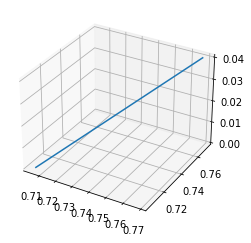

In [3]:
friction_coeff = np.zeros((10,10))
pressure_dist = np.zeros((10,10))

# construct one in the shape of circle
# x_ind, y_ind = np.indices(friction_coeff.shape)
# mask = (np.sqrt((x_ind-5)**2+(y_ind-5)**2) <= 5)
# friction_coeff[mask] = 1
# pressure_dist[mask] = 1
friction_coeff += 1
pressure_dist += 1


width = 0.8
height = 0.4

grid_ls = GridLimitSurface(friction_coeff, pressure_dist, width, height)
grid_ls.construct_limit_surface(n_samples=75000)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
grid_ls.get_twist(F=np.array([0.1,0.1,0]), ax=ax)

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[0.00115992 0.00207435 0.00286776 ... 0.58693314 0.58989223 0.59060864]
load:  [-0.5413694   0.56668819  0.08915208]
F:  [0.25881905 0.96592583 0.38983785]
projected point:  [0.11837856 0.44179479 0.17830389]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.38983785]
projected point:  [0.11837856 0.44179479 0.17830389]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.38983785]
projected point:  [0.11837856 0.44179479 0.17830389]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
V:  [0.00139209 0.01583943 0.0690302

/home/yinglong/Documents/research/control/code/control_playground/scripts/pushing/refined_push_sim.py:272: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[0.00105082 0.00196345 0.00276035 ... 0.58685375 0.58981869 0.59052316]
load:  [-0.5413694   0.56668819  0.08915208]
F:  [0.25881905 0.96592583 0.38969111]
projected point:  [0.11840673 0.44189993 0.17827919]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.38969111]
projected point:  [0.11840673 0.44189993 0.17827919]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.38969111]
projected point:  [0.11840673 0.44189993 0.17827919]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
V:  [0.00138151 0.01584454 0.0690482

sorted similarity scores: 
[ 1.          1.          1.         ... -0.99999998 -0.99999999
 -1.        ]
sorted errors: 
[1.84221053e-04 1.08246126e-03 1.90704892e-03 ... 5.89234513e-01
 5.89844114e-01 5.91382425e-01]
load:  [-0.5413694   0.56668819  0.08915208]
F:  [0.25881905 0.96592583 0.38852545]
projected point:  [0.11863102 0.44273698 0.1780826 ]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.38852545]
projected point:  [0.11863102 0.44273698 0.1780826 ]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.38852545]
projected point:  [0.11863102 0.44273698 0.1780826 ]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[2.12581064e-04 6.71454076e-04 1.06451286e-03 ... 5.88657707e-01
 5.89173642e-01 5.90865561e-01]
load:  [-0.52270824  0.56758522  0.09250113]
F:  [0.25881905 0.96592583 0.3873745 ]
projected point:  [0.11885331 0.44356659 0.17788776]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.3873745 ]
projected point:  [0.11885331 0.44356659 0.17788776]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.3873745 ]
projected point:  [0.11885331 0.44356659 0.17788776]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
V:  [0.0012

/home/yinglong/Documents/research/control/code/control_playground/scripts/pushing/refined_push_sim.py:216: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


F:  [0.25881905 0.96592583 0.38708907]
projected point:  [0.11890856 0.44377281 0.17783933]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.38708907]
projected point:  [0.11890856 0.44377281 0.17783933]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
V:  [0.00118948 0.01593323 0.06936486]
sorted similarity scores: 
[ 1.          1.          1.         ... -0.99999998 -0.99999999
 -1.        ]
sorted errors: 
[1.10745595e-04 7.51349712e-04 9.89500870e-04 ... 5.88924436e-01
 5.90673448e-01 5.97121295e-01]
load:  [-0.52270824  0.56758522  0.09250113]
F:  [0.25881905 0.96592583 0.3869467 ]
projected point:  [0.11893614 0.44387574 0.17781516]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.

sorted similarity scores: 
[ 1.          1.          0.99999999 ... -0.99999999 -1.
 -1.        ]
sorted errors: 
[7.62814647e-05 4.41803392e-04 9.65236849e-04 ... 5.90165736e-01
 5.96485833e-01 6.00389144e-01]
load:  [-0.56181932  0.5686169   0.08434697]
F:  [0.25881905 0.96592583 0.38581611]
projected point:  [0.11915562 0.44469483 0.17762278]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.38581611]
projected point:  [0.11915562 0.44469483 0.17762278]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.38581611]
projected point:  [0.11915562 0.44469483 0.17762278]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[3.81222396e-04 8.92993921e-04 1.80318243e-03 ... 5.95858762e-01
 5.99933404e-01 6.01724779e-01]
load:  [-0.55349486  0.56937972  0.08586148]
F:  [0.25881905 0.96592583 0.38470045]
projected point:  [0.119373   0.44550609 0.17743225]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.38470045]
projected point:  [0.119373   0.44550609 0.17743225]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.38470045]
projected point:  [0.119373   0.44550609 0.17743225]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
V:  [0.0010

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[0.00087673 0.00274351 0.00275861 ... 0.59775983 0.59942803 0.60107843]
load:  [-0.53847286  0.57208782  0.08806926]
F:  [0.25881905 0.96592583 0.38346328]
projected point:  [0.11961498 0.44640917 0.17722015]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.38346328]
projected point:  [0.11961498 0.44640917 0.17722015]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.38346328]
projected point:  [0.11961498 0.44640917 0.17722015]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
V:  [0.00090663 0.01605021 0.0697913

F:  [0.25881905 0.96592583 0.38237962]
projected point:  [0.11982774 0.4472032  0.17703367]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.38237962]
projected point:  [0.11982774 0.4472032  0.17703367]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
V:  [0.00081838 0.01608347 0.06991494]
sorted similarity scores: 
[ 1.          1.          1.         ... -0.99999999 -1.
 -1.        ]
sorted errors: 
[3.54120192e-05 1.78207427e-03 3.66412479e-03 ... 6.01238078e-01
 6.01256606e-01 6.09184822e-01]
load:  [-0.53847286  0.57208782  0.08806926]
F:  [0.25881905 0.96592583 0.38224523]
projected point:  [0.11985417 0.44730187 0.17701049]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784

F:  [0.25881905 0.96592583 0.38131117]
projected point:  [0.12003825 0.44798887 0.17684915]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.38131117]
projected point:  [0.12003825 0.44798887 0.17684915]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
V:  [0.00072959 0.0161154  0.07003492]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[0.00083411 0.000927   0.00436896 ... 0.60092431 0.60876742 0.61674726]
load:  [-0.53847286  0.57208782  0.08806926]
F:  [0.25881905 0.96592583 0.38117868]
projected point:  [0.12006441 0.44808648 0.17682622]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.9744825

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[8.41837629e-05 1.62134548e-03 3.98661745e-03 ... 6.08466144e-01
 6.11318195e-01 6.16413606e-01]
load:  [-0.4552579   0.57192392  0.10331231]
F:  [0.25881905 0.96592583 0.38012744]
projected point:  [0.12027235 0.44886252 0.17664396]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.38012744]
projected point:  [0.12027235 0.44886252 0.17664396]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.38012744]
projected point:  [0.12027235 0.44886252 0.17664396]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
V:  [0.0006

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[0.0007463  0.00313735 0.00604771 ... 0.61074315 0.61608485 0.61705738]
load:  [-0.4552579   0.57192392  0.10331231]
F:  [0.25881905 0.96592583 0.37909158]
projected point:  [0.12047795 0.44962985 0.17646375]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.37909158]
projected point:  [0.12047795 0.44962985 0.17646375]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.37909158]
projected point:  [0.12047795 0.44962985 0.17646375]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
V:  [0.00053922 0.0161788  0.0702774

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[0.00166576 0.00219709 0.00371427 ... 0.62478032 0.62653669 0.63065614]
load:  [-0.4552579   0.57192392  0.10331231]
F:  [0.25881905 0.96592583 0.37794475]
projected point:  [0.12070641 0.45048244 0.1762635 ]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.37794475]
projected point:  [0.12070641 0.45048244 0.1762635 ]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.37794475]
projected point:  [0.12070641 0.45048244 0.1762635 ]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
V:  [0.00043755 0.01620985 0.0703989

sorted similarity scores: 
[ 1.          1.          0.99999999 ... -1.         -1.
 -1.        ]
sorted errors: 
[0.00127298 0.00256942 0.00274909 ... 0.62432673 0.62606065 0.63012588]
load:  [-0.42990363  0.57497588  0.10658927]
F:  [0.25881905 0.96592583 0.37681762]
projected point:  [0.12093178 0.45132354 0.17606596]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.37681762]
projected point:  [0.12093178 0.45132354 0.17606596]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.37681762]
projected point:  [0.12093178 0.45132354 0.17606596]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[4.65190021e-04 1.90539054e-03 3.35934042e-03 ... 6.24562926e-01
 6.25644545e-01 6.29662378e-01]
load:  [-0.42990363  0.57497588  0.10658927]
F:  [0.25881905 0.96592583 0.37583238]
projected point:  [0.12112947 0.45206134 0.17589268]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.37583238]
projected point:  [0.12112947 0.45206134 0.17589268]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
F:  [0.25881905 0.96592583 0.37583238]
projected point:  [0.12112947 0.45206134 0.17589268]
face point:  [[0.11913144 0.43015808 0.18095882]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01965174 0.22360135 0.97448255]
V:  [0.0002

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[3.13873409e-04 1.09169733e-03 2.97969577e-03 ... 6.25243249e-01
 6.29215370e-01 6.33980814e-01]
load:  [-0.42990363  0.57497588  0.10658927]
F:  [0.25881905 0.96592583 0.37488218]
projected point:  [0.1213196  0.45277092 0.17572338]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.37488218]
projected point:  [0.1213196  0.45277092 0.17572338]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.37488218]
projected point:  [0.1213196  0.45277092 0.17572338]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.000

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[3.41050418e-04 1.03257598e-03 4.82397463e-03 ... 6.28803029e-01
 6.33322128e-01 6.33661262e-01]
load:  [-0.37024479  0.57180464  0.11647761]
F:  [0.25881905 0.96592583 0.37400564]
projected point:  [0.12149362 0.45342035 0.17556396]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.37400564]
projected point:  [0.12149362 0.45342035 0.17556396]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.37400564]
projected point:  [0.12149362 0.45342035 0.17556396]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.000

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[3.96063126e-04 1.73832167e-03 3.87294460e-03 ... 6.32988730e-01
 6.33347480e-01 6.34821723e-01]
load:  [-0.37024479  0.57180464  0.11647761]
F:  [0.25881905 0.96592583 0.3731449 ]
projected point:  [0.12166498 0.45405989 0.17540698]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.3731449 ]
projected point:  [0.12166498 0.45405989 0.17540698]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.3731449 ]
projected point:  [0.12166498 0.45405989 0.17540698]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.000

sorted similarity scores: 
[ 1.          1.          1.         ... -0.99999999 -1.
 -1.        ]
sorted errors: 
[0.00111958 0.00243105 0.00462222 ... 0.63455711 0.63573322 0.63860758]
load:  [-0.37024479  0.57180464  0.11647761]
F:  [0.25881905 0.96592583 0.37230004]
projected point:  [0.12183365 0.45468938 0.17525246]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.37230004]
projected point:  [0.12183365 0.45468938 0.17525246]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.37230004]
projected point:  [0.12183365 0.45468938 0.17525246]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[0.00191721 0.00319474 0.00482315 ... 0.63836844 0.63886202 0.64504116]
load:  [-0.37024479  0.57180464  0.11647761]
F:  [0.25881905 0.96592583 0.37136866]
projected point:  [0.12202014 0.45538536 0.17508161]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.37136866]
projected point:  [0.12202014 0.45538536 0.17508161]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.37136866]
projected point:  [0.12202014 0.45538536 0.17508161]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.00095224  0.01682339  0.0693

sorted similarity scores: 
[ 1.          1.          1.         ... -0.99999999 -0.99999999
 -1.        ]
sorted errors: 
[0.00269746 0.00402833 0.00625627 ... 0.64096031 0.64467383 0.64545482]
load:  [-0.37024479  0.57180464  0.11647761]
F:  [0.25881905 0.96592583 0.37045757]
projected point:  [0.12220312 0.45606825 0.17491398]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.37045757]
projected point:  [0.12220312 0.45606825 0.17491398]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.37045757]
projected point:  [0.12220312 0.45606825 0.17491398]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103

F:  [0.25881905 0.96592583 0.36966483]
projected point:  [0.12236278 0.4566641  0.17476772]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36966483]
projected point:  [0.12236278 0.4566641  0.17476772]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.00115291  0.01684146  0.06952253]
sorted similarity scores: 
[ 1.          1.          1.         ... -0.99999996 -0.99999997
 -0.99999999]
sorted errors: 
[0.00325129 0.00346026 0.0061187  ... 0.65276746 0.65886527 0.66494181]
load:  [-0.34899992  0.57685648  0.11777197]
F:  [0.25881905 0.96592583 0.36956687]
projected point:  [0.12238253 0.45673783 0.17474962]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[0.00257559 0.00412357 0.00541605 ... 0.65792134 0.65858446 0.66463915]
load:  [-0.34899992  0.57685648  0.11777197]
F:  [0.25881905 0.96592583 0.36879235]
projected point:  [0.12253898 0.45732168 0.1746063 ]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36879235]
projected point:  [0.12253898 0.45732168 0.1746063 ]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36879235]
projected point:  [0.12253898 0.45732168 0.1746063 ]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.00125937  0.01684825  0.0695

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[0.00183238 0.00464319 0.00485315 ... 0.65811102 0.65827561 0.66430626]
load:  [-0.34899992  0.57685648  0.11777197]
F:  [0.25881905 0.96592583 0.36794045]
projected point:  [0.12271151 0.45796559 0.17444824]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36794045]
projected point:  [0.12271151 0.45796559 0.17444824]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36794045]
projected point:  [0.12271151 0.45796559 0.17444824]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.00136595  0.01685311  0.0696

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[0.0011072  0.00322749 0.00388909 ... 0.66398146 0.66423209 0.66879295]
load:  [-0.34899992  0.57685648  0.11777197]
F:  [0.25881905 0.96592583 0.36710923]
projected point:  [0.12288032 0.45859561 0.17429359]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36710923]
projected point:  [0.12288032 0.45859561 0.17429359]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36710923]
projected point:  [0.12288032 0.45859561 0.17429359]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.00147261  0.01685602  0.0696

sorted errors: 
[4.77803418e-04 3.23458493e-03 3.89250017e-03 ... 6.64006853e-01
 6.68460681e-01 6.74029223e-01]
load:  [-0.34899992  0.57685648  0.11777197]
F:  [0.25881905 0.96592583 0.3663878 ]
projected point:  [0.12302722 0.45914383 0.17415902]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.3663878 ]
projected point:  [0.12302722 0.45914383 0.17415902]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.3663878 ]
projected point:  [0.12302722 0.45914383 0.17415902]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.00156746  0.01685696  0.06972348]
sorted similarity scores: 

sorted similarity scores: 
[ 1.          1.          0.99999999 ... -1.         -1.
 -1.        ]
sorted errors: 
[1.37226656e-04 2.59502400e-03 4.54232498e-03 ... 6.69881833e-01
 6.73785589e-01 6.77770302e-01]
load:  [-0.34899992  0.57685648  0.11777197]
F:  [0.25881905 0.96592583 0.36568285]
projected point:  [0.1231711  0.45968079 0.17402721]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36568285]
projected point:  [0.1231711  0.45968079 0.17402721]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36568285]
projected point:  [0.1231711  0.45968079 0.17402721]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[0.00073783 0.00197046 0.00517691 ... 0.67379613 0.67756971 0.68760766]
load:  [-0.34899992  0.57685648  0.11777197]
F:  [0.25881905 0.96592583 0.36499444]
projected point:  [0.12331192 0.46020636 0.1738982 ]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36499444]
projected point:  [0.12331192 0.46020636 0.1738982 ]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36499444]
projected point:  [0.12331192 0.46020636 0.1738982 ]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.00175714  0.01685417  0.0697

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[0.00128583 0.00139621 0.00330552 ... 0.68744355 0.69989603 0.70071693]
load:  [-0.28745479  0.57173597  0.12662963]
F:  [0.25881905 0.96592583 0.36423982]
projected point:  [0.12346666 0.46078386 0.17375644]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36423982]
projected point:  [0.12346666 0.46078386 0.17375644]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36423982]
projected point:  [0.12346666 0.46078386 0.17375644]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.00186376  0.01684987  0.0698

sorted similarity scores: 
[ 1.          1.          0.99999999 ... -1.         -1.
 -1.        ]
sorted errors: 
[6.20336292e-04 2.03617918e-03 2.61024504e-03 ... 6.87284038e-01
 6.99715181e-01 7.00487014e-01]
load:  [-0.28745479  0.57173597  0.12662963]
F:  [0.25881905 0.96592583 0.36350631]
projected point:  [0.12361745 0.46134661 0.1736183 ]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36350631]
projected point:  [0.12361745 0.46134661 0.1736183 ]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36350631]
projected point:  [0.12361745 0.46134661 0.1736183 ]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[4.49109135e-05 2.00906989e-03 3.53561340e-03 ... 6.89321734e-01
 6.99558821e-01 7.00288225e-01]
load:  [-0.28745479  0.57173597  0.12662963]
F:  [0.25881905 0.96592583 0.36287208]
projected point:  [0.12374812 0.46183429 0.17349859]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36287208]
projected point:  [0.12374812 0.46183429 0.17349859]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36287208]
projected point:  [0.12374812 0.46183429 0.17349859]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.002

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[5.15281313e-04 1.42381090e-03 2.95790792e-03 ... 6.99244323e-01
 6.99406610e-01 7.00094708e-01]
load:  [-0.28745479  0.57173597  0.12662963]
F:  [0.25881905 0.96592583 0.36225465]
projected point:  [0.1238756  0.46231005 0.17338181]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36225465]
projected point:  [0.1238756  0.46231005 0.17338181]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36225465]
projected point:  [0.1238756  0.46231005 0.17338181]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.002

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[2.69676422e-04 8.54522262e-04 1.06018851e-03 ... 6.99175519e-01
 6.99258562e-01 6.99906483e-01]
load:  [-0.16534076  0.55094043  0.14352828]
F:  [0.25881905 0.96592583 0.36165407]
projected point:  [0.12399986 0.46277376 0.17326798]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36165407]
projected point:  [0.12399986 0.46277376 0.17326798]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36165407]
projected point:  [0.12399986 0.46277376 0.17326798]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.002

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[2.91844733e-04 3.01256935e-04 1.58976000e-03 ... 7.04066213e-01
 7.05116928e-01 7.14212103e-01]
load:  [-0.16534076  0.55094043  0.14352828]
F:  [0.25881905 0.96592583 0.36107041]
projected point:  [0.12412085 0.46322531 0.17315714]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36107041]
projected point:  [0.12412085 0.46322531 0.17315714]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36107041]
projected point:  [0.12412085 0.46322531 0.17315714]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.002

sorted similarity scores: 
[ 1.          1.          1.         ... -0.99999999 -0.99999999
 -1.        ]
sorted errors: 
[2.29017581e-04 2.35933387e-04 8.37050353e-04 ... 7.14017072e-01
 7.14103477e-01 7.22491449e-01]
load:  [-0.14453592  0.54715496  0.14584903]
within cone
F:  [-0.14453592  0.54715496  0.14584903]
projected point:  [-0.14453592  0.54715496  0.14584903]
face point:  [[-0.16351854  0.53805326  0.14715119]
 [-0.1085316   0.54095529  0.14974472]
 [-0.16155762  0.56245634  0.14065118]]
normal:  [-0.05923538  0.26137605  0.96341774]
F:  [-0.14453592  0.54715496  0.14584903]
projected point:  [-0.14453592  0.54715496  0.14584903]
face point:  [[-0.16351854  0.53805326  0.14715119]
 [-0.1085316   0.54095529  0.14974472]
 [-0.16155762  0.56245634  0.14065118]]
normal:  [-0.05923538  0.26137605  0.96341774]
V:  [-0.00740352  0.01694814  0.06648424]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[2.13215574e-04 2.51390708e-04 8.52736359e-04 ... 7.14014

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[8.23838830e-05 3.79371440e-04 9.82608681e-04 ... 7.22465960e-01
 7.24931942e-01 7.34466098e-01]
load:  [-0.14453592  0.54715496  0.14584903]
within cone
F:  [-0.14453592  0.54715496  0.14584903]
projected point:  [-0.14453592  0.54715496  0.14584903]
face point:  [[-0.16351854  0.53805326  0.14715119]
 [-0.1085316   0.54095529  0.14974472]
 [-0.16155762  0.56245634  0.14065118]]
normal:  [-0.05923538  0.26137605  0.96341774]
F:  [-0.14453592  0.54715496  0.14584903]
projected point:  [-0.14453592  0.54715496  0.14584903]
face point:  [[-0.16351854  0.53805326  0.14715119]
 [-0.1085316   0.54095529  0.14974472]
 [-0.16155762  0.56245634  0.14065118]]
normal:  [-0.05923538  0.26137605  0.96341774]
V:  [-0.00750825  0.01688118  0.06641586]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[6.91125478e-05 3.92353922e-04 9.95782827e-04 ... 7.22463657e-01
 7.24929996e-01 7.34463026e-01]
load:  [-

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[3.89345773e-05 4.98052761e-04 1.06081474e-03 ... 7.34438056e-01
 7.37011461e-01 7.50863576e-01]
load:  [-0.14453592  0.54715496  0.14584903]
within cone
F:  [-0.14453592  0.54715496  0.14584903]
projected point:  [-0.14453592  0.54715496  0.14584903]
face point:  [[-0.16351854  0.53805326  0.14715119]
 [-0.1085316   0.54095529  0.14974472]
 [-0.16155762  0.56245634  0.14065118]]
normal:  [-0.05923538  0.26137605  0.96341774]
F:  [-0.14453592  0.54715496  0.14584903]
projected point:  [-0.14453592  0.54715496  0.14584903]
face point:  [[-0.16351854  0.53805326  0.14715119]
 [-0.1085316   0.54095529  0.14974472]
 [-0.16155762  0.56245634  0.14065118]]
normal:  [-0.05923538  0.26137605  0.96341774]
V:  [-0.00761163  0.01681214  0.06634157]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[4.96734105e-05 5.08558612e-04 1.05044287e-03 ... 7.34435579e-01
 7.37009412e-01 7.50861203e-01]
load:  [-

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.34921053e-04 5.07158459e-04 5.91960962e-04 ... 7.50274912e-01
 7.50842410e-01 7.53958168e-01]
load:  [-0.14453592  0.54715496  0.14584903]
within cone
F:  [-0.14453592  0.54715496  0.14584903]
projected point:  [-0.14453592  0.54715496  0.14584903]
face point:  [[-0.16351854  0.53805326  0.14715119]
 [-0.1085316   0.54095529  0.14974472]
 [-0.16155762  0.56245634  0.14065118]]
normal:  [-0.05923538  0.26137605  0.96341774]
F:  [-0.14453592  0.54715496  0.14584903]
projected point:  [-0.14453592  0.54715496  0.14584903]
face point:  [[-0.16351854  0.53805326  0.14715119]
 [-0.1085316   0.54095529  0.14974472]
 [-0.16155762  0.56245634  0.14065118]]
normal:  [-0.05923538  0.26137605  0.96341774]
V:  [-0.0077136   0.01674105  0.06626139]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.43125899e-04 4.98855576e-04 5.99988731e-04 ... 7.50273364e-01
 7.50840607e-01 7.53955743e-01]
load:  [-

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[2.05562263e-04 4.35677804e-04 6.61083048e-04 ... 7.53937341e-01
 7.65051654e-01 7.67076683e-01]
load:  [-0.14453592  0.54715496  0.14584903]
within cone
F:  [-0.14453592  0.54715496  0.14584903]
projected point:  [-0.14453592  0.54715496  0.14584903]
face point:  [[-0.16351854  0.53805326  0.14715119]
 [-0.1085316   0.54095529  0.14974472]
 [-0.16155762  0.56245634  0.14065118]]
normal:  [-0.05923538  0.26137605  0.96341774]
F:  [-0.14453592  0.54715496  0.14584903]
projected point:  [-0.14453592  0.54715496  0.14584903]
face point:  [[-0.16351854  0.53805326  0.14715119]
 [-0.1085316   0.54095529  0.14974472]
 [-0.16155762  0.56245634  0.14065118]]
normal:  [-0.05923538  0.26137605  0.96341774]
V:  [-0.00781413  0.01666793  0.06617536]
sorted similarity scores: 
[ 1.          1.          1.         ... -0.99999999 -1.
 -1.        ]
sorted errors: 
[2.11231986e-04 4.29941361e-04 6.66631621e-04 ... 7.53935677e-01


sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[2.50848404e-04 3.89865421e-04 7.05409419e-04 ... 7.65041068e-01
 7.65392392e-01 7.67067222e-01]
load:  [-0.14453592  0.54715496  0.14584903]
within cone
F:  [-0.14453592  0.54715496  0.14584903]
projected point:  [-0.14453592  0.54715496  0.14584903]
face point:  [[-0.16351854  0.53805326  0.14715119]
 [-0.1085316   0.54095529  0.14974472]
 [-0.16155762  0.56245634  0.14065118]]
normal:  [-0.05923538  0.26137605  0.96341774]
F:  [-0.14453592  0.54715496  0.14584903]
projected point:  [-0.14453592  0.54715496  0.14584903]
face point:  [[-0.16351854  0.53805326  0.14715119]
 [-0.1085316   0.54095529  0.14974472]
 [-0.16155762  0.56245634  0.14065118]]
normal:  [-0.05923538  0.26137605  0.96341774]
V:  [-0.0079132   0.01659282  0.06608351]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[2.53982216e-04 3.86696214e-04 7.08478023e-04 ... 7.65040348e-01
 7.65391197e-01 7.67066579e-01]
load:  [-

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.89255904e-04 2.78579074e-04 3.60809955e-04 ... 7.65014823e-01
 7.65349479e-01 7.67043713e-01]
load:  [-0.08408594  0.53245274  0.1531438 ]
within cone
F:  [-0.08408594  0.53245274  0.1531438 ]
projected point:  [-0.08408594  0.53245274  0.1531438 ]
face point:  [[-0.08231319  0.51504704  0.15774739]
 [-0.08959385  0.5366928   0.1518183 ]
 [-0.08035079  0.54561838  0.1498657 ]]
normal:  [-0.0388724   0.25180003  0.96699828]
F:  [-0.08408594  0.53245274  0.1531438 ]
projected point:  [-0.08408594  0.53245274  0.1531438 ]
face point:  [[-0.08231319  0.51504704  0.15774739]
 [-0.08959385  0.5366928   0.1518183 ]
 [-0.08035079  0.54561838  0.1498657 ]]
normal:  [-0.0388724   0.25180003  0.96699828]
V:  [-0.00660375  0.01643887  0.06723785]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[2.05072627e-04 2.62801416e-04 3.76398431e-04 ... 7.65011086e-01
 7.65343379e-01 7.67040365e-01]
load:  [-

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.80954546e-04 2.87118068e-04 4.57276419e-04 ... 7.87931449e-01
 7.91924555e-01 8.00814414e-01]
load:  [-0.09864912  0.53677653  0.15134672]
within cone
F:  [-0.09864912  0.53677653  0.15134672]
projected point:  [-0.09864912  0.53677653  0.15134672]
face point:  [[-0.08959385  0.5366928   0.1518183 ]
 [-0.1085316   0.54095529  0.14974472]
 [-0.09782191  0.53268151  0.15247715]]
normal:  [-0.04789531  0.25678965  0.96527981]
F:  [-0.09864912  0.53677653  0.15134672]
projected point:  [-0.09864912  0.53677653  0.15134672]
face point:  [[-0.08959385  0.5366928   0.1518183 ]
 [-0.1085316   0.54095529  0.14974472]
 [-0.09782191  0.53268151  0.15247715]]
normal:  [-0.04789531  0.25678965  0.96527981]
V:  [-0.00733582  0.01643192  0.06649719]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.74694431e-04 2.93393036e-04 4.63463452e-04 ... 7.87929787e-01
 7.91922558e-01 8.00812568e-01]
load:  [-

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.30014485e-04 3.38176984e-04 5.07627957e-04 ... 7.91908372e-01
 8.00799462e-01 8.07726843e-01]
load:  [-0.09864912  0.53677653  0.15134672]
within cone
F:  [-0.09864912  0.53677653  0.15134672]
projected point:  [-0.09864912  0.53677653  0.15134672]
face point:  [[-0.08959385  0.5366928   0.1518183 ]
 [-0.1085316   0.54095529  0.14974472]
 [-0.09782191  0.53268151  0.15247715]]
normal:  [-0.04789531  0.25678965  0.96527981]
F:  [-0.09864912  0.53677653  0.15134672]
projected point:  [-0.09864912  0.53677653  0.15134672]
face point:  [[-0.08959385  0.5366928   0.1518183 ]
 [-0.1085316   0.54095529  0.14974472]
 [-0.09782191  0.53268151  0.15247715]]
normal:  [-0.04789531  0.25678965  0.96527981]
V:  [-0.0074335   0.01635783  0.06639579]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.26345851e-04 3.41853876e-04 5.11255130e-04 ... 7.91907217e-01
 8.00798395e-01 8.07725569e-01]
load:  [-

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.04991889e-04 3.63252478e-04 5.32378262e-04 ... 8.12726140e-01
 8.16187419e-01 8.27136982e-01]
load:  [-0.09864912  0.53677653  0.15134672]
within cone
F:  [-0.09864912  0.53677653  0.15134672]
projected point:  [-0.09864912  0.53677653  0.15134672]
face point:  [[-0.08959385  0.5366928   0.1518183 ]
 [-0.1085316   0.54095529  0.14974472]
 [-0.09782191  0.53268151  0.15247715]]
normal:  [-0.04789531  0.25678965  0.96527981]
F:  [-0.09864912  0.53677653  0.15134672]
projected point:  [-0.09864912  0.53677653  0.15134672]
face point:  [[-0.08959385  0.5366928   0.1518183 ]
 [-0.1085316   0.54095529  0.14974472]
 [-0.09782191  0.53268151  0.15247715]]
normal:  [-0.04789531  0.25678965  0.96527981]
V:  [-0.00752968  0.0162818   0.06628851]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.03915261e-04 3.64330768e-04 5.33445056e-04 ... 8.16187401e-01
 8.18663475e-01 8.27136857e-01]
load:  [-

sorted similarity scores: 
[ 1.          1.          1.         ... -0.99999999 -1.
 -1.        ]
sorted errors: 
[1.05890360e-04 3.62340942e-04 5.31523767e-04 ... 8.18663832e-01
 8.27137462e-01 8.38763722e-01]
load:  [-0.09864912  0.53677653  0.15134672]
within cone
F:  [-0.09864912  0.53677653  0.15134672]
projected point:  [-0.09864912  0.53677653  0.15134672]
face point:  [[-0.08959385  0.5366928   0.1518183 ]
 [-0.1085316   0.54095529  0.14974472]
 [-0.09782191  0.53268151  0.15247715]]
normal:  [-0.04789531  0.25678965  0.96527981]
F:  [-0.09864912  0.53677653  0.15134672]
projected point:  [-0.09864912  0.53677653  0.15134672]
face point:  [[-0.08959385  0.5366928   0.1518183 ]
 [-0.1085316   0.54095529  0.14974472]
 [-0.09782191  0.53268151  0.15247715]]
normal:  [-0.04789531  0.25678965  0.96527981]
V:  [-0.00762433  0.01620387  0.0661754 ]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.07405896e-04 3.60820472e-04 5.30030023e-04 ... 8.18663910e-01


sorted similarity scores: 
[ 1.          0.99999999  0.99999999 ... -1.         -1.
 -1.        ]
sorted errors: 
[1.32709862e-04 3.35442416e-04 5.05064494e-04 ... 8.22767556e-01
 8.27141800e-01 8.38769033e-01]
load:  [-0.09864912  0.53677653  0.15134672]
within cone
F:  [-0.09864912  0.53677653  0.15134672]
projected point:  [-0.09864912  0.53677653  0.15134672]
face point:  [[-0.08959385  0.5366928   0.1518183 ]
 [-0.1085316   0.54095529  0.14974472]
 [-0.09782191  0.53268151  0.15247715]]
normal:  [-0.04789531  0.25678965  0.96527981]
F:  [-0.09864912  0.53677653  0.15134672]
projected point:  [-0.09864912  0.53677653  0.15134672]
face point:  [[-0.08959385  0.5366928   0.1518183 ]
 [-0.1085316   0.54095529  0.14974472]
 [-0.09782191  0.53268151  0.15247715]]
normal:  [-0.04789531  0.25678965  0.96527981]
V:  [-0.00771741  0.01612408  0.0660565 ]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.36817360e-04 3.31323389e-04 5.01010412e-04 ... 8.22768547e-01


sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.85446728e-04 2.82560579e-04 4.53004058e-04 ... 8.22780177e-01
 8.27149993e-01 8.38779144e-01]
load:  [-0.09864912  0.53677653  0.15134672]
within cone
F:  [-0.09864912  0.53677653  0.15134672]
projected point:  [-0.09864912  0.53677653  0.15134672]
face point:  [[-0.08959385  0.5366928   0.1518183 ]
 [-0.1085316   0.54095529  0.14974472]
 [-0.09782191  0.53268151  0.15247715]]
normal:  [-0.04789531  0.25678965  0.96527981]
F:  [-0.09864912  0.53677653  0.15134672]
projected point:  [-0.09864912  0.53677653  0.15134672]
face point:  [[-0.08959385  0.5366928   0.1518183 ]
 [-0.1085316   0.54095529  0.14974472]
 [-0.09782191  0.53268151  0.15247715]]
normal:  [-0.04789531  0.25678965  0.96527981]
V:  [-0.0078089   0.01604247  0.06593187]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.92145620e-04 2.75843564e-04 4.46390197e-04 ... 8.22781770e-01
 8.27151024e-01 8.38780419e-01]
load:  [-

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[2.24282463e-04 2.43566148e-04 3.95626825e-04 ... 8.27158988e-01
 8.38790253e-01 8.51376017e-01]
load:  [-0.08408594  0.53245274  0.1531438 ]
within cone
F:  [-0.08408594  0.53245274  0.1531438 ]
projected point:  [-0.08408594  0.53245274  0.1531438 ]
face point:  [[-0.08231319  0.51504704  0.15774739]
 [-0.08959385  0.5366928   0.1518183 ]
 [-0.08035079  0.54561838  0.1498657 ]]
normal:  [-0.0388724   0.25180003  0.96699828]
F:  [-0.08408594  0.53245274  0.1531438 ]
projected point:  [-0.08408594  0.53245274  0.1531438 ]
face point:  [[-0.08231319  0.51504704  0.15774739]
 [-0.08959385  0.5366928   0.1518183 ]
 [-0.08035079  0.54561838  0.1498657 ]]
normal:  [-0.0388724   0.25180003  0.96699828]
V:  [-0.00727214  0.01592449  0.06644338]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[2.21822960e-04 2.46018324e-04 3.01275774e-03 ... 8.27159388e-01
 8.38790742e-01 8.51375878e-01]
load:  [-

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[7.12107223e-05 1.53053641e-04 3.15014222e-04 ... 8.49966574e-01
 8.51382531e-01 8.65249354e-01]
load:  [0.0330943  0.49686973 0.16509398]
within cone
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
V:  [-0.00545193  0.01566996  0.06852929]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[8.72284149e-05 1.37016307e-04 3.31091245e-04 ... 8.51383663e-01
 8.65244713e-01 8.73481756e-01]
load:  [0.0330943  0.496

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.07632052e-04 1.16505761e-04 3.51644075e-04 ... 8.65239046e-01
 8.73479499e-01 8.86373300e-01]
load:  [0.0330943  0.49686973 0.16509398]
within cone
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
V:  [-0.00554674  0.01560311  0.06839874]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.03148736e-04 1.20970896e-04 3.65033967e-04 ... 8.70402668e-01
 8.73477870e-01 8.86373369e-01]
load:  [-0.09864912  0.5

F:  [-0.09864912  0.53677653  0.15134672]
projected point:  [-0.09864912  0.53677653  0.15134672]
face point:  [[-0.08959385  0.5366928   0.1518183 ]
 [-0.1085316   0.54095529  0.14974472]
 [-0.09782191  0.53268151  0.15247715]]
normal:  [-0.04789531  0.25678965  0.96527981]
F:  [-0.09864912  0.53677653  0.15134672]
projected point:  [-0.09864912  0.53677653  0.15134672]
face point:  [[-0.08959385  0.5366928   0.1518183 ]
 [-0.1085316   0.54095529  0.14974472]
 [-0.09782191  0.53268151  0.15247715]]
normal:  [-0.04789531  0.25678965  0.96527981]
V:  [-0.00817386  0.01570684  0.06543052]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.00295719e-04 1.23729229e-04 3.44390120e-04 ... 8.73480758e-01
 8.86373600e-01 8.92704284e-01]
load:  [0.0330943  0.49686973 0.16509398]
within cone
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]

F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
V:  [-0.00573425  0.01546524  0.06812782]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.92076030e-04 4.36552225e-04 2.79761522e-03 ... 8.98188618e-01
 9.09469562e-01 9.22616498e-01]
load:  [0.0330943  0.49686973 0.16509398]
within cone
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.026047

sorted similarity scores: 
[ 1.          1.          1.         ... -0.99999999 -1.
 -1.        ]
sorted errors: 
[2.56836708e-04 5.01611117e-04 2.73241709e-03 ... 9.02523470e-01
 9.09471835e-01 9.22611475e-01]
load:  [0.0330943  0.49686973 0.16509398]
within cone
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
V:  [-0.00583686  0.01538756  0.06797621]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[2.61826276e-04 5.06625907e-04 2.72739322e-03 ... 9.02523991e-01
 9.09472017e-01

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[2.96853993e-04 1.61535740e-03 2.69211701e-03 ... 9.09473373e-01
 9.21204349e-01 9.22608509e-01]
load:  [0.0330943  0.49686973 0.16509398]
within cone
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
V:  [-0.00593768  0.01530758  0.06781694]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[2.98869848e-04 1.61340820e-03 2.69008575e-03 ... 9.09473463e-01
 9.21203720e-01 9.22608372e-01]
load:  [0.0330943  0.496

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[2.07063301e-04 1.64570651e-03 2.80389885e-03 ... 9.38173810e-01
 9.43755793e-01 9.45492116e-01]
load:  [0.0330943  0.49686973 0.16509398]
within cone
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
V:  [-0.0060353   0.0152219   0.06763471]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[2.05834913e-04 1.64690530e-03 2.80513246e-03 ... 9.38173852e-01
 9.43755885e-01 9.45492311e-01]
load:  [0.0330943  0.496

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.78684505e-04 1.67331886e-03 2.83242961e-03 ... 9.45496306e-01
 9.51370942e-01 9.65331073e-01]
load:  [0.0330943  0.49686973 0.16509398]
within cone
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
V:  [-0.00613238  0.01513745  0.06746009]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.74482901e-04 1.67740268e-03 2.83665534e-03 ... 9.45496909e-01
 9.51372279e-01 9.65332171e-01]
load:  [0.0330943  0.496

sorted similarity scores: 
[ 1.          1.          0.99999999 ... -1.         -1.
 -1.        ]
sorted errors: 
[1.17603656e-04 1.73266326e-03 2.89387030e-03 ... 9.51390278e-01
 9.65346943e-01 9.67951971e-01]
load:  [0.0330943  0.49686973 0.16509398]
within cone
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
V:  [-0.00622756  0.01505087  0.06727809]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.10429601e-04 1.73963137e-03 2.90108737e-03 ... 9.51392541e-01
 9.65348799e-01

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[2.38319137e-05 1.82372886e-03 2.27805640e-03 ... 9.67962602e-01
 9.75934158e-01 9.92052993e-01]
load:  [0.0330943  0.49686973 0.16509398]
within cone
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
V:  [-0.0063208   0.01496222  0.0670888 ]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.36867205e-05 1.83357997e-03 2.28755509e-03 ... 9.67963748e-01
 9.75937970e-01 9.92054278e-01]
load:  [0.0330943  0.496

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.02613537e-04 1.94649893e-03 2.39642705e-03 ... 9.67976841e-01
 9.75981634e-01 9.92068977e-01]
load:  [0.0330943  0.49686973 0.16509398]
within cone
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
V:  [-0.00641206  0.01487155  0.06689233]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.15728007e-04 1.95923124e-03 2.40870239e-03 ... 9.67978314e-01
 9.75986555e-01 9.92070631e-01]
load:  [0.0330943  0.496

F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.02604742  0.46733127  0.17147919]]
normal:  [-0.01242762  0.23497874  0.97192106]
V:  [-0.00649329  0.01478742  0.06670756]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[2.61709496e-04 2.10095093e-03 2.54532992e-03 ... 9.92089022e-01
 1.00022348e+00 1.00173583e+00]
load:  [0.0330943  0.49686973 0.16509398]
within cone
F:  [0.0330943  0.49686973 0.16509398]
projected point:  [0.0330943  0.49686973 0.16509398]
face point:  [[ 0.05484156  0.52095904  0.15954805]
 [ 0.07048876  0.50231888  0.1642547 ]
 [-0.026047

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[0.00222606 0.00266595 0.00343377 ... 1.0017731  1.01438454 1.01834324]
load:  [0.10830633 0.47195219 0.17121143]
within cone
F:  [0.10830633 0.47195219 0.17121143]
projected point:  [0.10830633 0.47195219 0.17121143]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.10830633 0.47195219 0.17121143]
projected point:  [0.10830633 0.47195219 0.17121143]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.00512818  0.01528749  0.06640822]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[0.00223002 0.00266977 0.00342999 ... 1.00177429 1.01438538 1.01834436]
load:  [0.10830633 0.47195219 0.17121143]
within cone
F:  [0.10830633 0.47195219 0.17121143]
proje

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[0.00228409 0.00272193 0.00337853 ... 1.00264994 1.01439669 1.01835966]
load:  [0.10830633 0.47195219 0.17121143]
within cone
F:  [0.10830633 0.47195219 0.17121143]
projected point:  [0.10830633 0.47195219 0.17121143]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.10830633 0.47195219 0.17121143]
projected point:  [0.10830633 0.47195219 0.17121143]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.00522409  0.01520464  0.0662121 ]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[0.00229094 0.00272853 0.00337201 ... 1.00265246 1.01439812 1.01836159]
load:  [0.10830633 0.47195219 0.17121143]
within cone
F:  [0.10830633 0.47195219 0.17121143]
proje

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[0.00237377 0.00280841 0.00329321 ... 1.01441535 1.01838493 1.03985259]
load:  [0.10830633 0.47195219 0.17121143]
within cone
F:  [0.10830633 0.47195219 0.17121143]
projected point:  [0.10830633 0.47195219 0.17121143]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.10830633 0.47195219 0.17121143]
projected point:  [0.10830633 0.47195219 0.17121143]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.00531818  0.01511973  0.06600904]
sorted similarity scores: 
[ 0.99999999  0.99999998  0.99999997 ... -1.         -1.
 -1.        ]
sorted errors: 
[0.00238349 0.00281778 0.00328396 ... 1.01441737 1.01838766 1.03985483]
load:  [0.10830633 0.47195219 0.17121143]
within cone
F: 

sorted similarity scores: 
[ 1.          1.          0.99999999 ... -1.         -1.
 -1.        ]
sorted errors: 
[0.00249507 0.00292536 0.00317782 ... 1.03988053 1.04938497 1.05060431]
load:  [0.10830633 0.47195219 0.17121143]
within cone
F:  [0.10830633 0.47195219 0.17121143]
projected point:  [0.10830633 0.47195219 0.17121143]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.10830633 0.47195219 0.17121143]
projected point:  [0.10830633 0.47195219 0.17121143]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.00541041  0.01503282  0.06579914]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[0.00250767 0.00293751 0.00316584 ... 1.03988343 1.04938701 1.05060715]
load:  [0.10830633 0.47195219 0.17121143]
within cone
F: 

sorted similarity scores: 
[ 1.          1.          1.         ... -0.99999999 -1.
 -1.        ]
sorted errors: 
[8.04795358e-04 2.64798126e-03 3.03238568e-03 ... 1.03991571e+00
 1.04940974e+00 1.05063888e+00]
load:  [0.24564763 0.41088928 0.18086965]
F:  [0.25881905 0.96592583 0.36061176]
projected point:  [0.12421609 0.46358075 0.17306989]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36061176]
projected point:  [0.12421609 0.46358075 0.17306989]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36061176]
projected point:  [0.12421609 0.46358075 0.17306989]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051

sorted similarity scores: 
[ 1.          1.          1.         ... -0.99999999 -1.
 -1.        ]
sorted errors: 
[6.90168489e-04 2.77902145e-03 2.90776066e-03 ... 1.05066850e+00
 1.05098582e+00 1.06262855e+00]
load:  [0.24564763 0.41088928 0.18086965]
F:  [0.25881905 0.96592583 0.36074952]
projected point:  [0.12418747 0.46347393 0.17309611]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36074952]
projected point:  [0.12418747 0.46347393 0.17309611]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36074952]
projected point:  [0.12418747 0.46347393 0.17309611]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[5.60956689e-04 2.76727019e-03 3.34150566e-03 ... 1.05070187e+00
 1.05103661e+00 1.06266012e+00]
load:  [0.24564763 0.41088928 0.18086965]
F:  [0.25881905 0.96592583 0.36090483]
projected point:  [0.12415521 0.46335357 0.17312565]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36090483]
projected point:  [0.12415521 0.46335357 0.17312565]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36090483]
projected point:  [0.12415521 0.46335357 0.17312565]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.005628

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[4.17172446e-04 2.61092784e-03 3.49998198e-03 ... 1.05073899e+00
 1.05109313e+00 1.06269525e+00]
load:  [0.24564763 0.41088928 0.18086965]
F:  [0.25881905 0.96592583 0.36107766]
projected point:  [0.12411934 0.46321969 0.17315852]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36107766]
projected point:  [0.12411934 0.46321969 0.17315852]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36107766]
projected point:  [0.12411934 0.46321969 0.17315852]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.005691

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[2.58829643e-04 2.43874868e-03 3.67451233e-03 ... 1.06250655e+00
 1.06273393e+00 1.06695644e+00]
load:  [0.24564763 0.41088928 0.18086965]
F:  [0.25881905 0.96592583 0.361268  ]
projected point:  [0.12407986 0.46307234 0.17319469]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.361268  ]
projected point:  [0.12407986 0.46307234 0.17319469]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.361268  ]
projected point:  [0.12407986 0.46307234 0.17319469]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.005752

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[8.59435493e-05 2.25074932e-03 3.16404209e-03 ... 1.06277616e+00
 1.06701966e+00 1.06878010e+00]
load:  [0.24564763 0.41088928 0.18086965]
F:  [0.25881905 0.96592583 0.36147584]
projected point:  [0.12403678 0.46291156 0.17323415]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36147584]
projected point:  [0.12403678 0.46291156 0.17323415]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36147584]
projected point:  [0.12403678 0.46291156 0.17323415]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.005812

F:  [0.25881905 0.96592583 0.36170114]
projected point:  [0.12399011 0.46273738 0.17327691]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36170114]
projected point:  [0.12399011 0.46273738 0.17327691]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.00587203  0.01453496  0.06456147]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.25916300e-04 2.02036253e-03 2.96442271e-03 ... 1.06282791e+00
 1.06709712e+00 1.06885539e+00]
load:  [0.24564763 0.41088928 0.18086965]
F:  [0.25881905 0.96592583 0.36173054]
projected point:  [0.12398402 0.46271467 0.17328248]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.0105

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[3.29649899e-04 2.77246296e-03 3.46726515e-03 ... 1.06287767e+00
 1.06717160e+00 1.06892779e+00]
load:  [0.24564763 0.41088928 0.18086965]
F:  [0.25881905 0.96592583 0.36197547]
projected point:  [0.12393333 0.46252549 0.17332892]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36197547]
projected point:  [0.12393333 0.46252549 0.17332892]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36197547]
projected point:  [0.12393333 0.46252549 0.17332892]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.005937

V:  [-0.00598727  0.01439151  0.06419489]
sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[5.47870216e-04 2.56685621e-03 3.24277273e-03 ... 1.06725139e+00
 1.06729869e+00 1.06900534e+00]
load:  [0.24564763 0.41088928 0.18086965]
F:  [0.25881905 0.96592583 0.36223784]
projected point:  [0.12387908 0.46232302 0.17337862]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36223784]
projected point:  [0.12387908 0.46232302 0.17337862]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36223784]
projected point:  [0.12387908 0.46232302 0.17337862]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.0105

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[7.80556343e-04 2.34762216e-03 3.00339733e-03 ... 1.06733645e+00
 1.06737937e+00 1.06908803e+00]
load:  [0.24564763 0.41088928 0.18086965]
F:  [0.25881905 0.96592583 0.3625176 ]
projected point:  [0.12382128 0.46210731 0.17343157]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.3625176 ]
projected point:  [0.12382128 0.46210731 0.17343157]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.3625176 ]
projected point:  [0.12382128 0.46210731 0.17343157]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.006050

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[1.02768603e-03 2.11478178e-03 2.74916184e-03 ... 1.06742680e+00
 1.06746506e+00 1.06917585e+00]
load:  [0.24564763 0.41088928 0.18086965]
F:  [0.25881905 0.96592583 0.36281474]
projected point:  [0.12375995 0.46187843 0.17348776]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36281474]
projected point:  [0.12375995 0.46187843 0.17348776]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36281474]
projected point:  [0.12375995 0.46187843 0.17348776]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.006104

sorted similarity scores: 
[ 1.  1.  1. ... -1. -1. -1.]
sorted errors: 
[0.00132294 0.0018366  0.00244541 ... 1.06753474 1.06756744 1.06928077]
load:  [0.24564763 0.41088928 0.18086965]
F:  [0.25881905 0.96592583 0.36316975]
projected point:  [0.12368676 0.46160527 0.17355481]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36316975]
projected point:  [0.12368676 0.46160527 0.17355481]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
F:  [0.25881905 0.96592583 0.36316975]
projected point:  [0.12368676 0.46160527 0.17355481]
face point:  [[0.07048876 0.50231888 0.1642547 ]
 [0.14285238 0.46790907 0.17181825]
 [0.11157784 0.4456286  0.17756134]]
normal:  [0.01051824 0.23572103 0.97176384]
V:  [-0.0061652   0.01415159  0.0635728

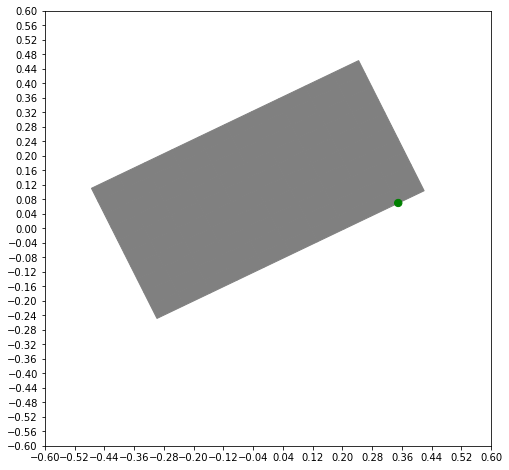

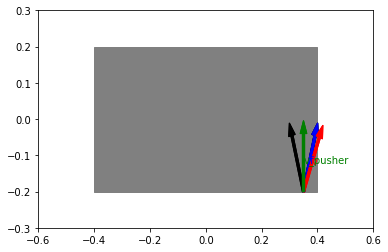

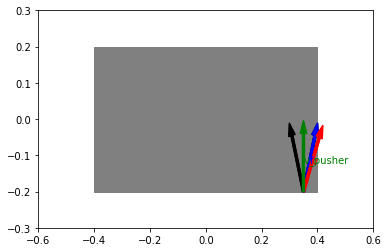

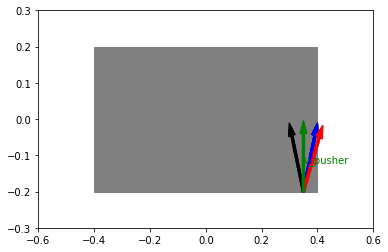

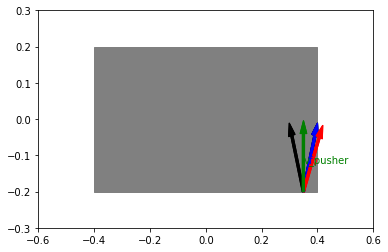

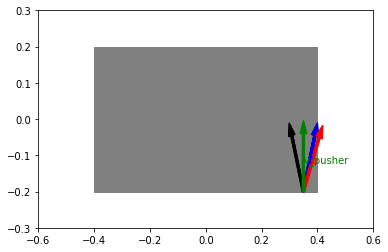

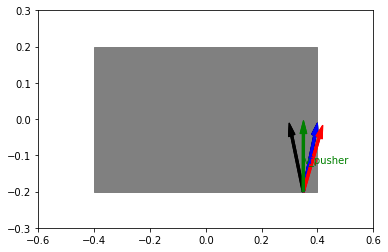

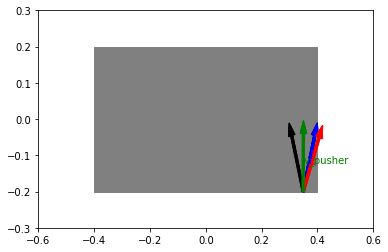

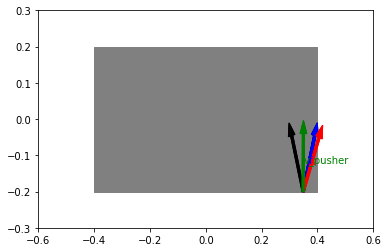

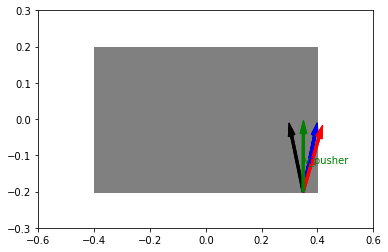

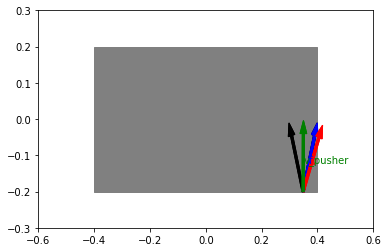

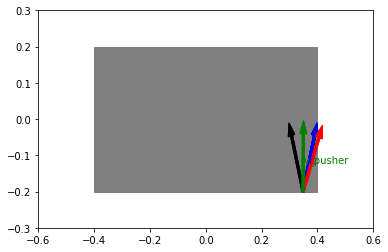

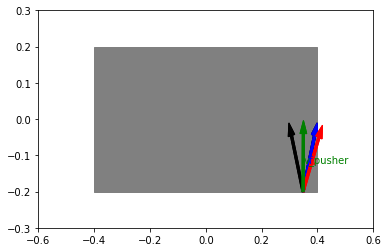

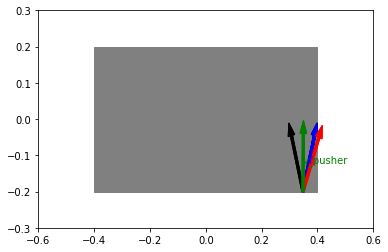

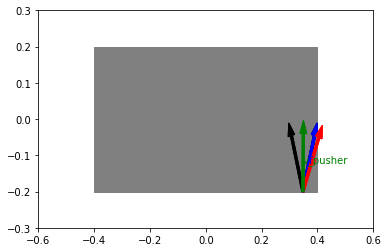

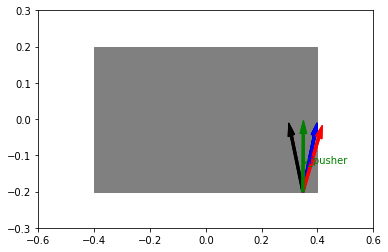

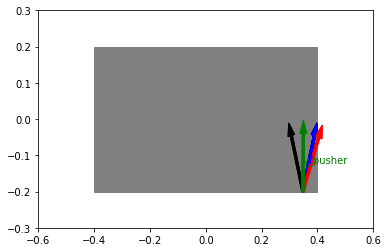

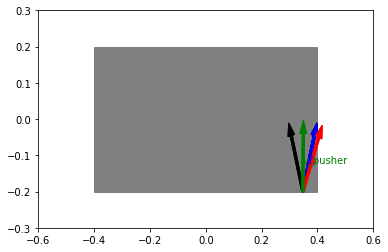

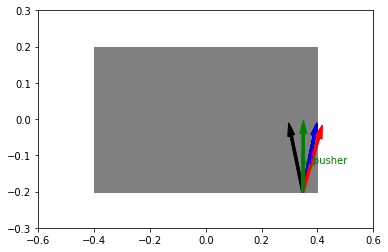

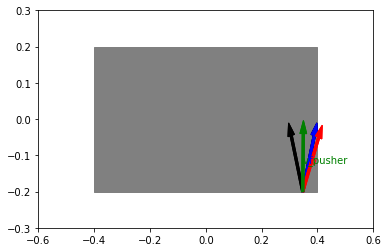

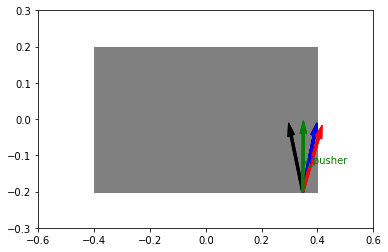

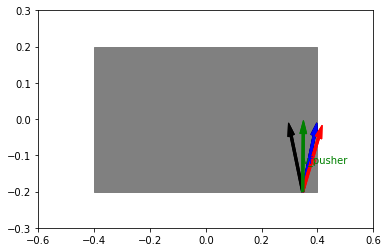

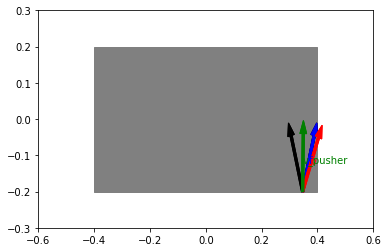

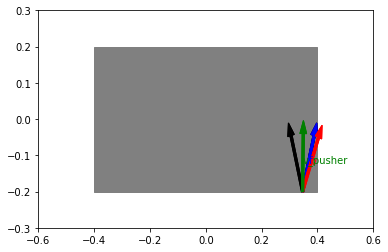

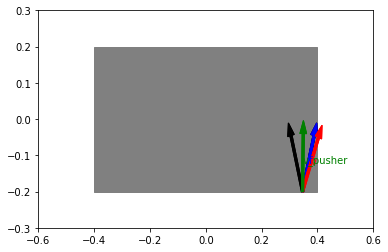

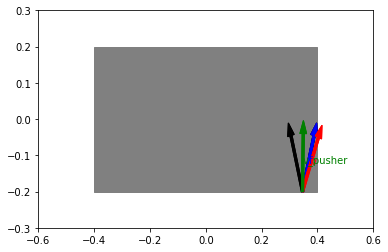

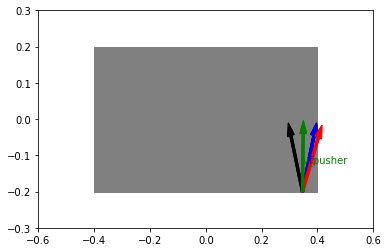

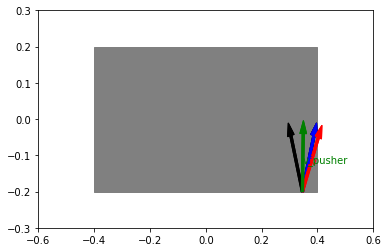

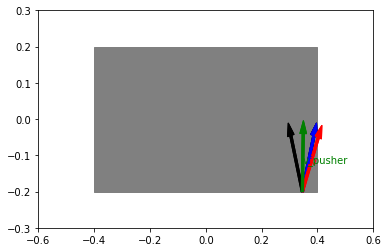

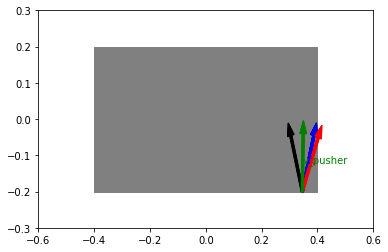

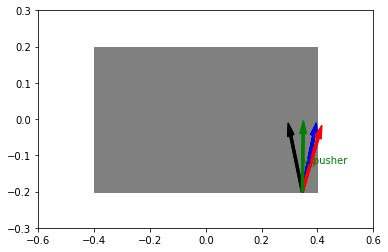

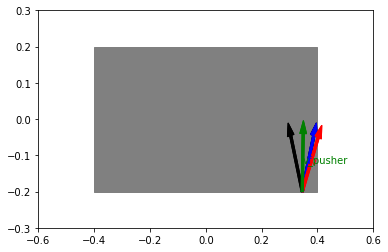

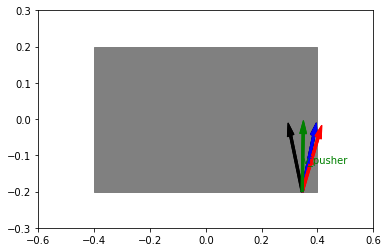

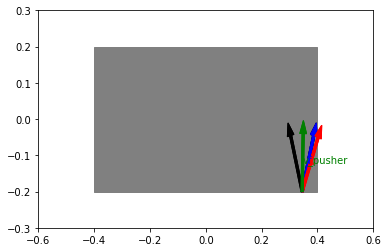

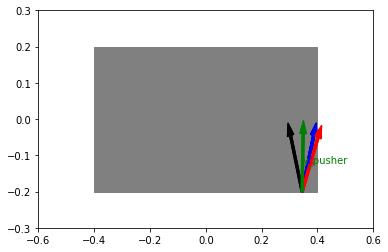

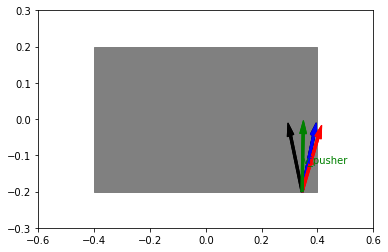

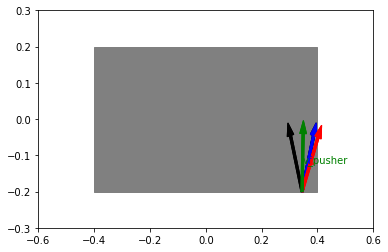

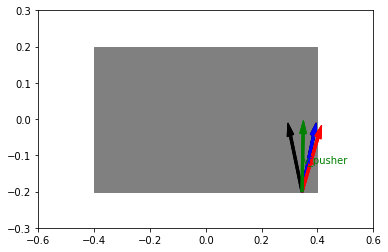

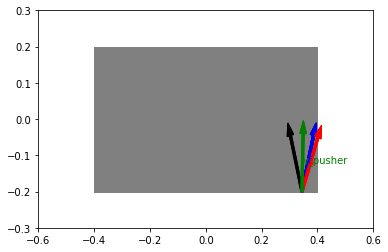

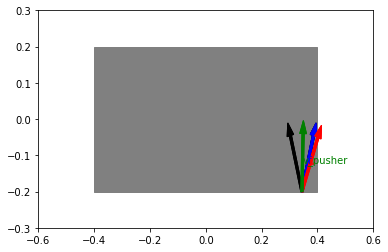

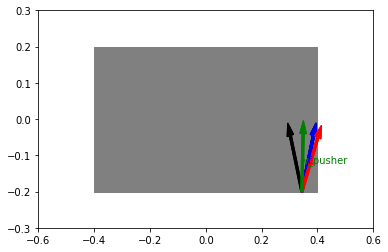

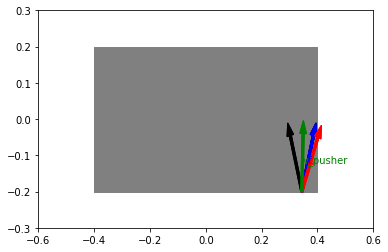

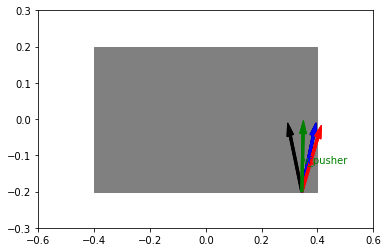

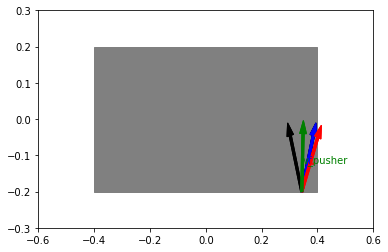

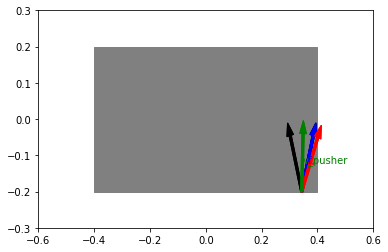

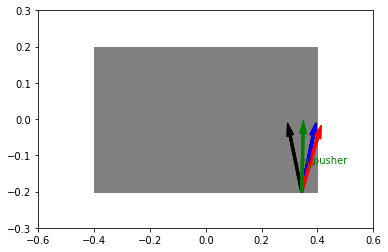

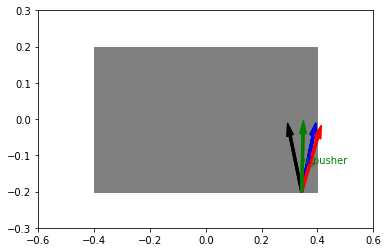

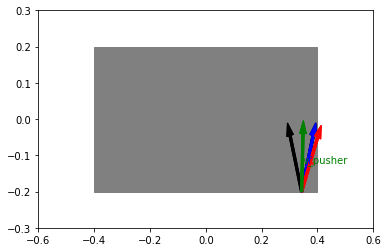

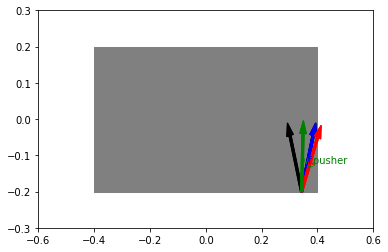

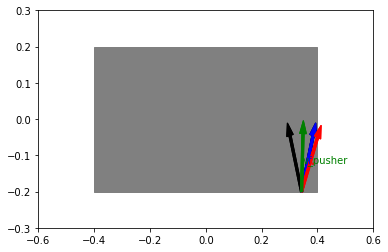

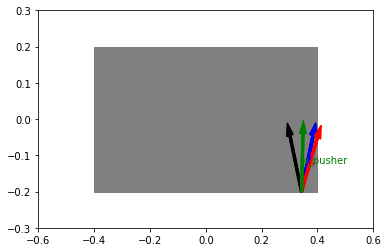

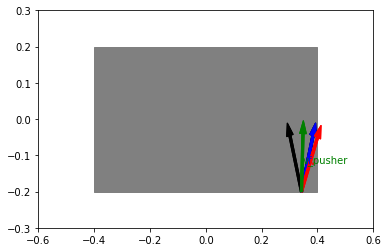

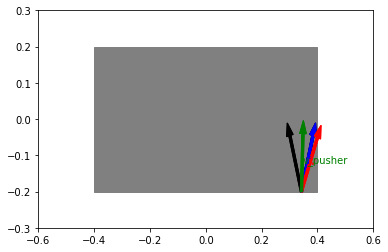

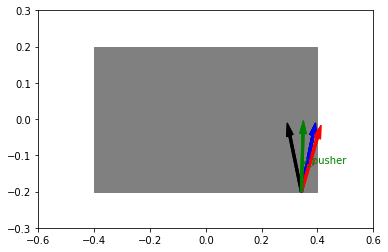

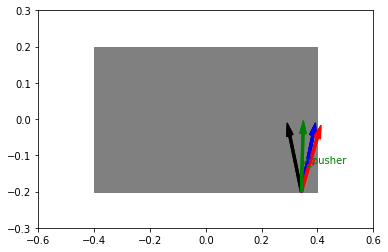

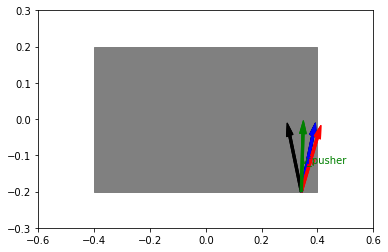

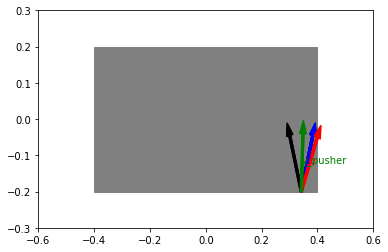

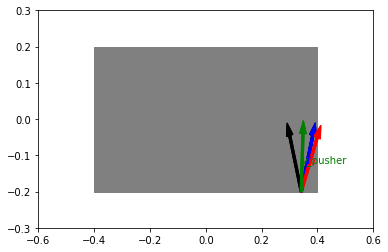

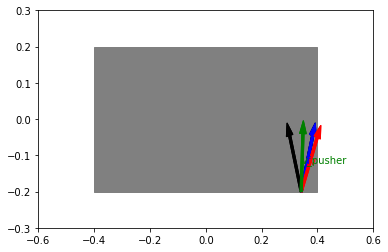

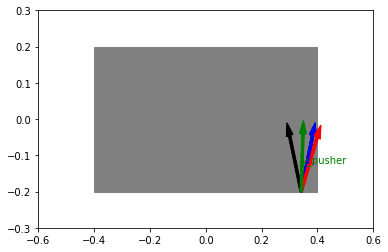

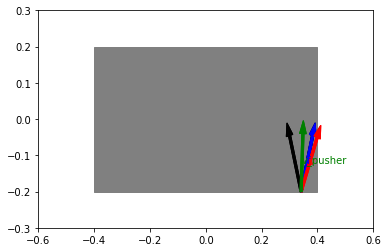

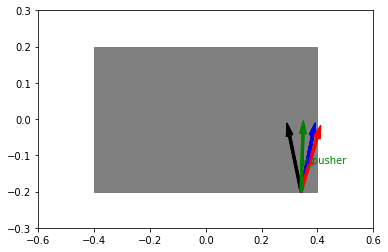

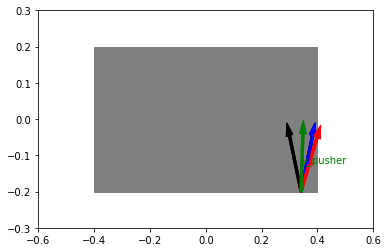

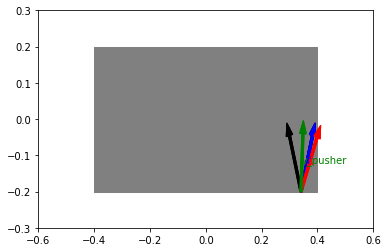

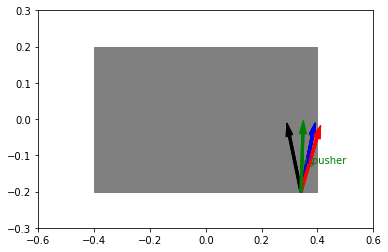

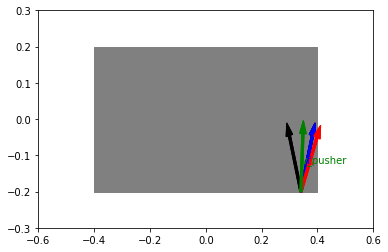

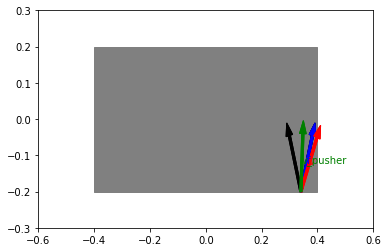

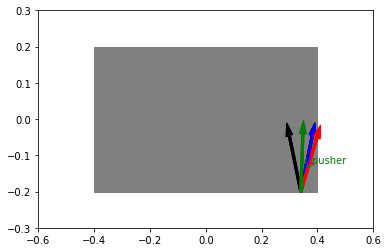

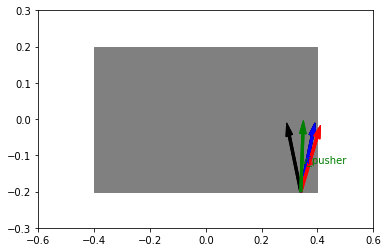

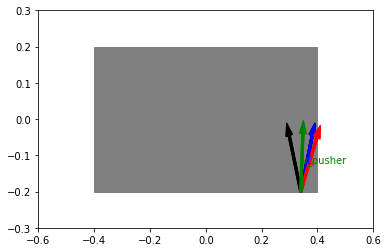

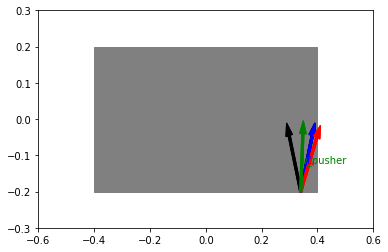

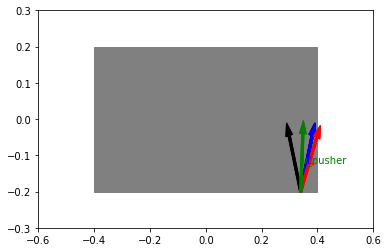

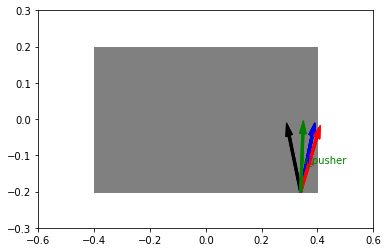

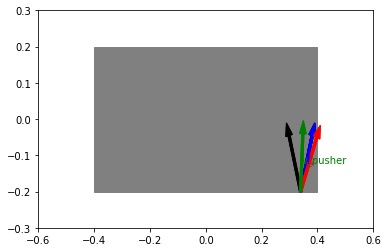

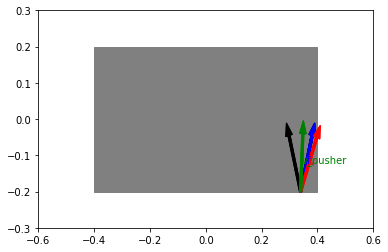

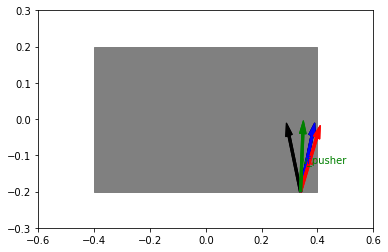

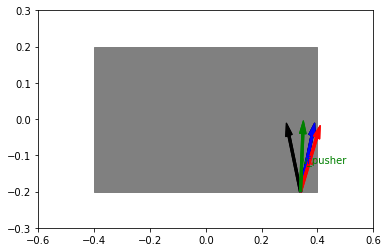

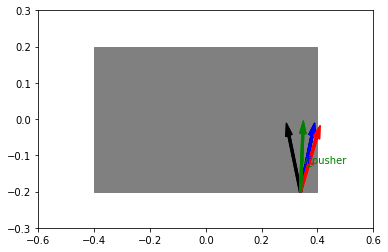

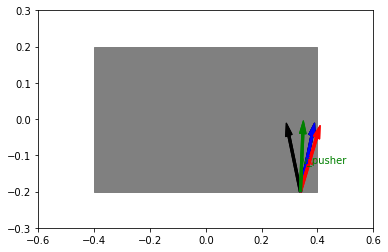

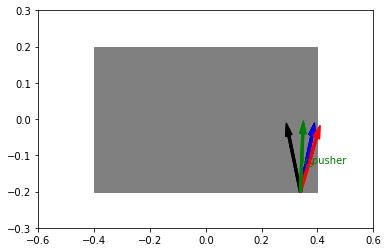

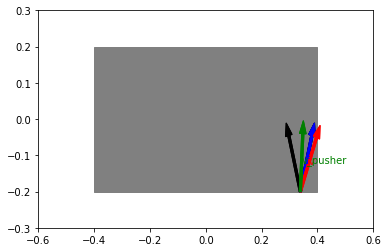

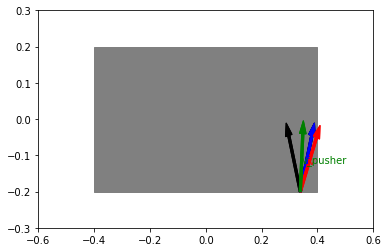

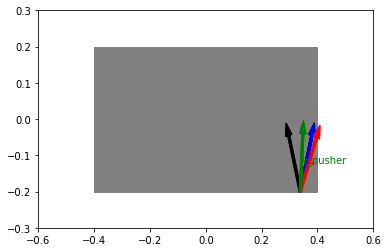

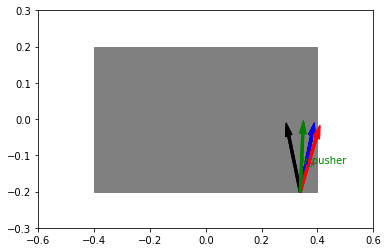

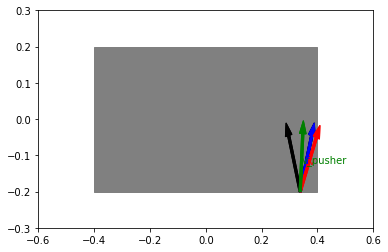

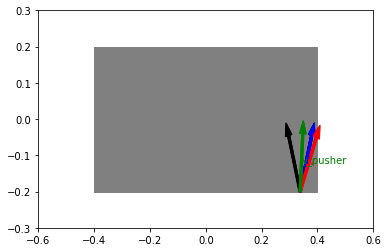

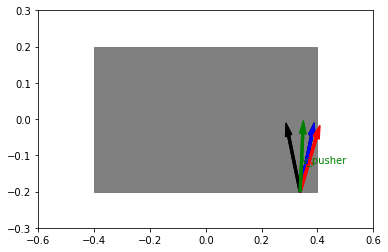

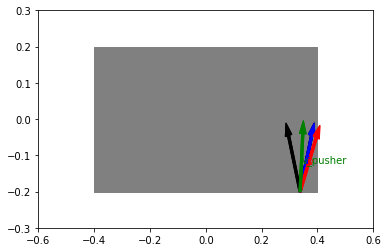

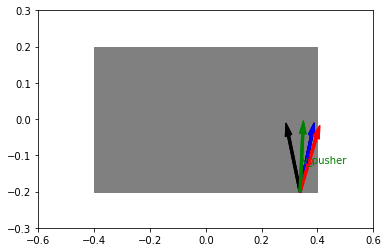

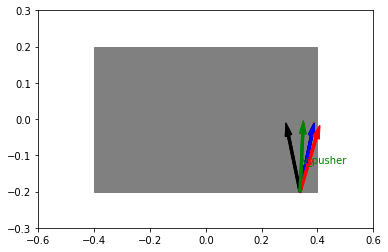

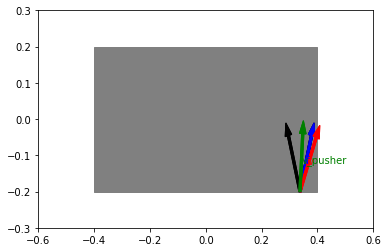

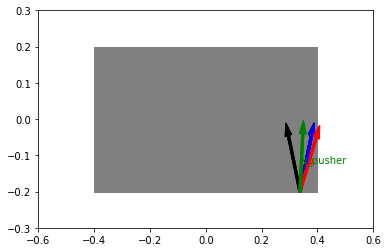

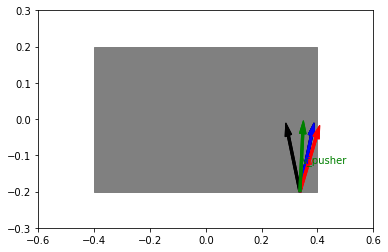

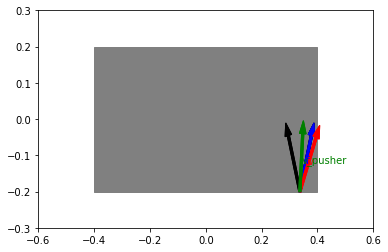

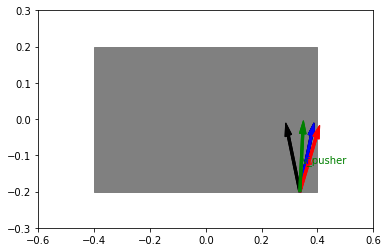

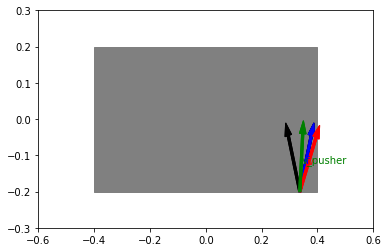

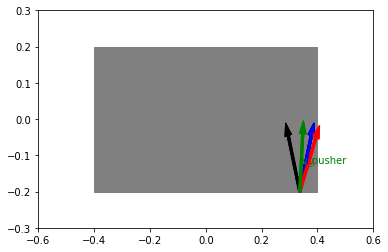

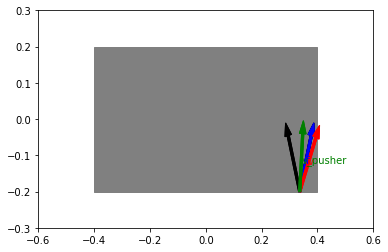

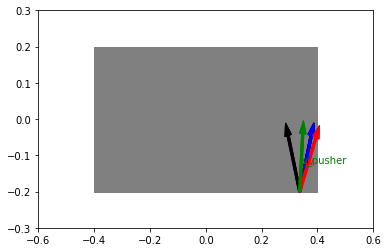

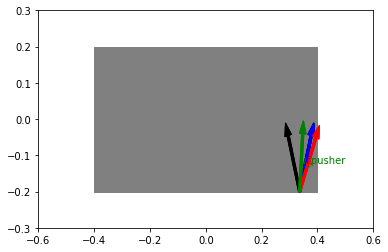

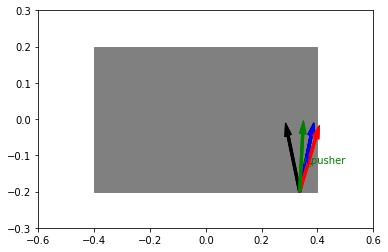

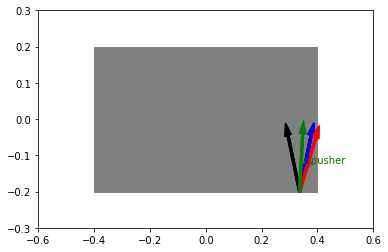

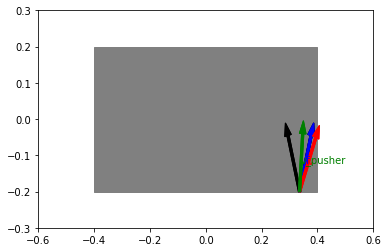

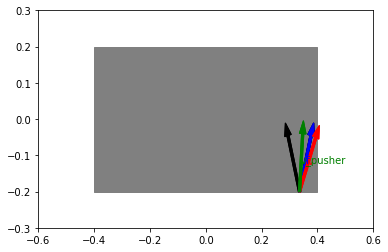

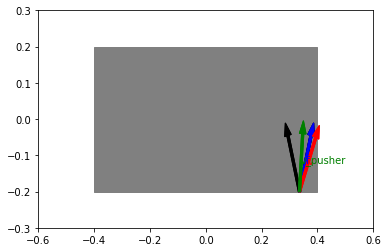

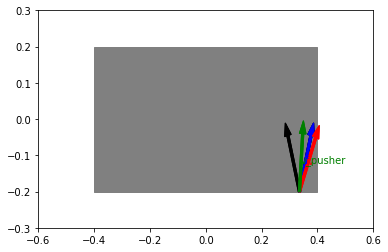

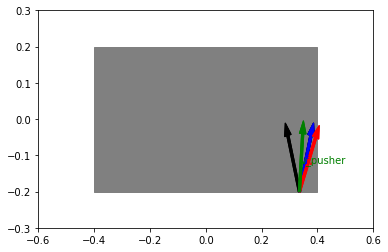

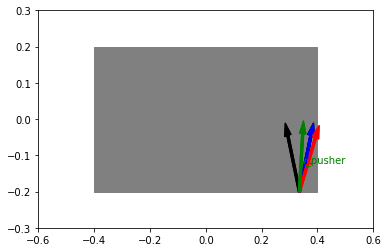

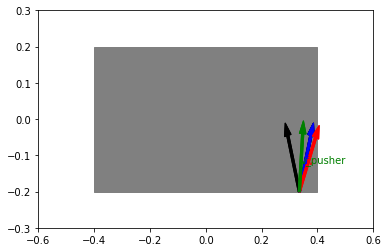

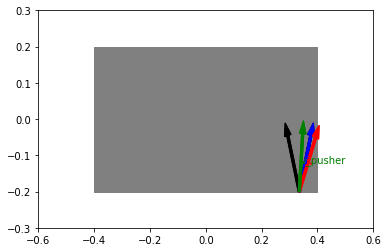

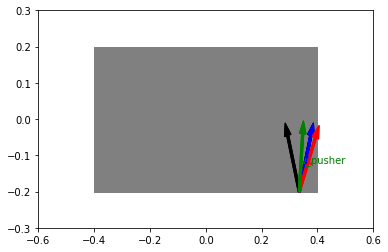

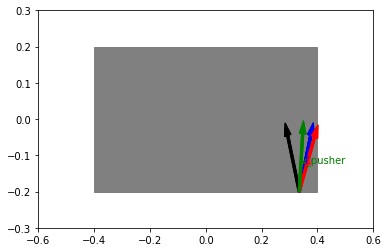

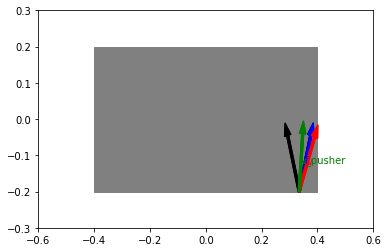

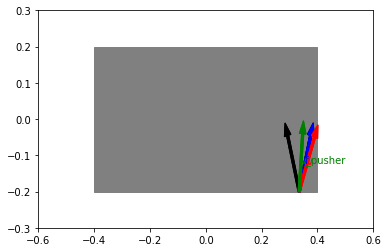

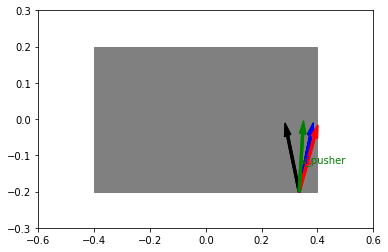

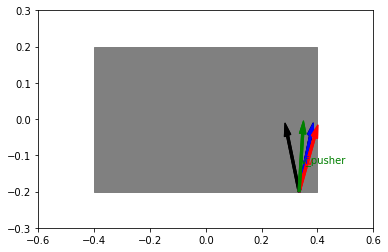

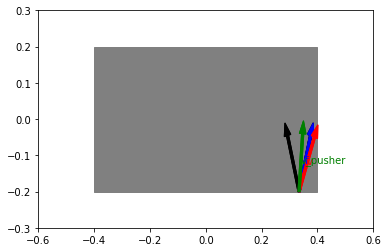

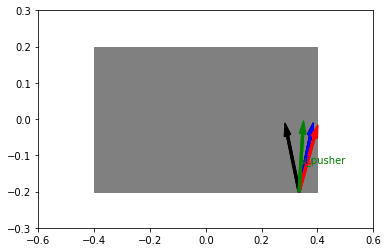

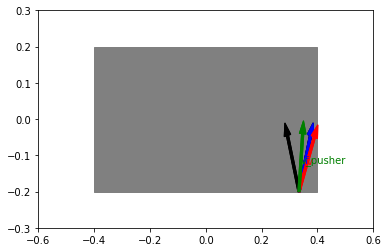

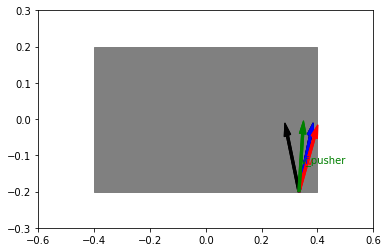

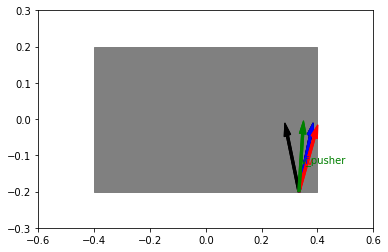

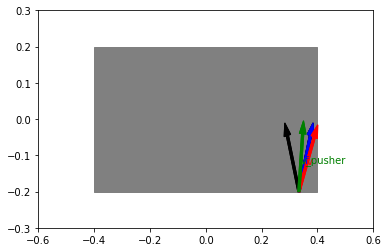

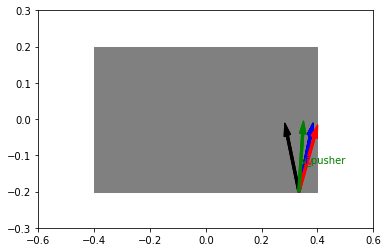

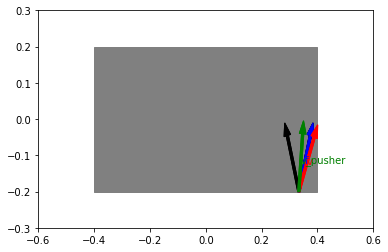

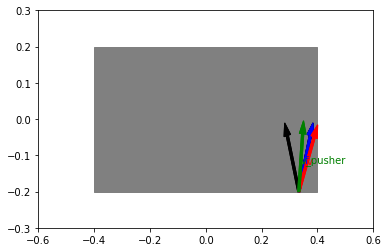

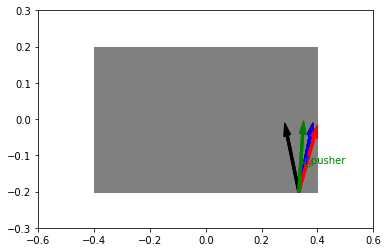

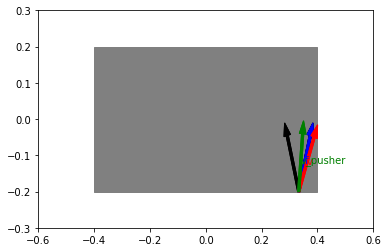

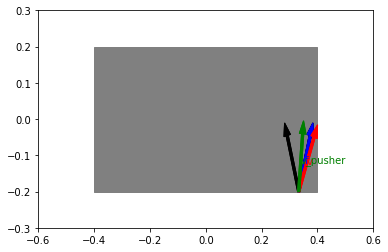

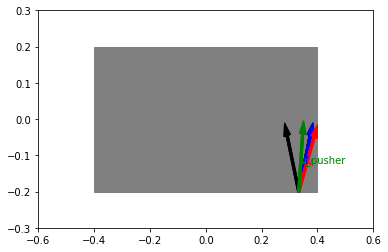

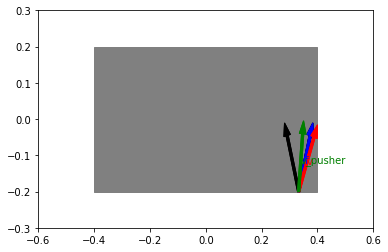

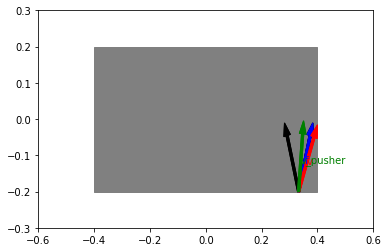

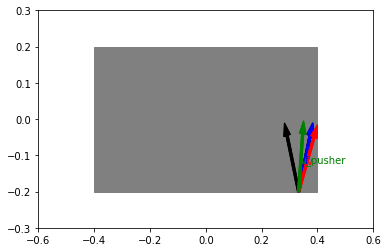

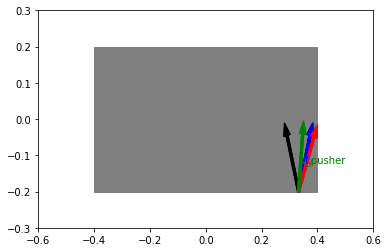

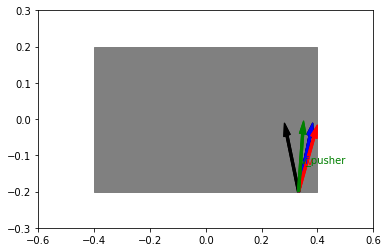

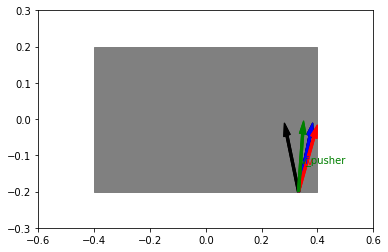

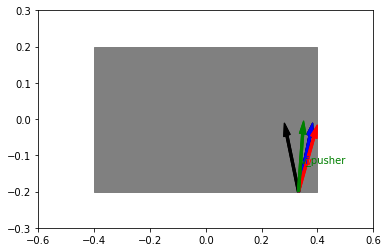

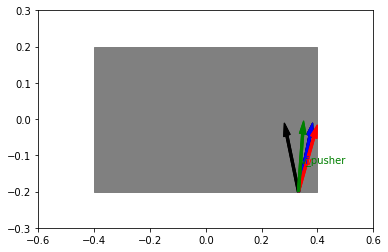

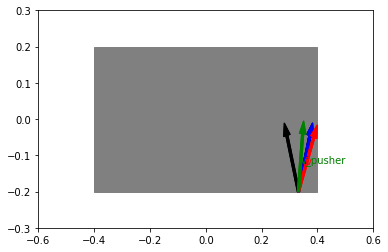

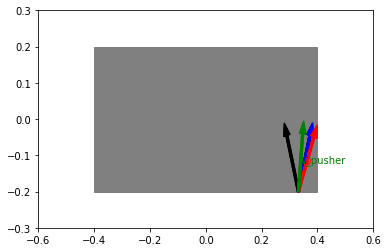

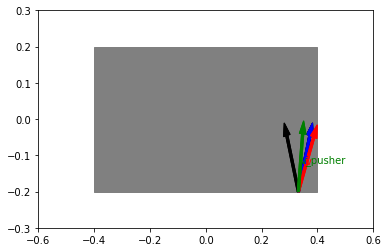

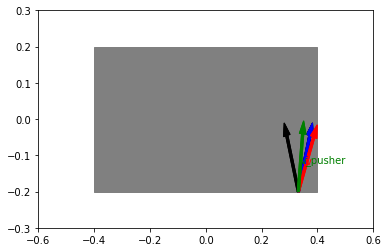

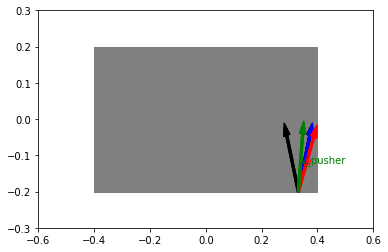

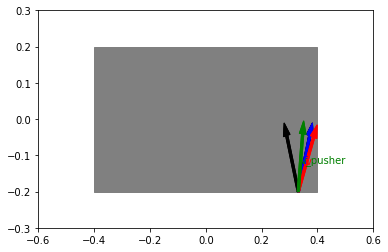

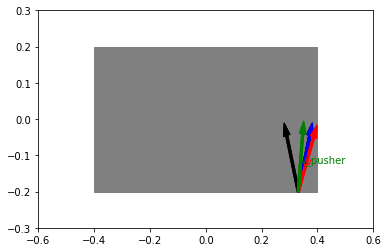

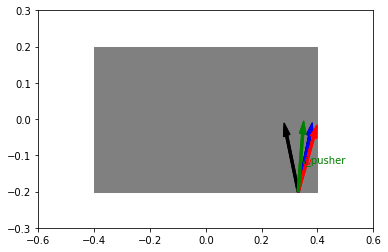

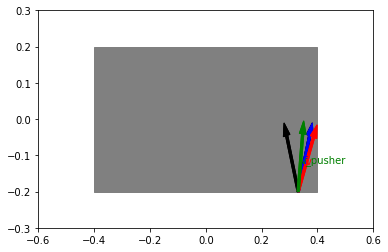

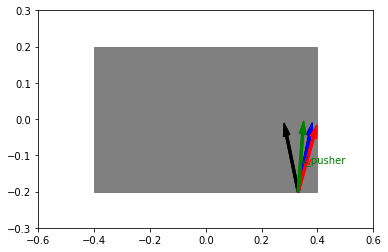

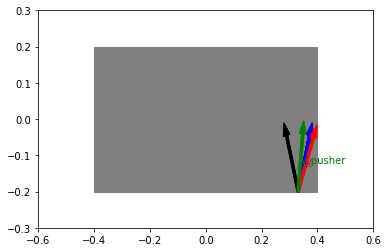

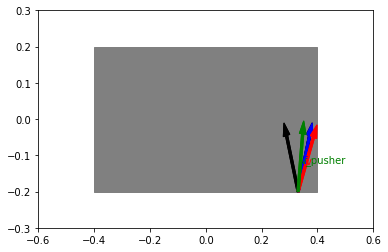

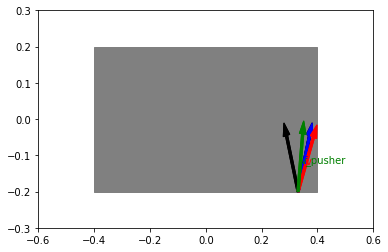

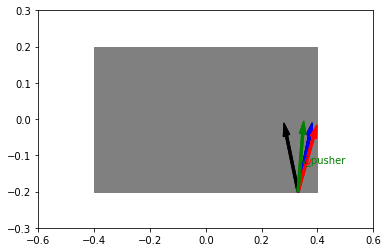

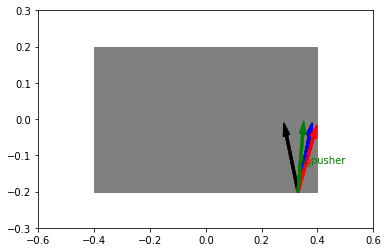

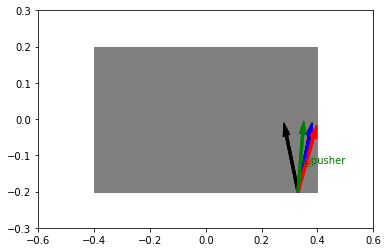

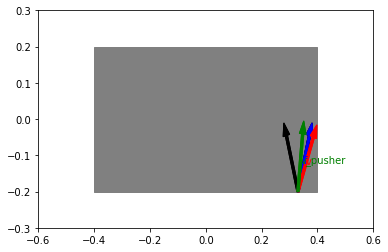

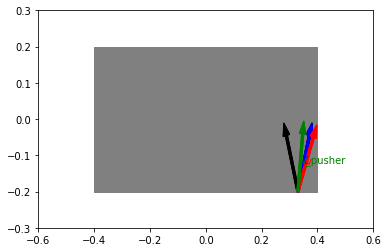

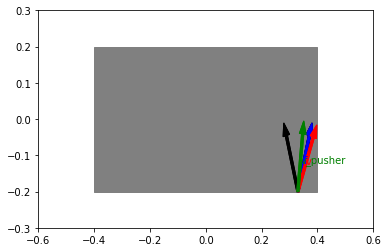

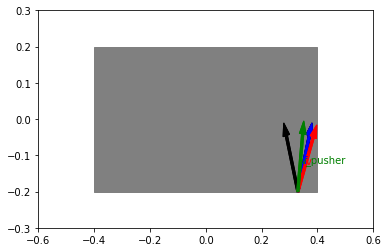

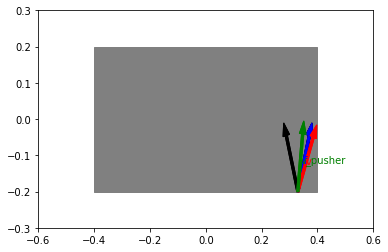

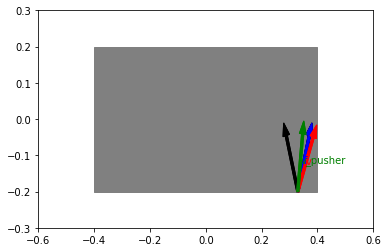

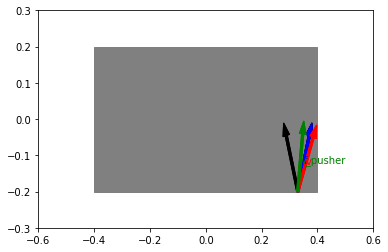

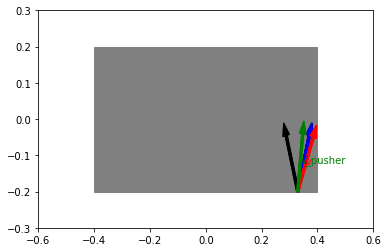

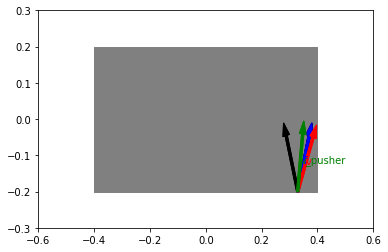

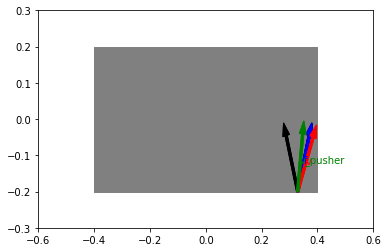

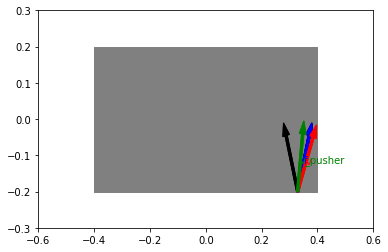

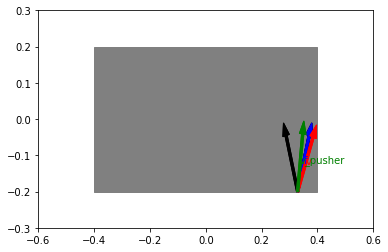

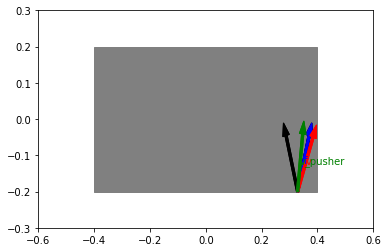

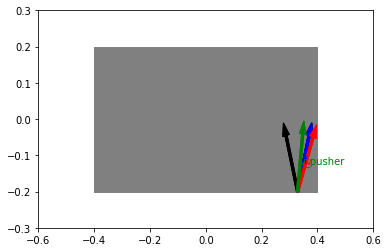

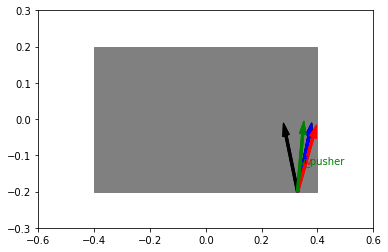

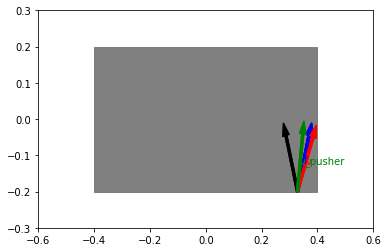

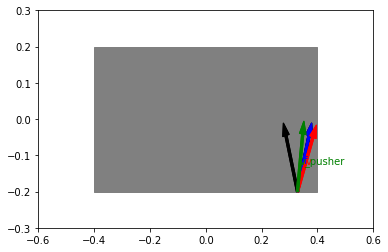

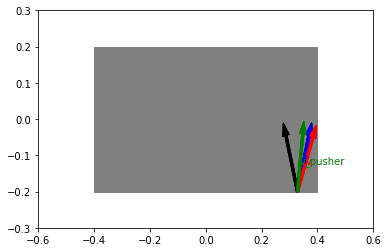

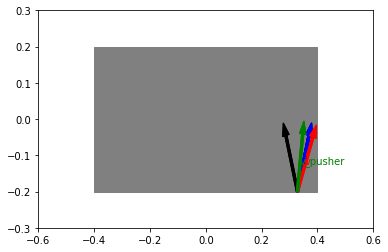

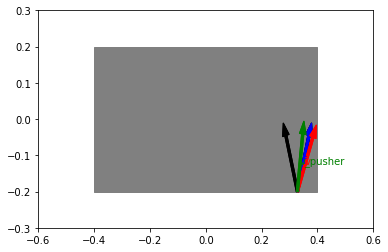

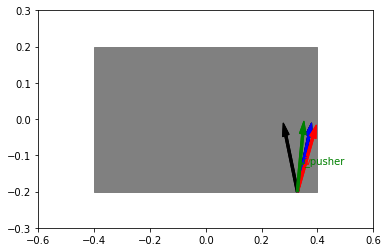

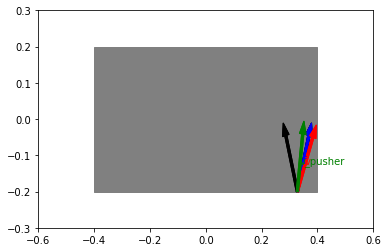

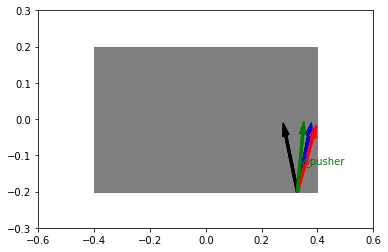

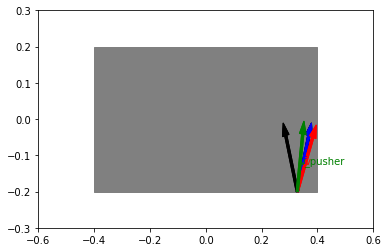

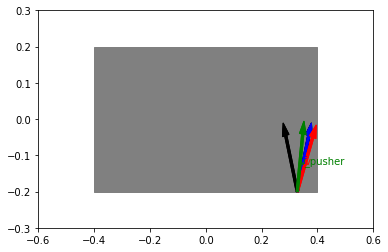

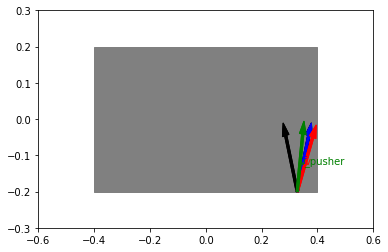

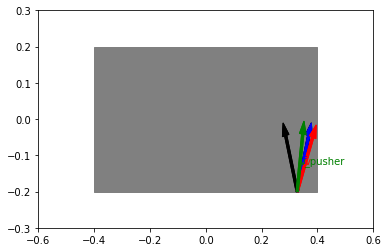

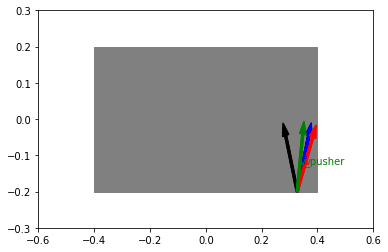

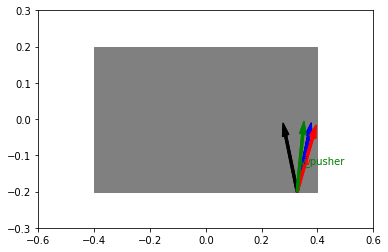

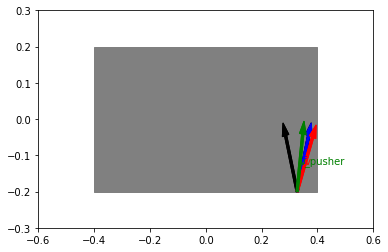

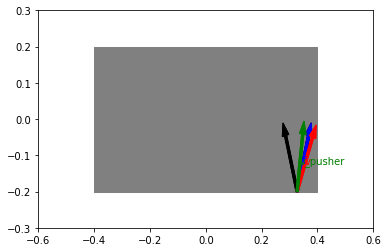

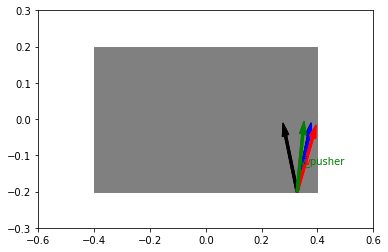

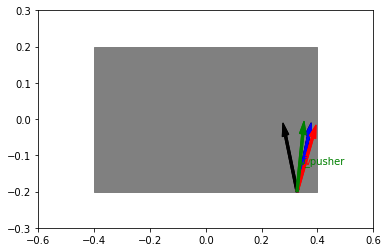

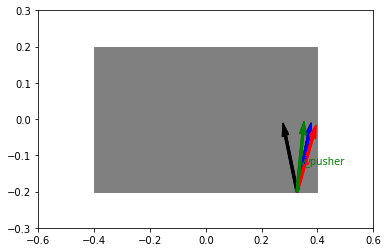

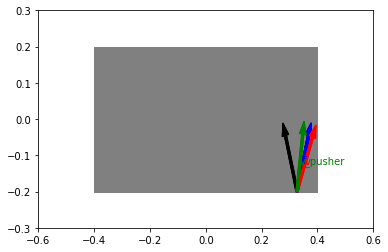

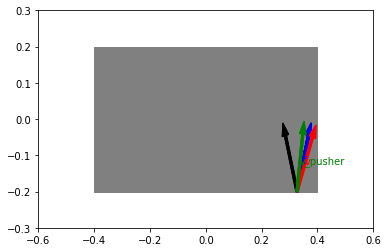

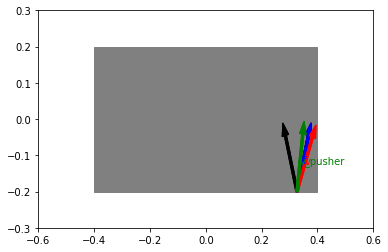

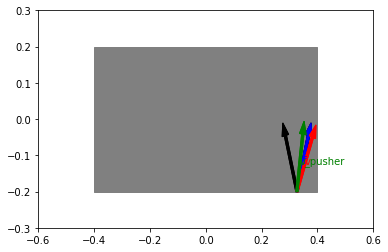

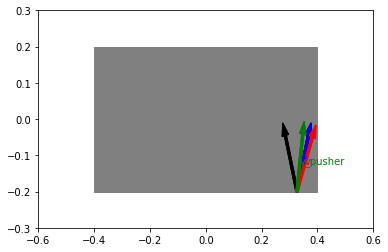

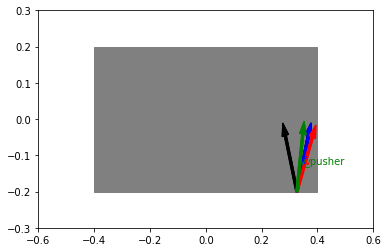

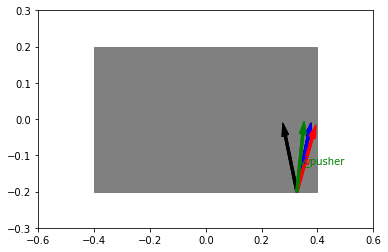

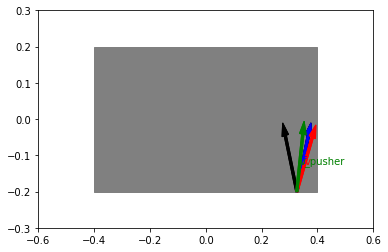

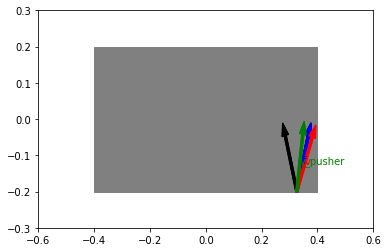

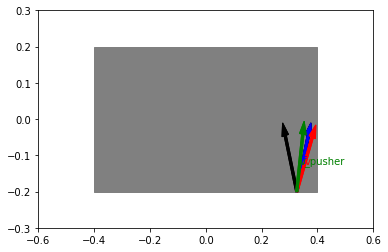

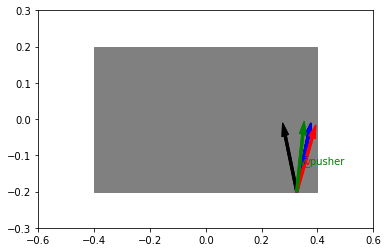

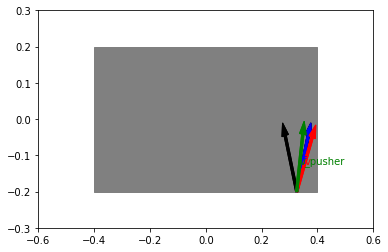

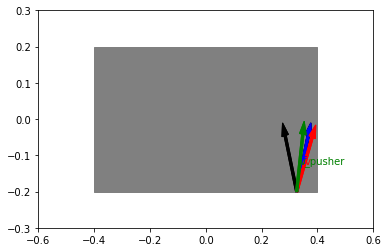

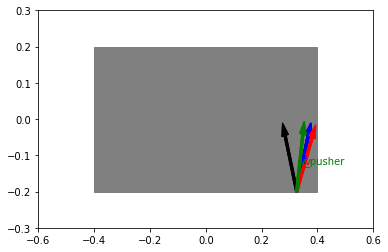

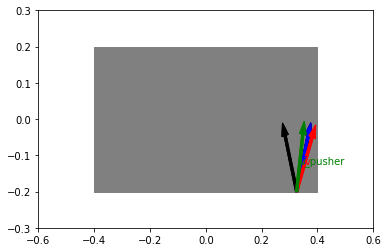

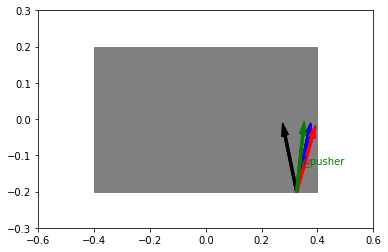

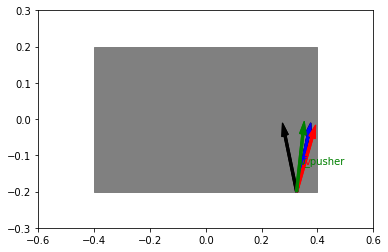

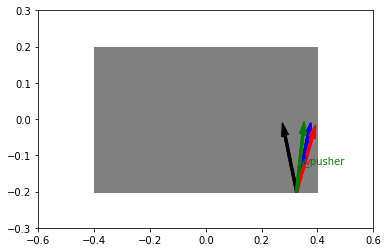

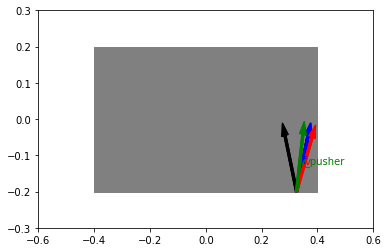

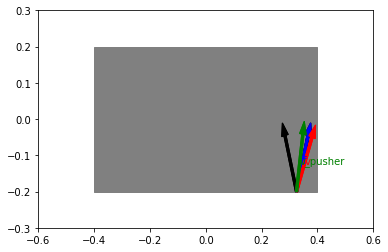

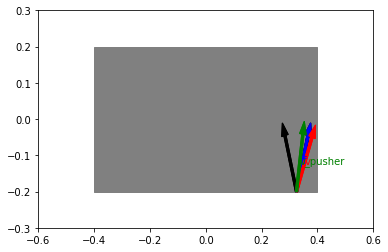

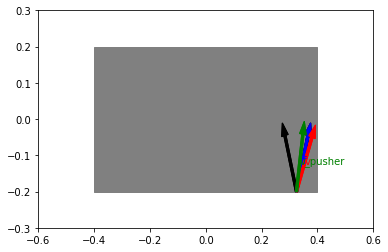

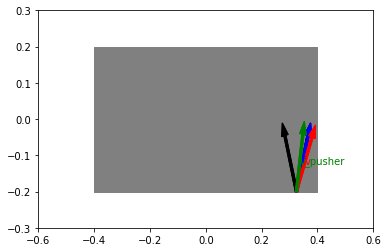

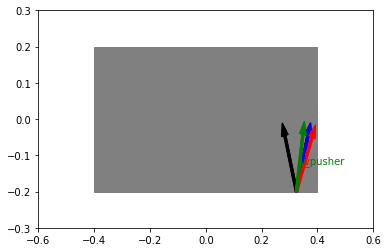

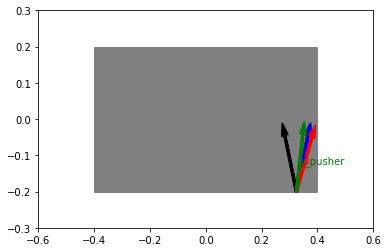

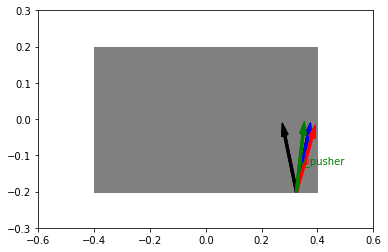

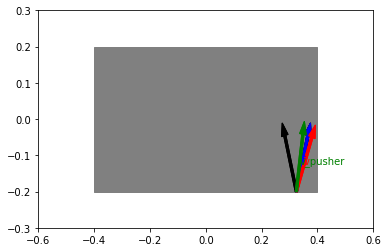

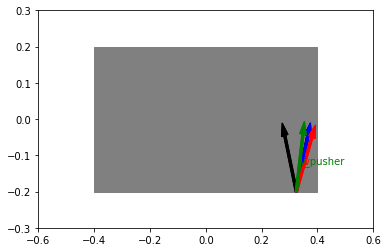

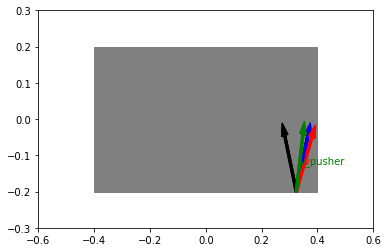

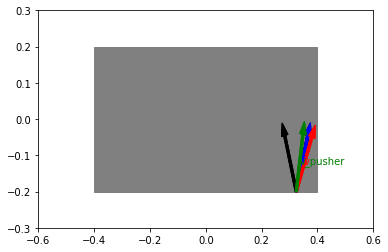

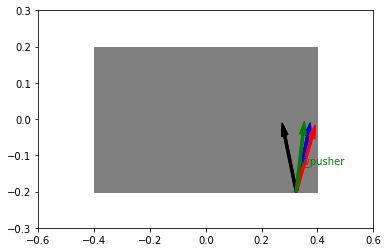

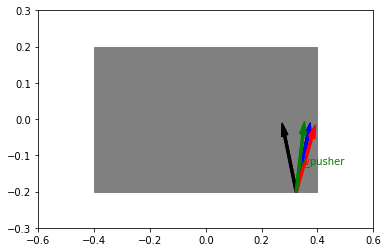

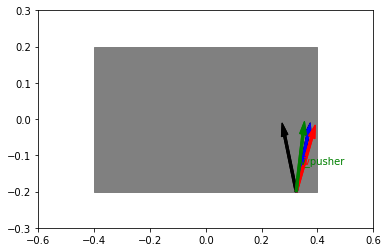

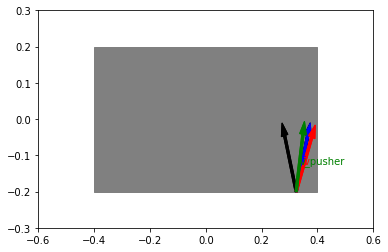

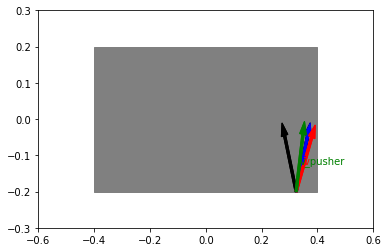

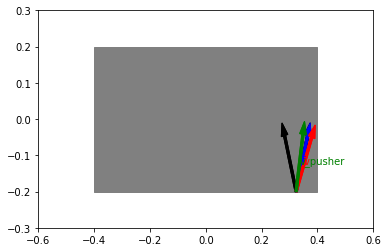

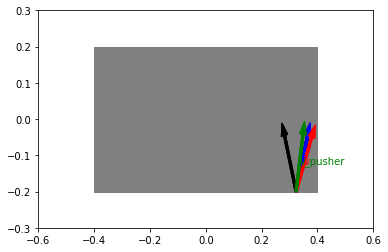

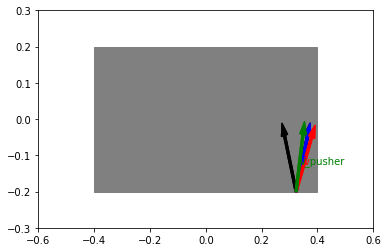

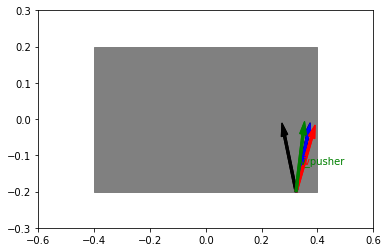

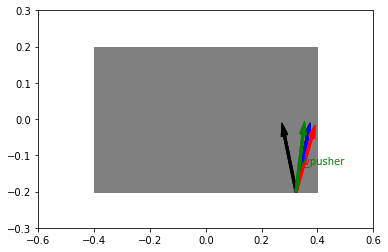

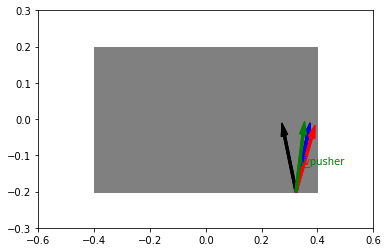

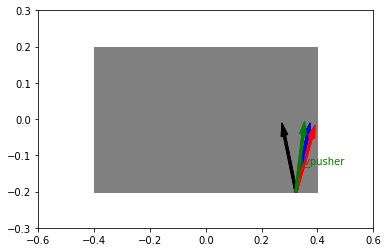

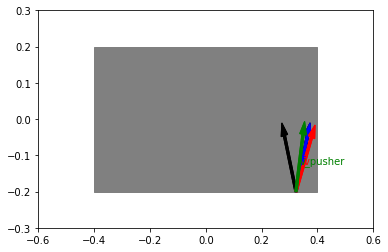

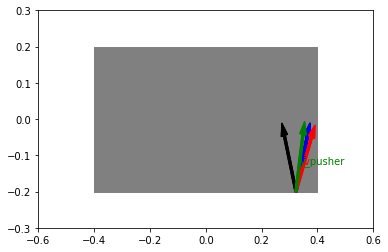

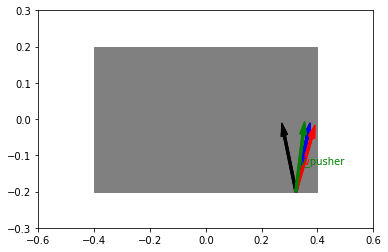

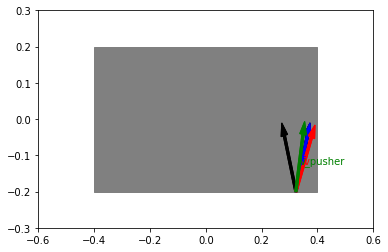

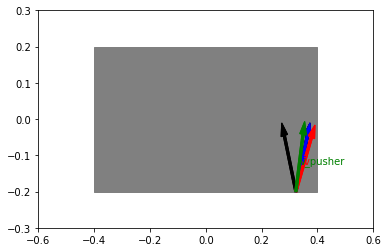

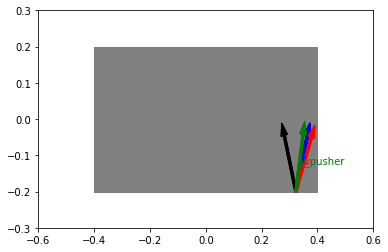

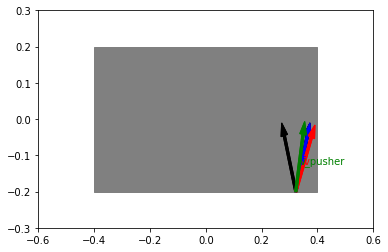

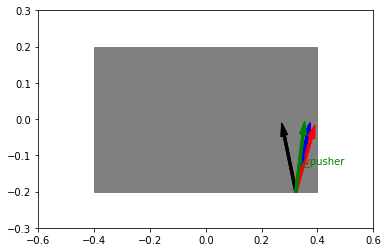

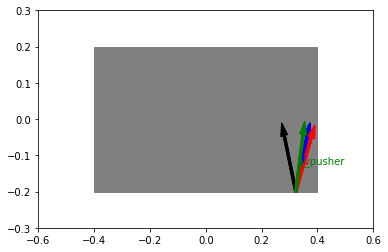

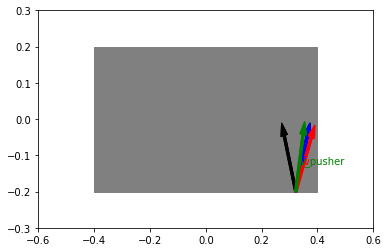

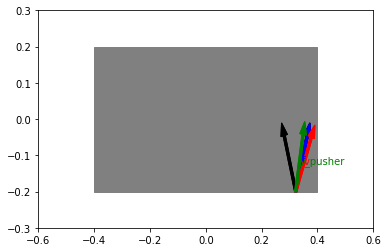

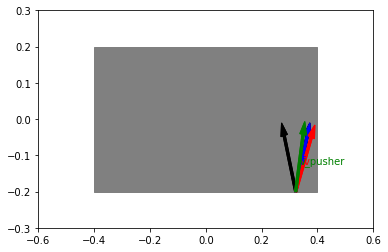

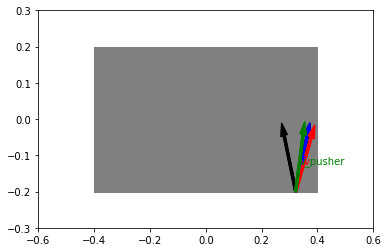

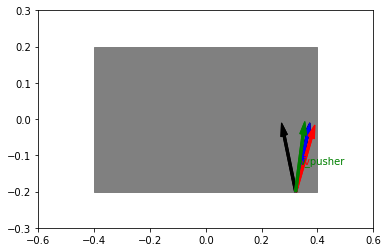

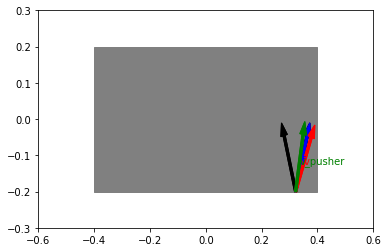

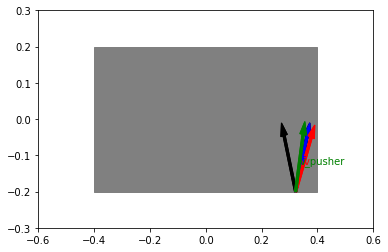

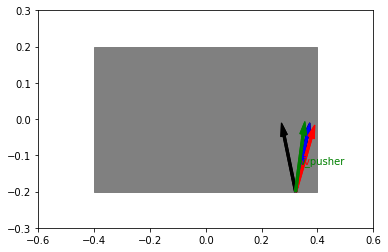

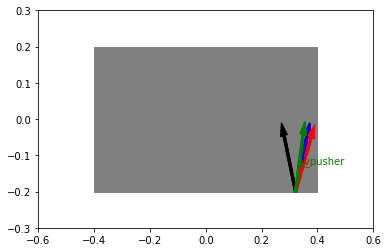

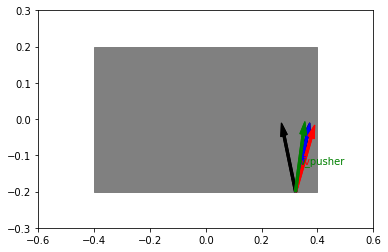

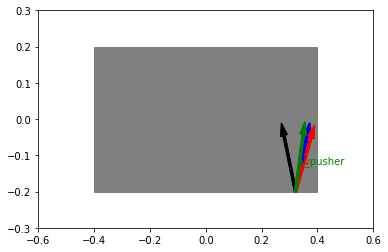

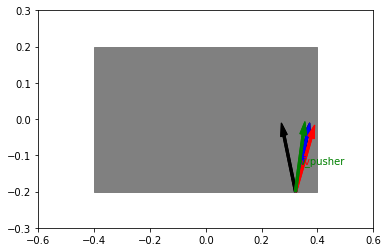

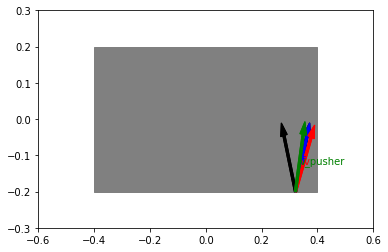

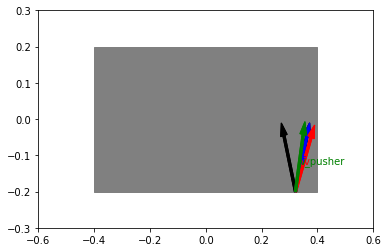

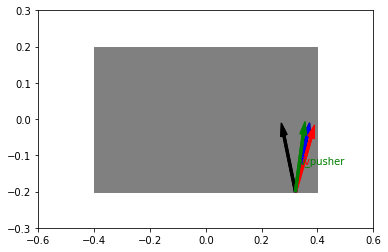

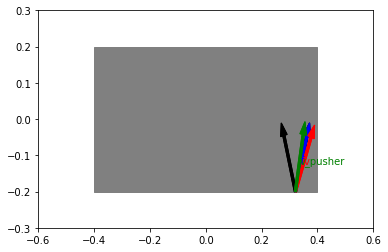

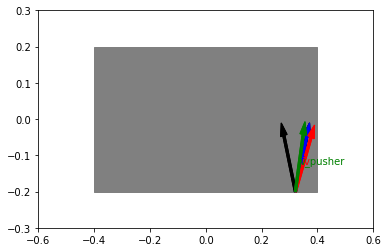

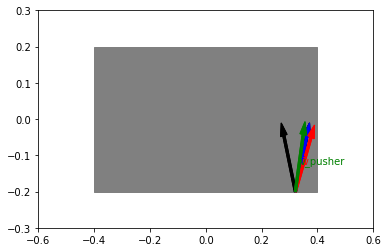

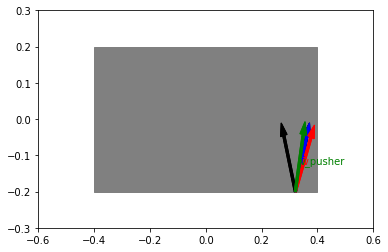

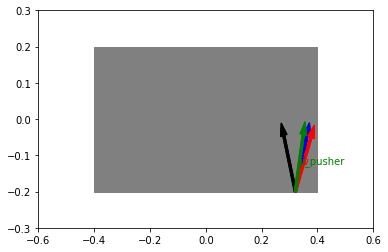

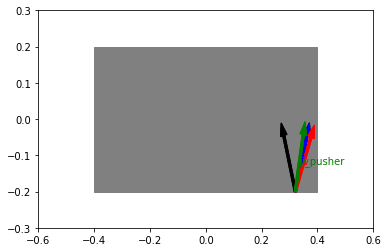

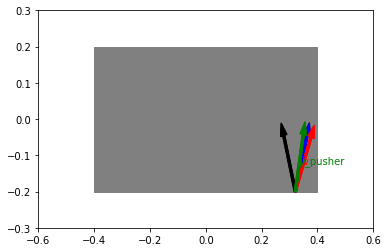

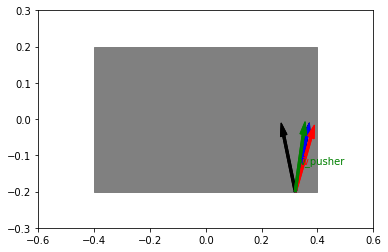

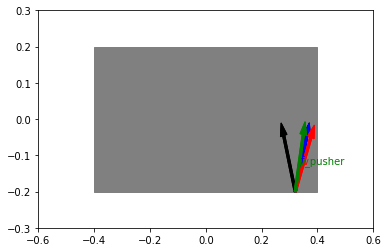

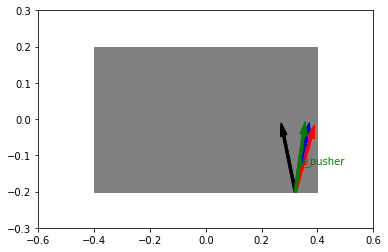

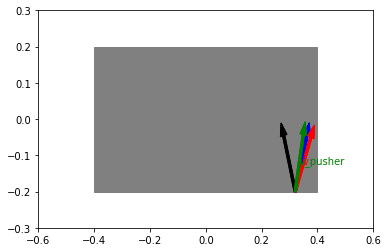

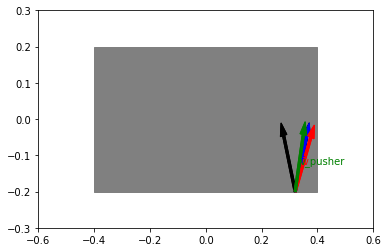

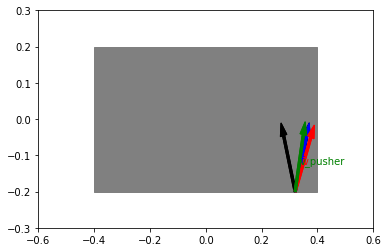

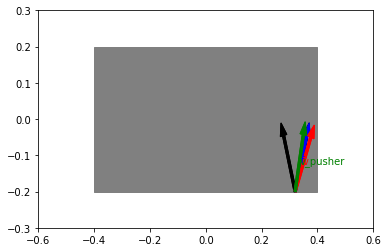

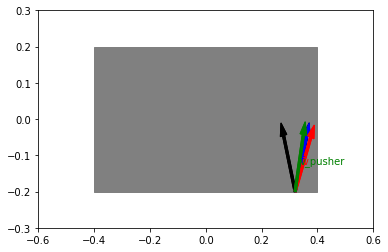

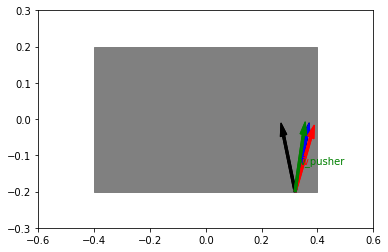

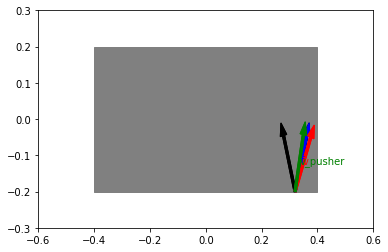

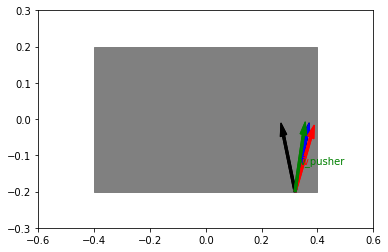

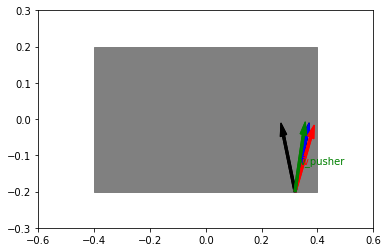

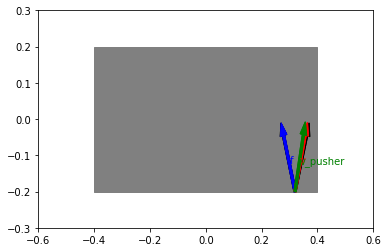

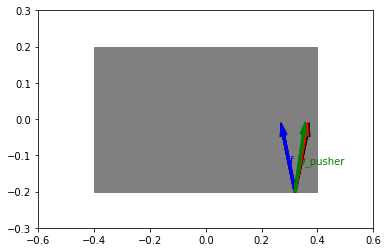

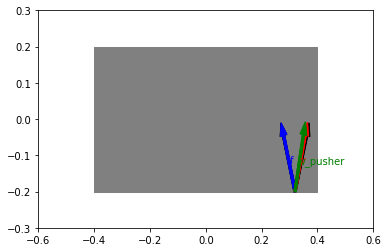

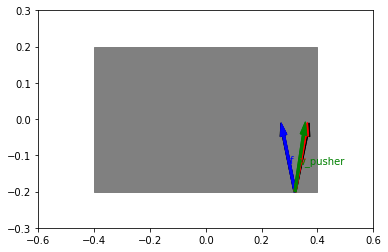

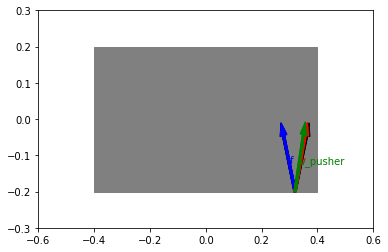

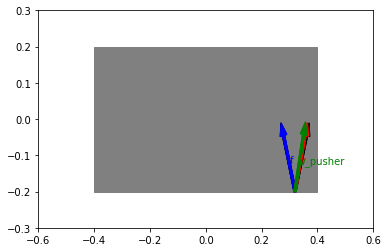

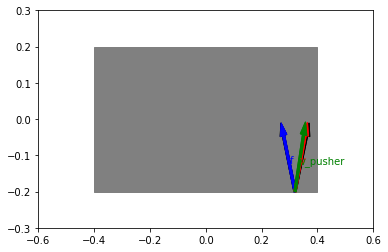

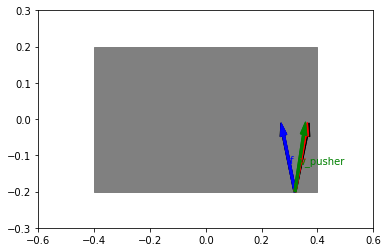

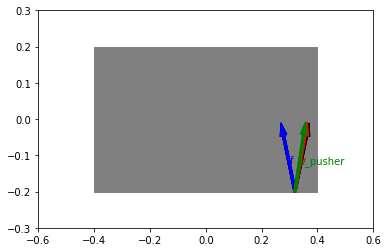

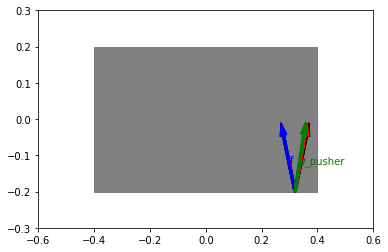

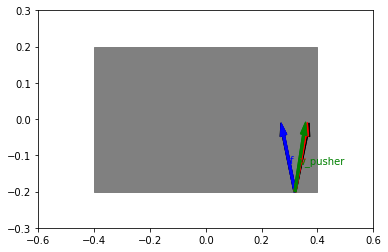

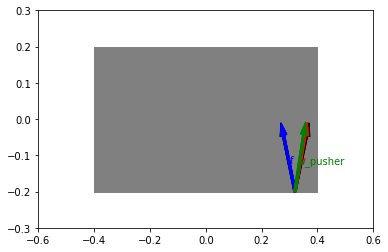

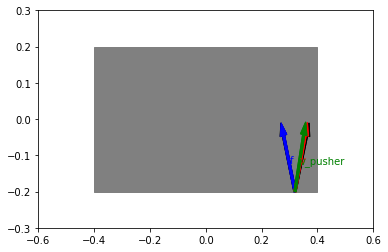

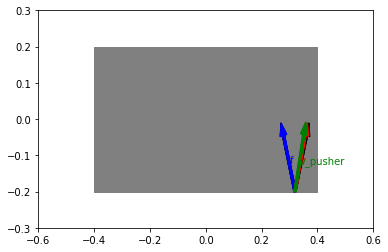

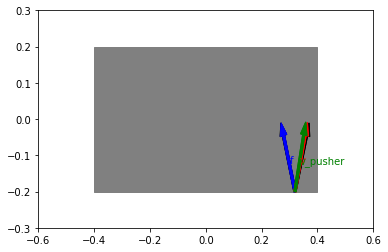

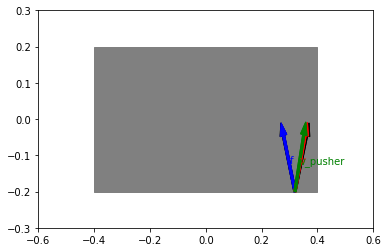

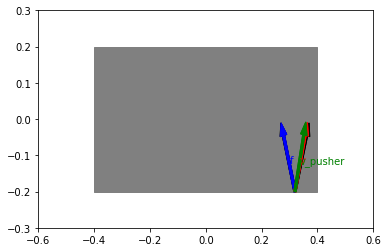

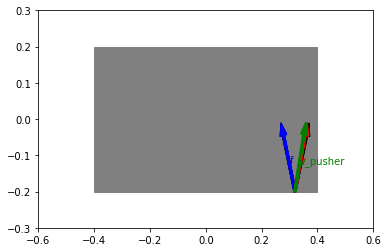

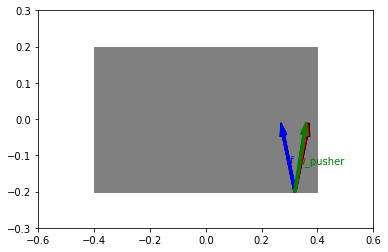

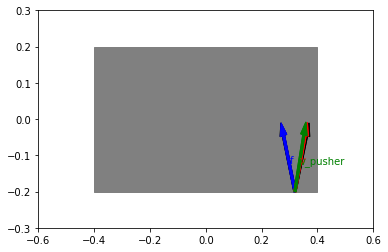

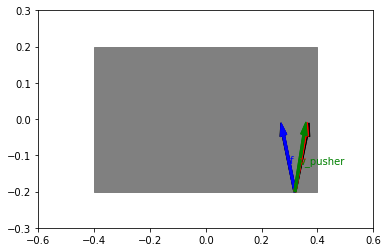

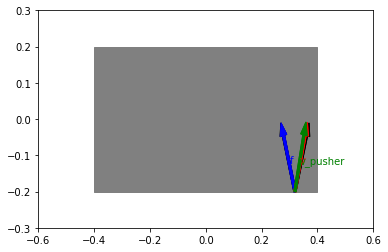

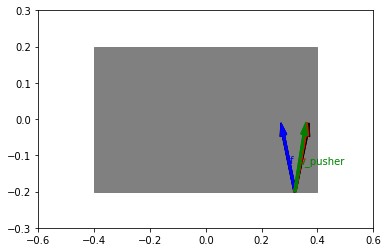

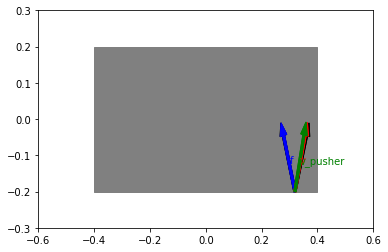

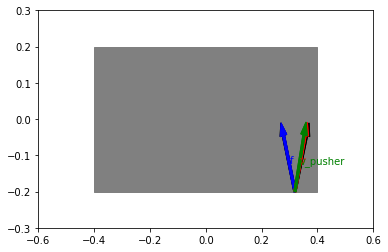

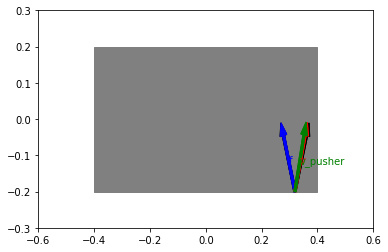

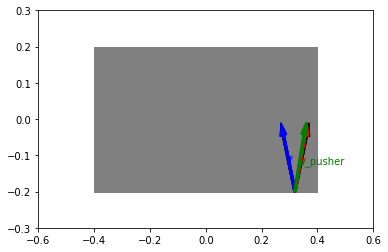

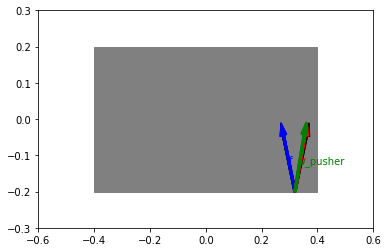

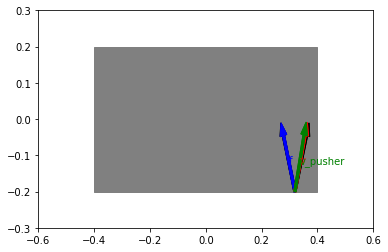

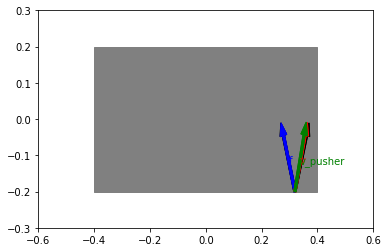

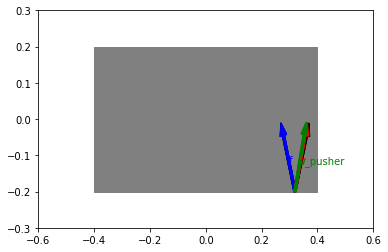

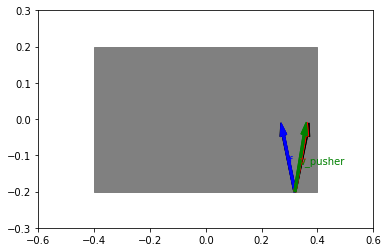

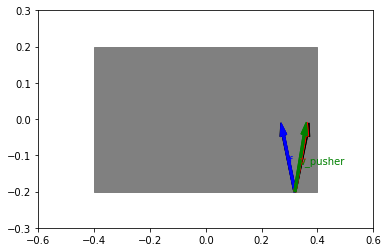

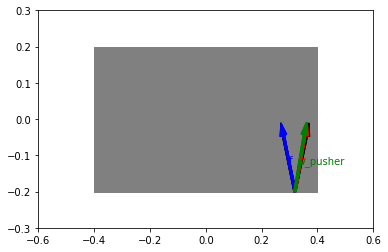

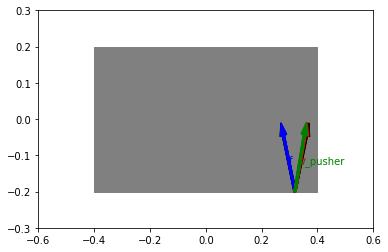

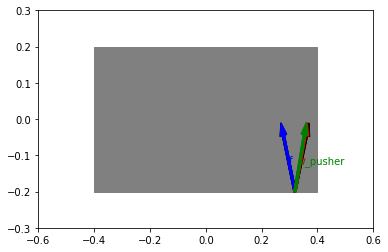

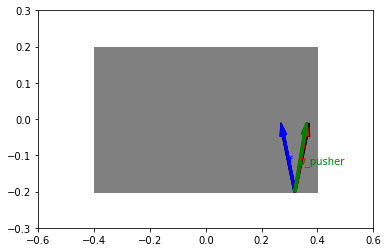

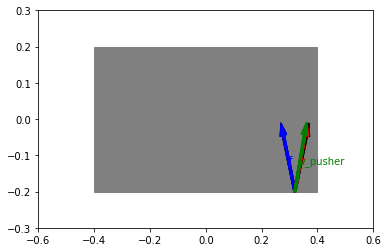

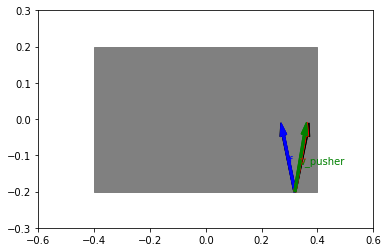

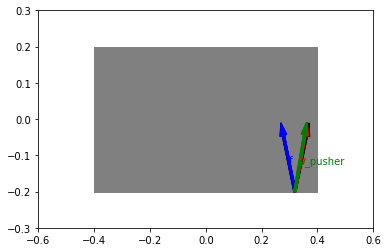

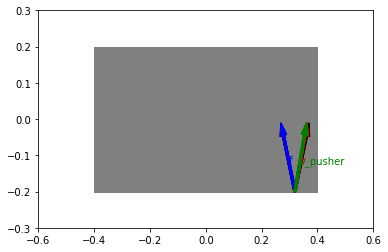

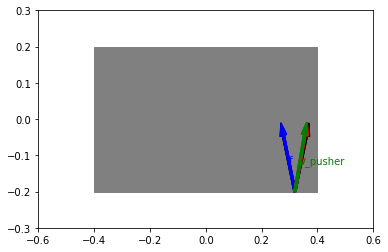

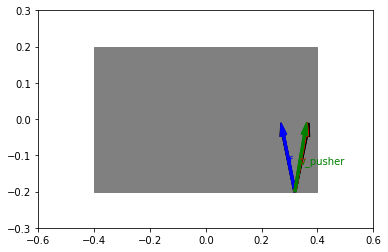

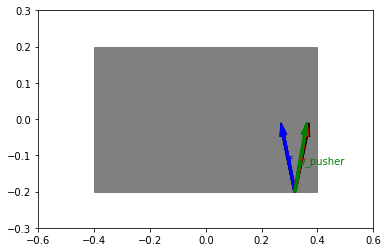

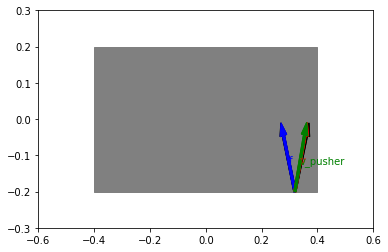

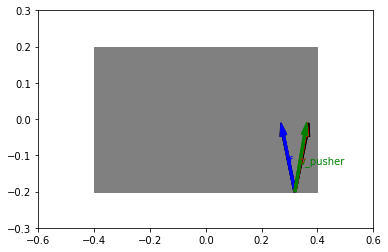

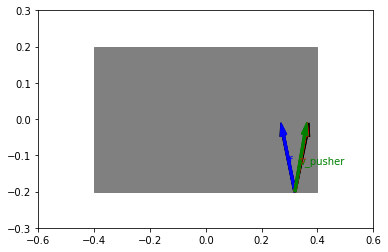

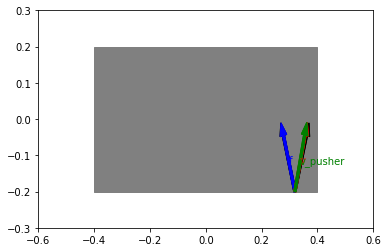

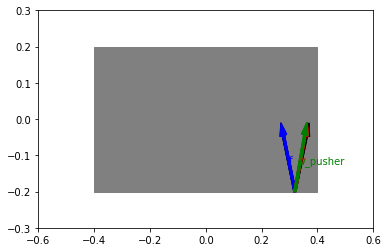

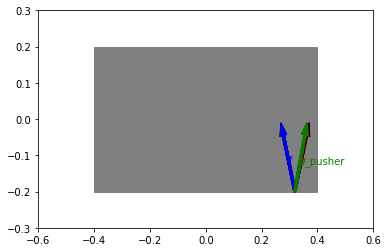

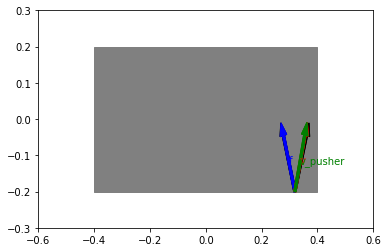

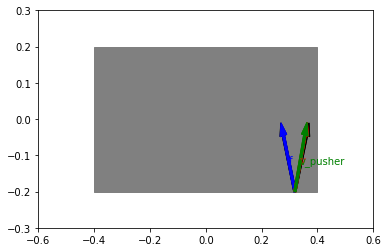

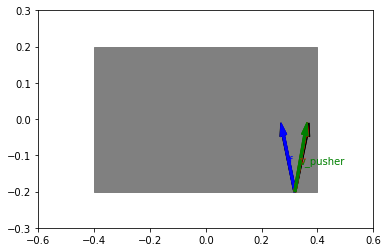

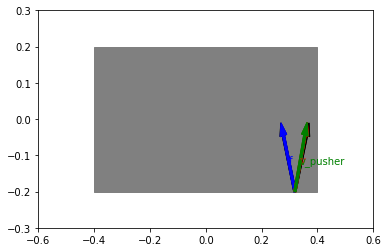

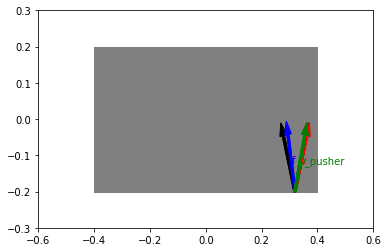

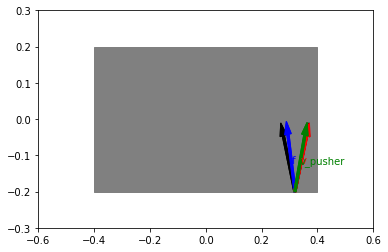

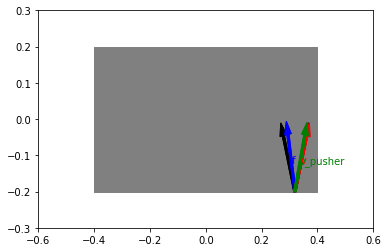

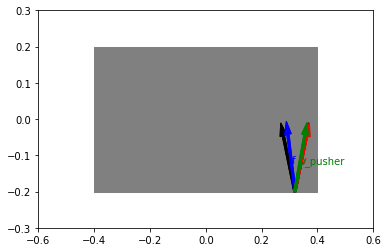

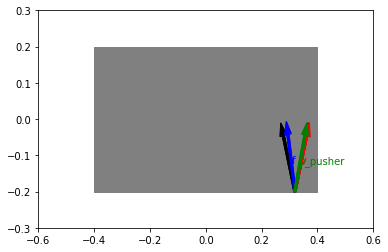

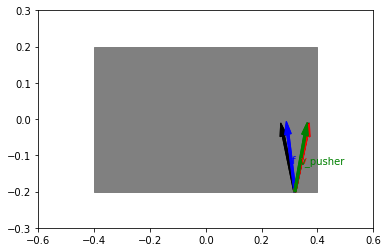

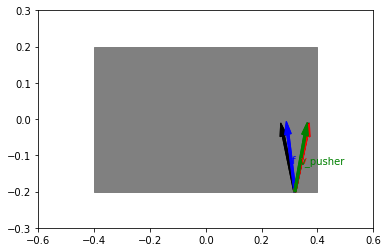

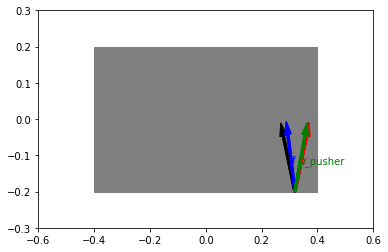

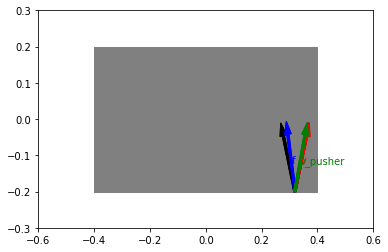

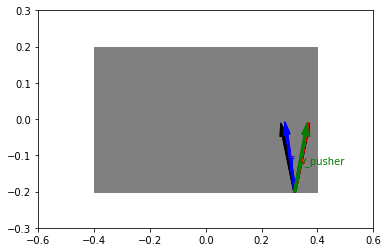

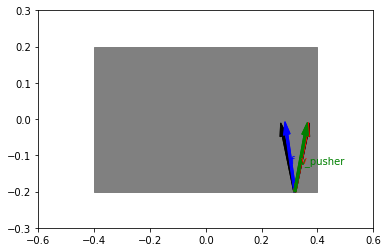

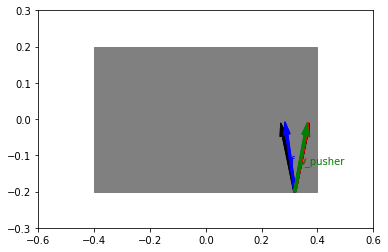

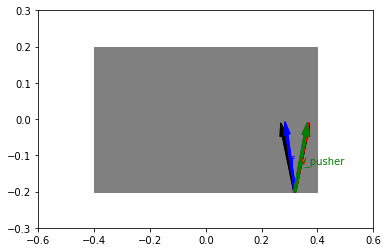

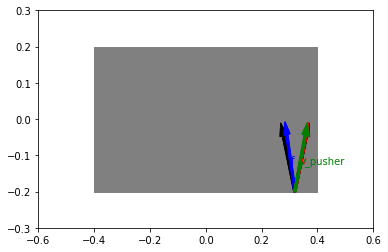

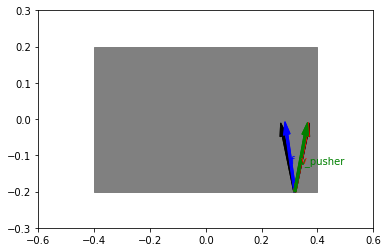

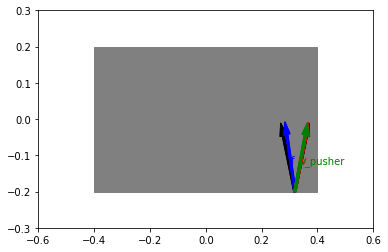

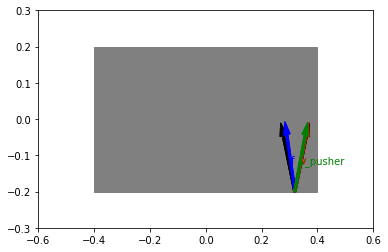

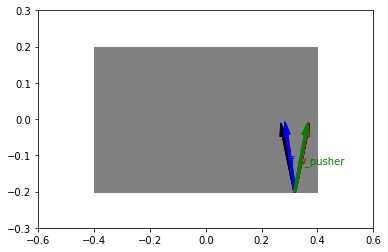

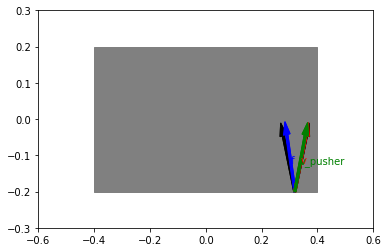

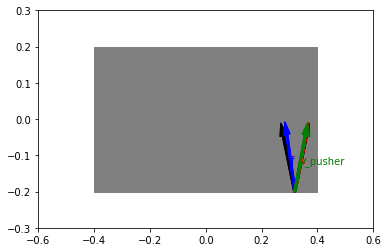

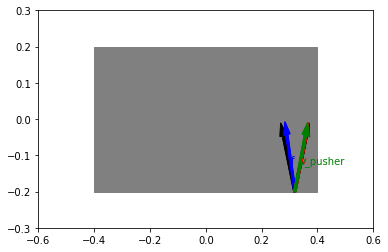

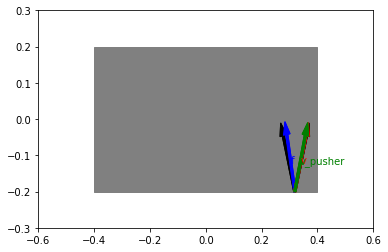

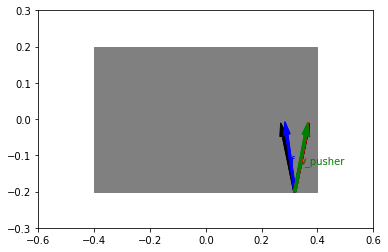

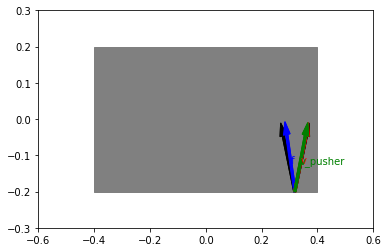

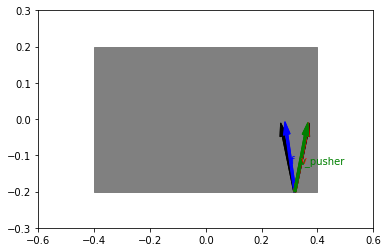

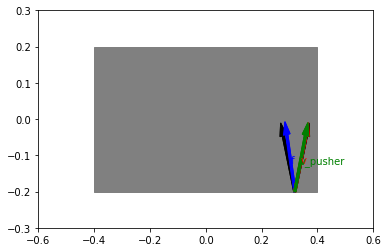

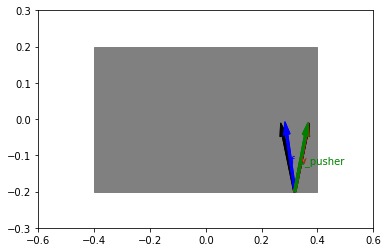

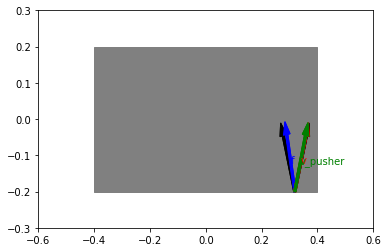

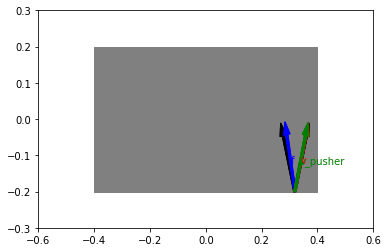

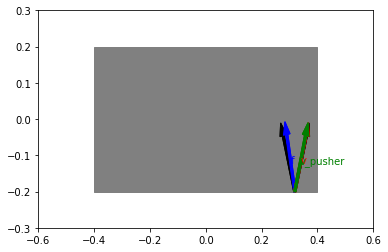

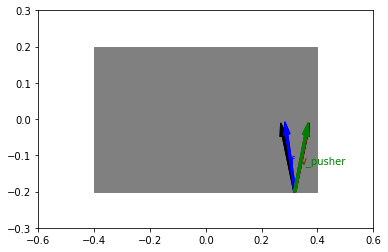

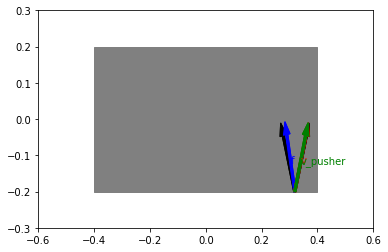

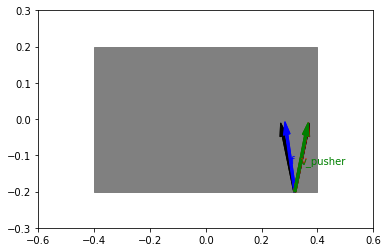

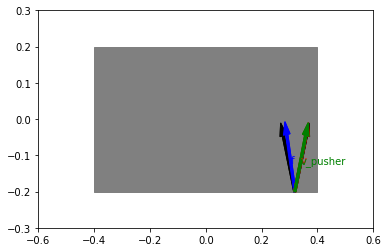

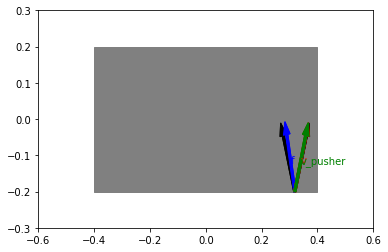

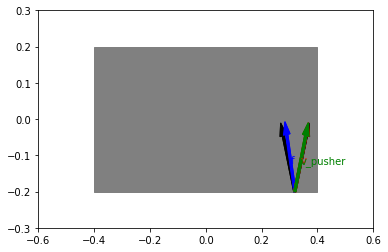

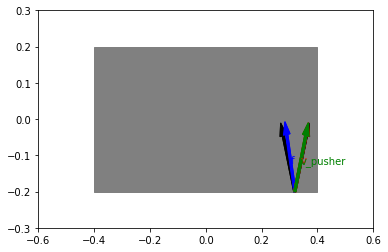

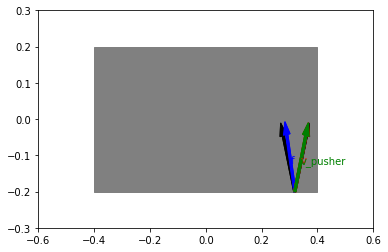

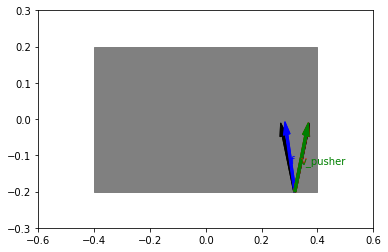

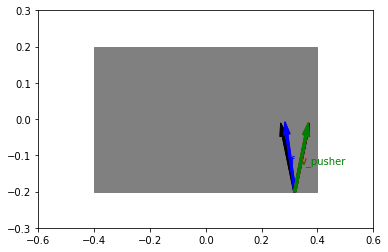

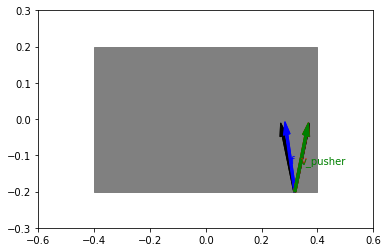

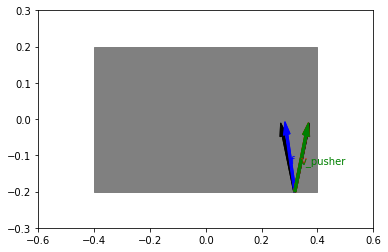

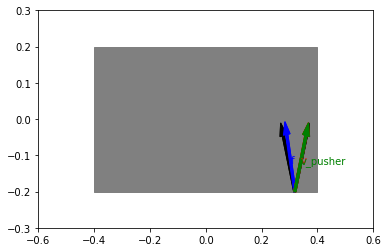

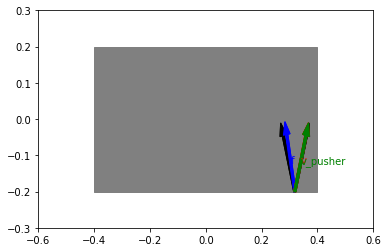

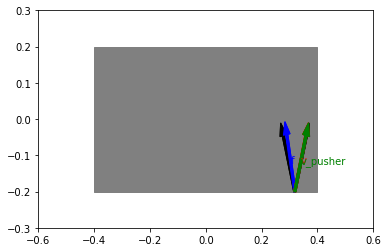

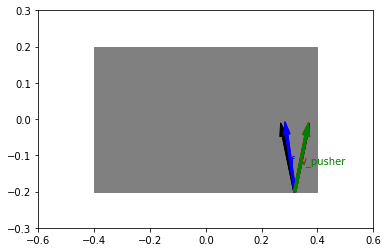

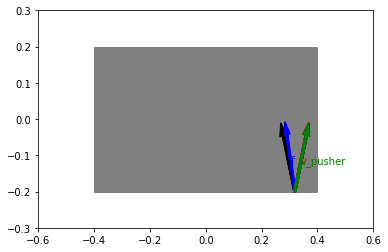

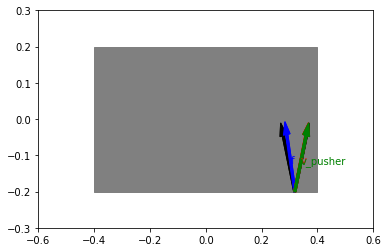

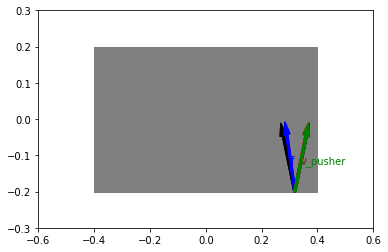

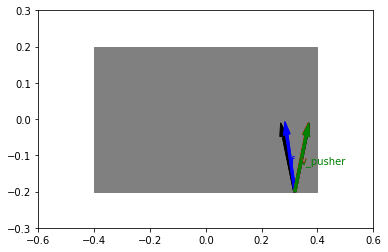

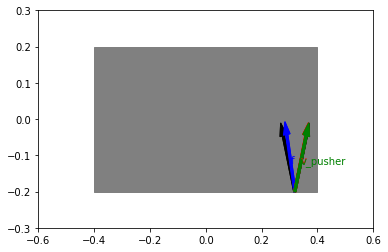

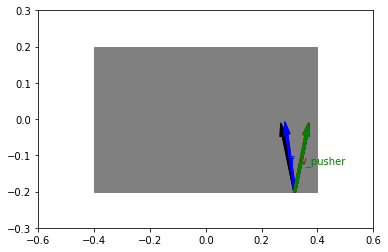

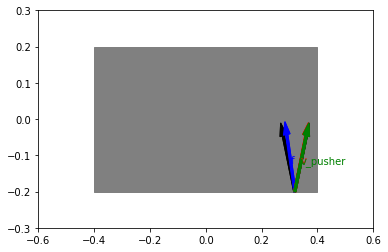

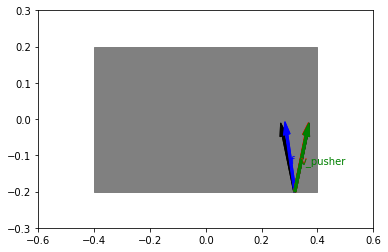

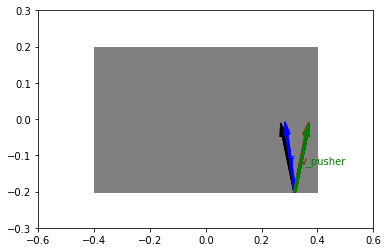

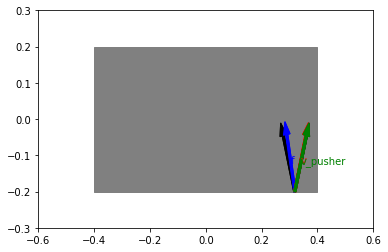

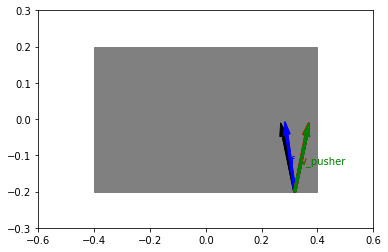

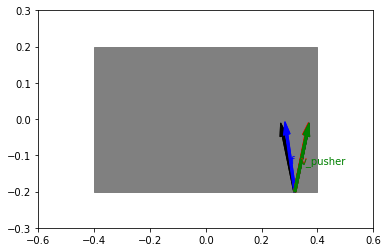

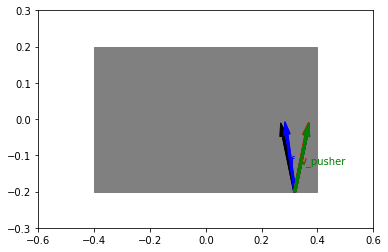

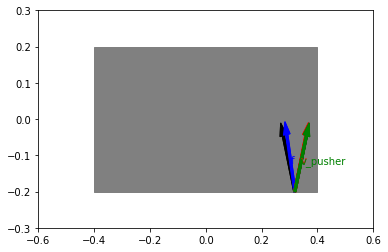

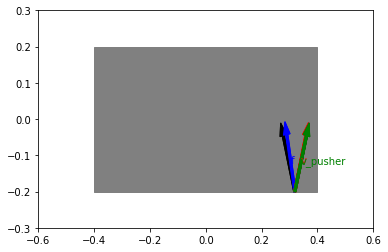

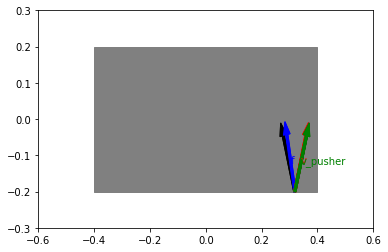

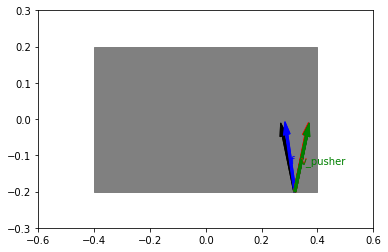

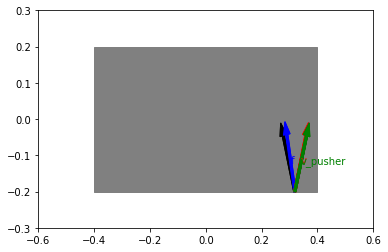

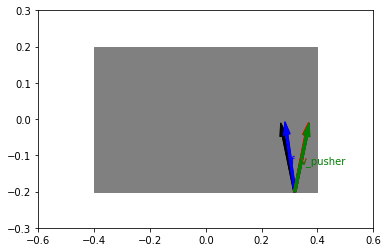

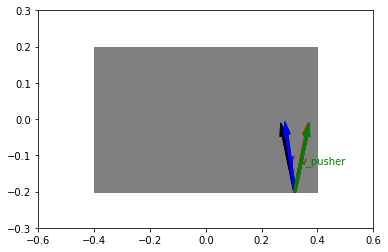

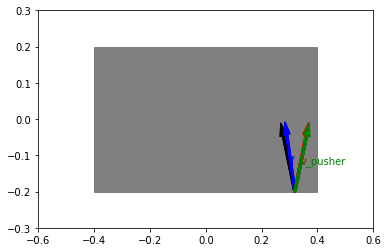

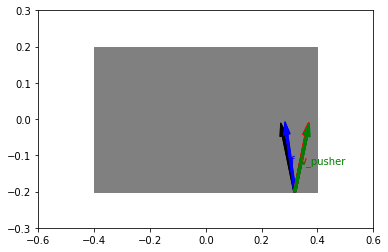

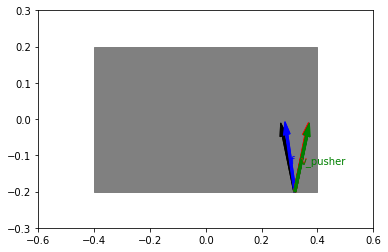

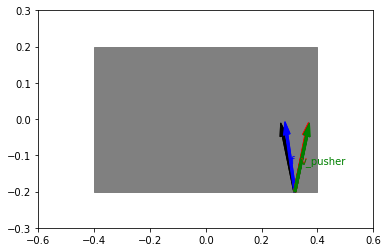

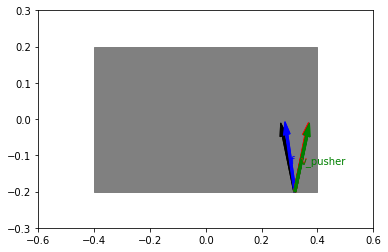

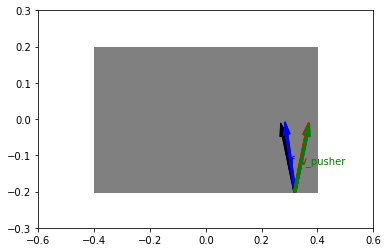

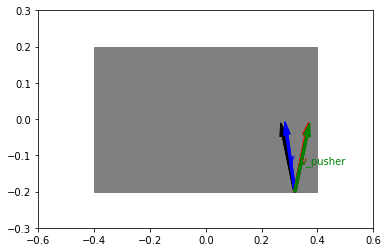

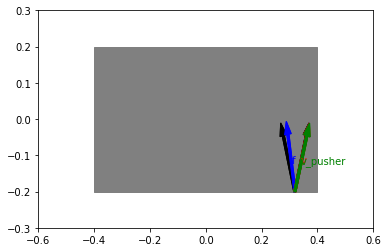

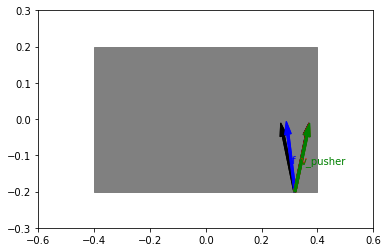

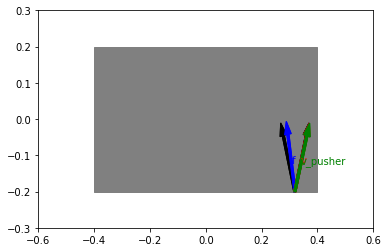

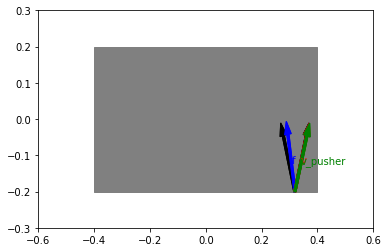

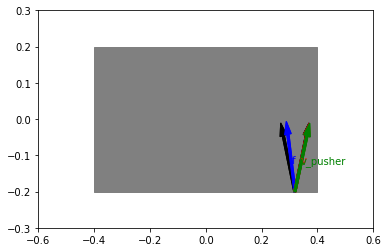

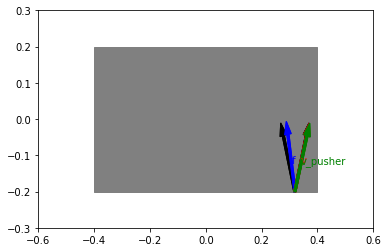

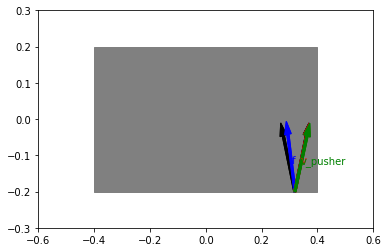

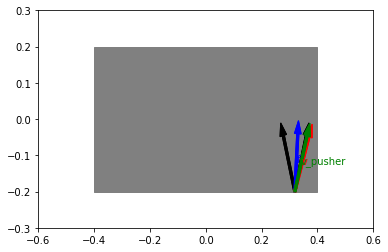

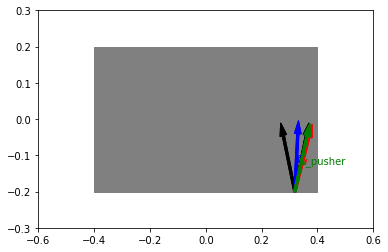

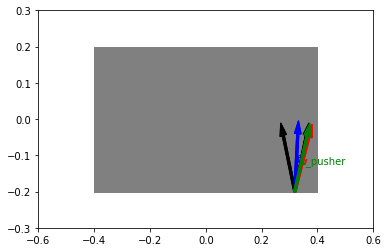

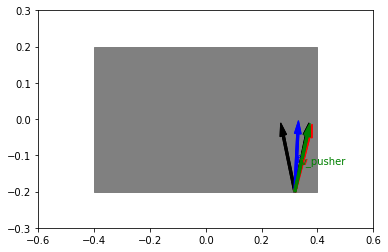

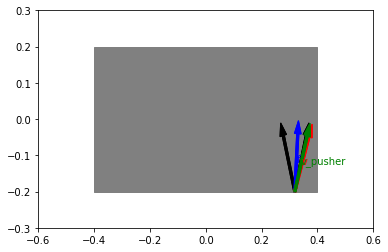

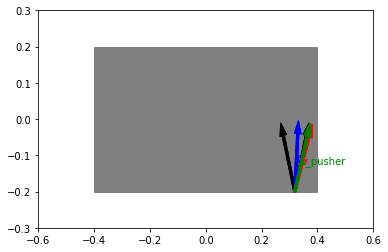

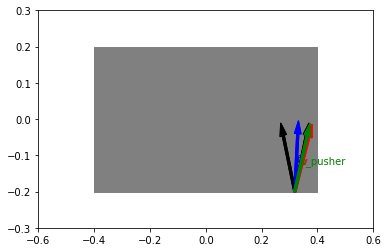

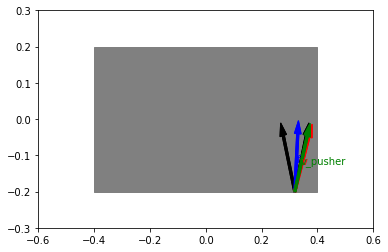

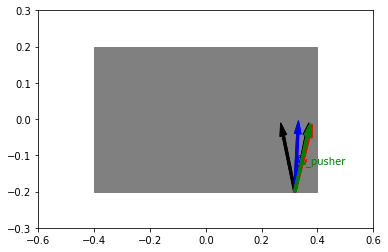

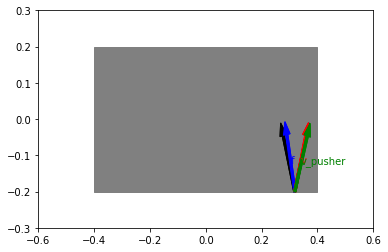

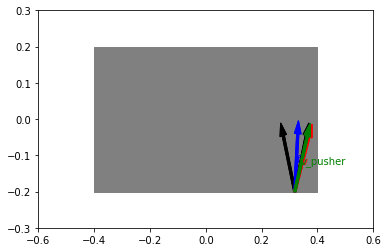

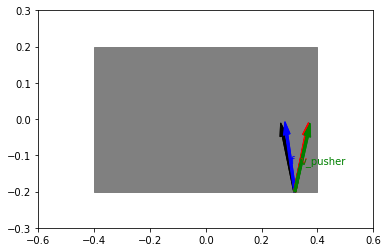

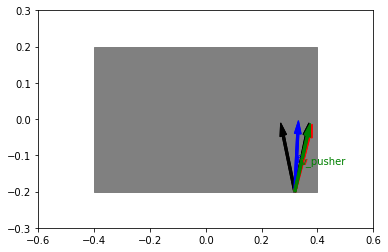

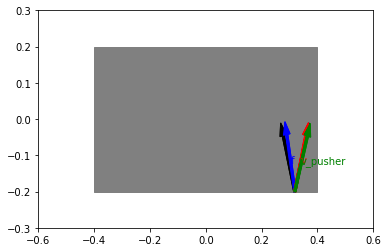

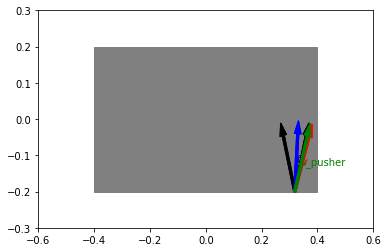

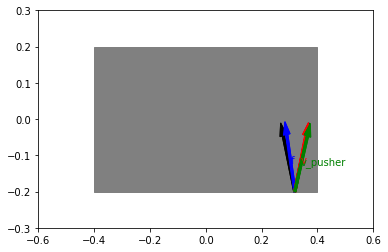

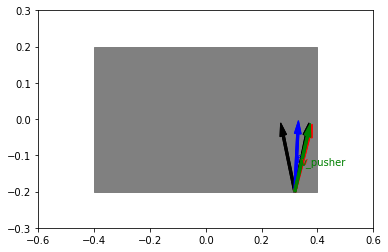

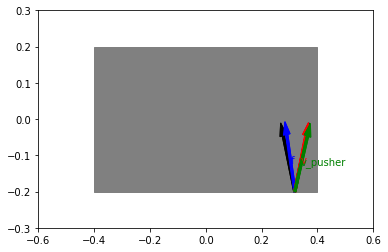

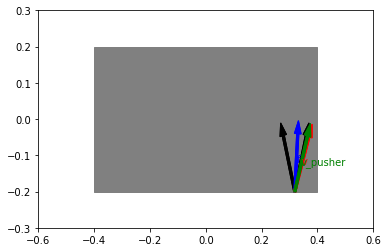

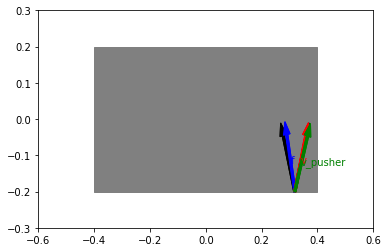

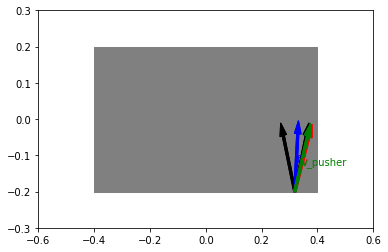

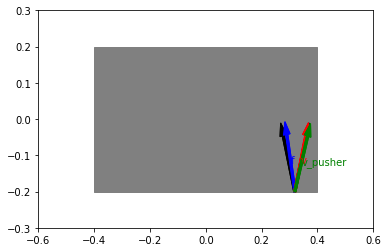

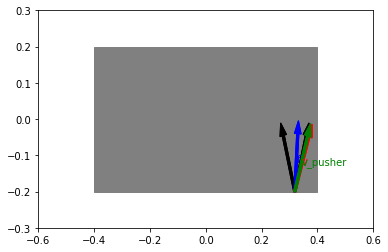

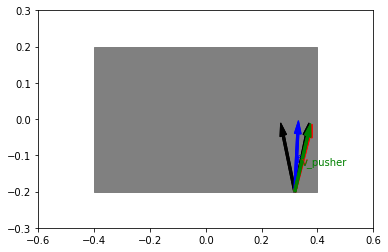

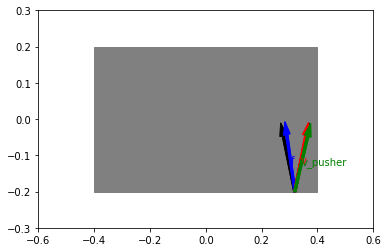

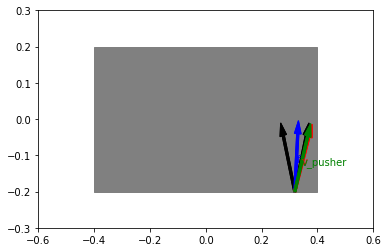

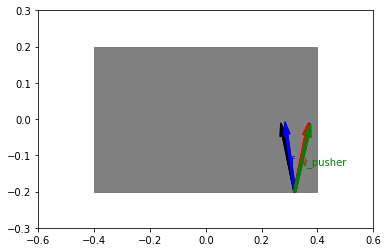

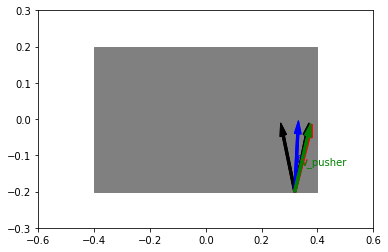

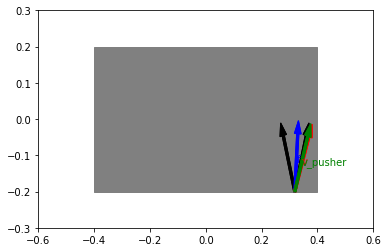

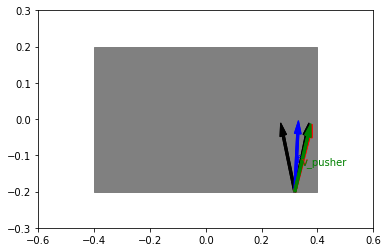

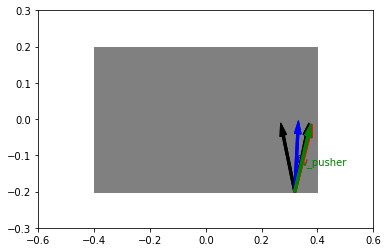

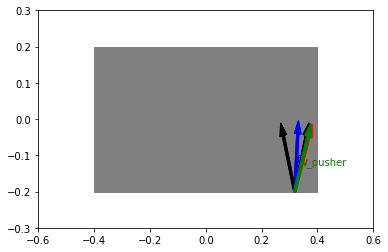

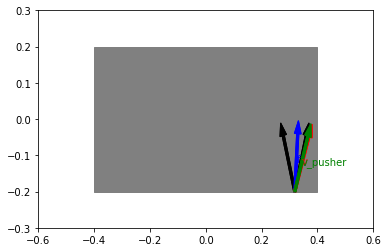

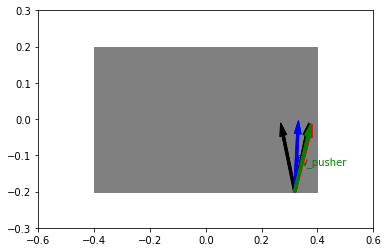

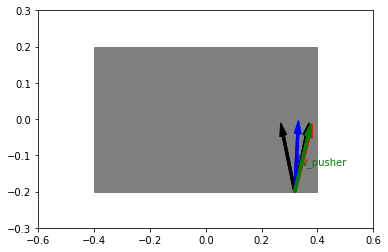

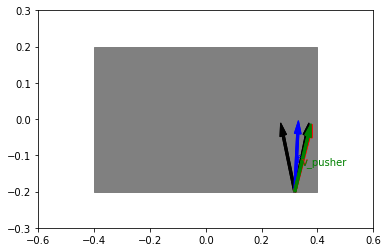

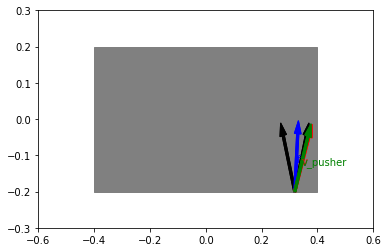

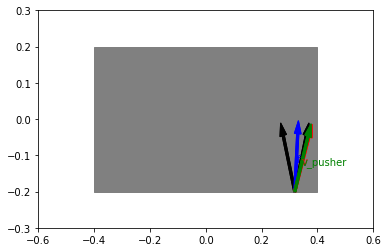

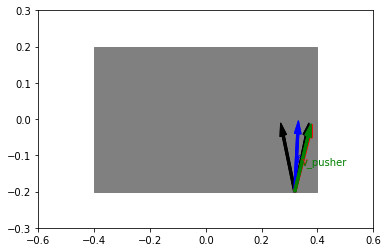

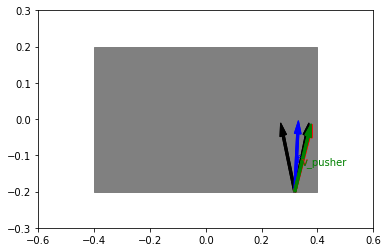

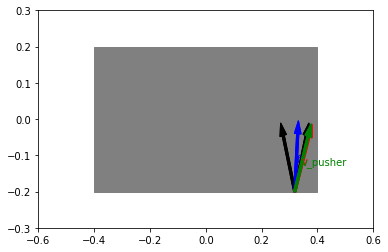

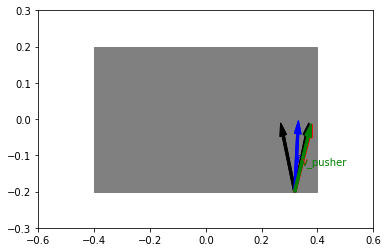

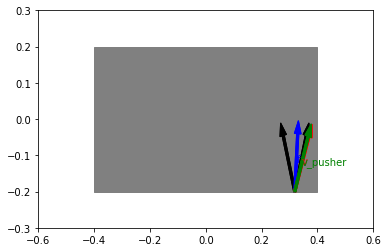

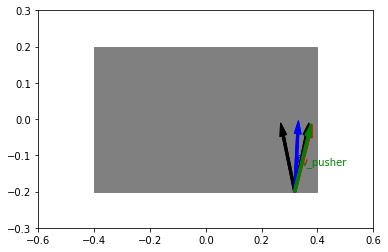

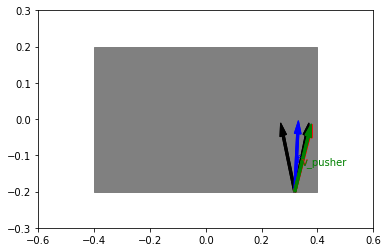

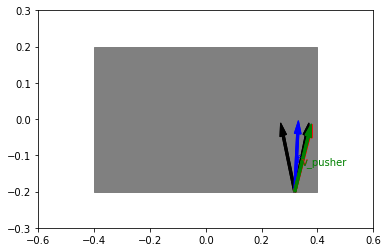

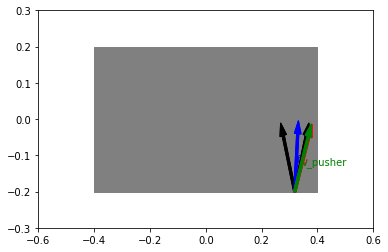

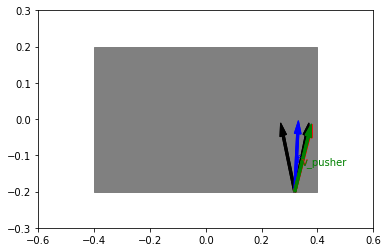

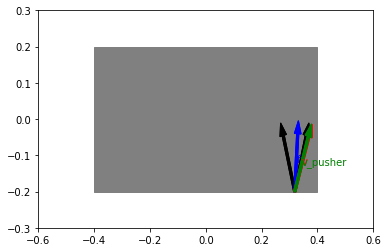

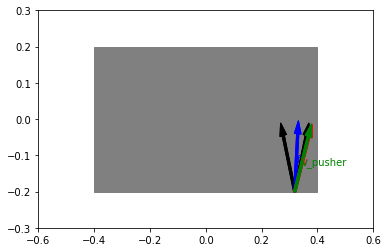

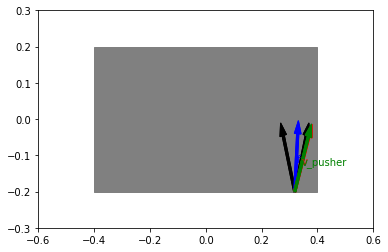

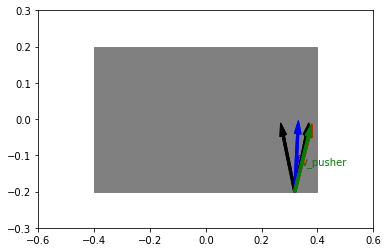

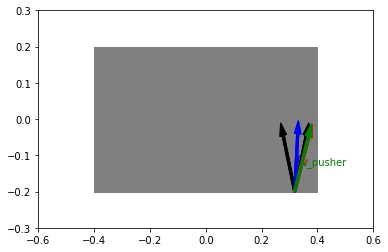

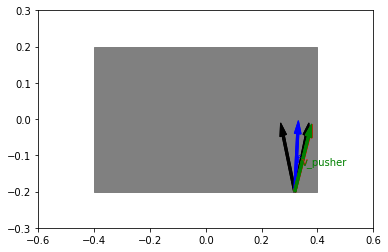

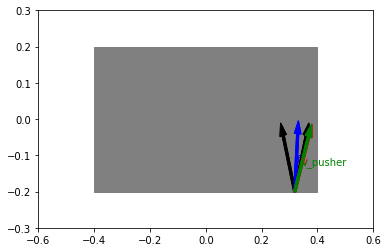

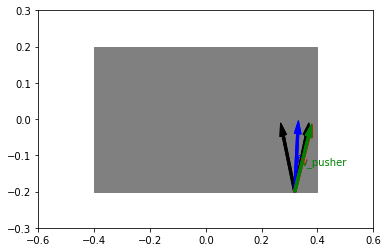

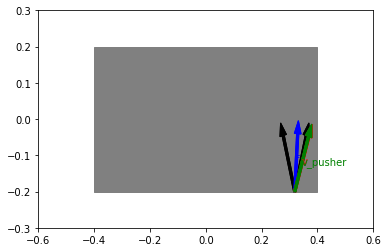

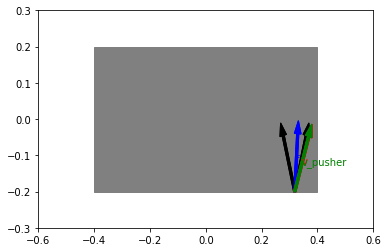

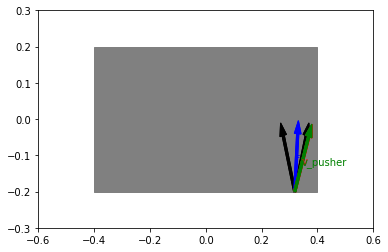

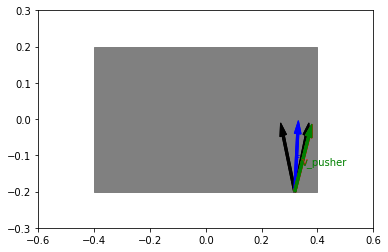

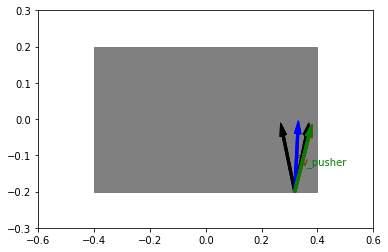

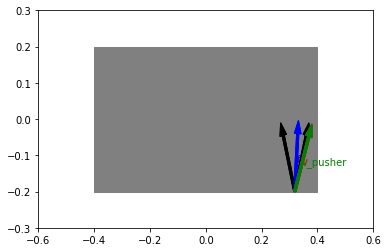

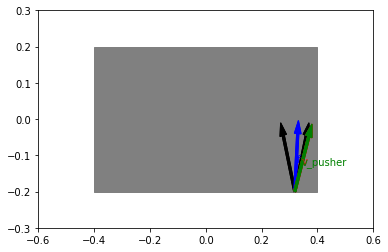

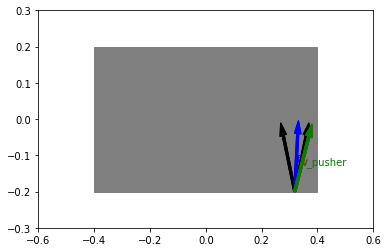

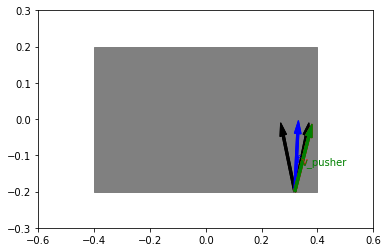

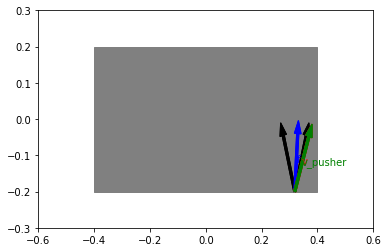

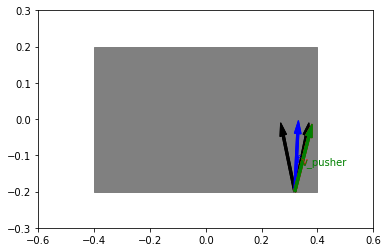

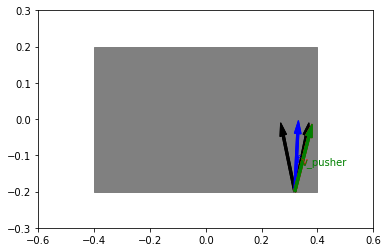

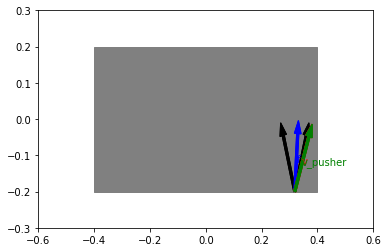

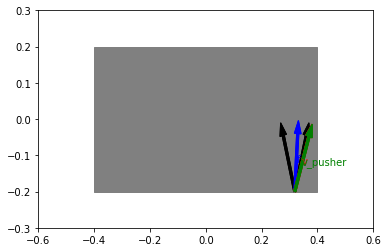

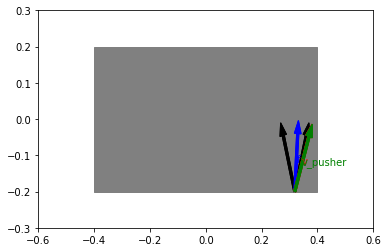

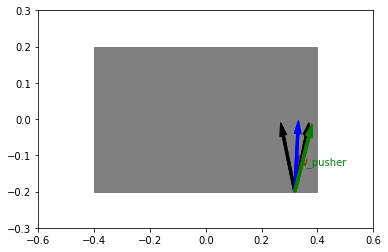

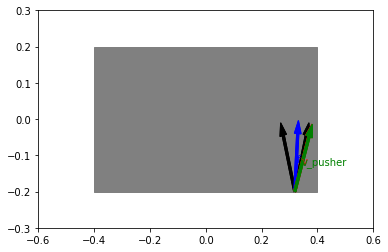

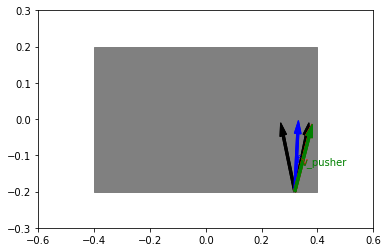

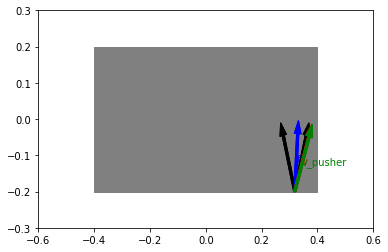

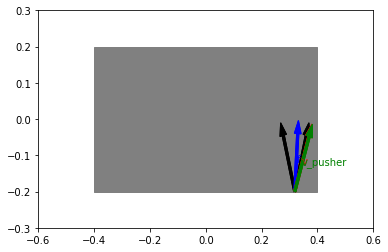

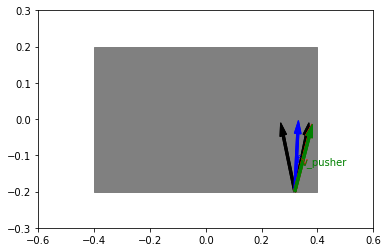

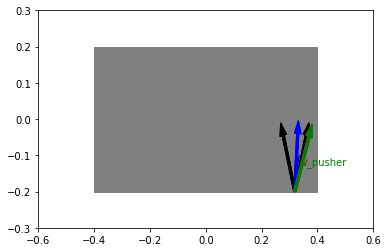

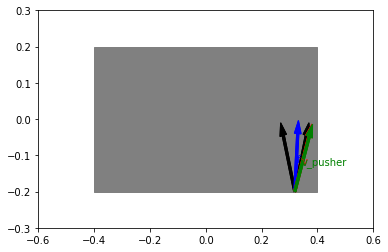

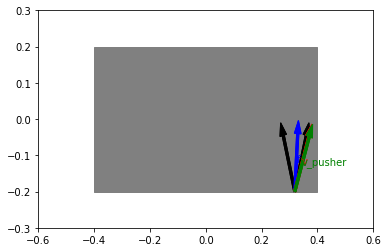

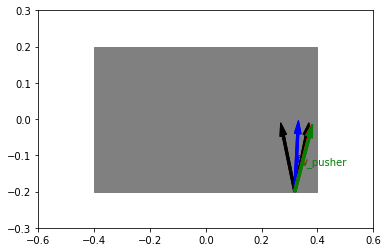

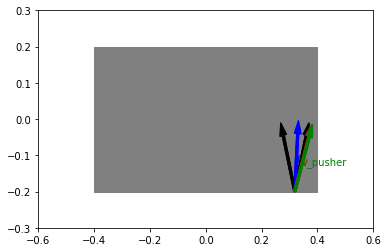

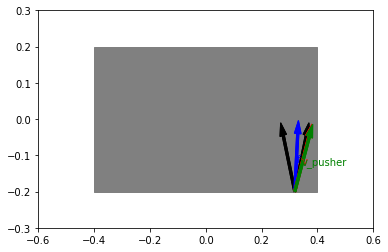

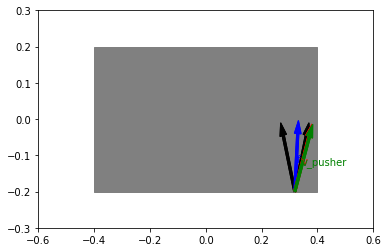

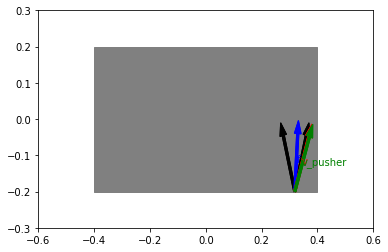

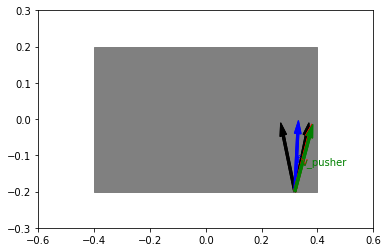

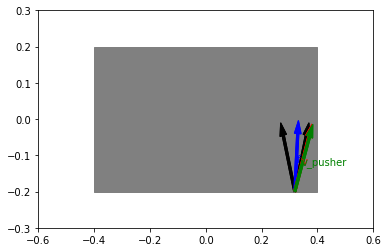

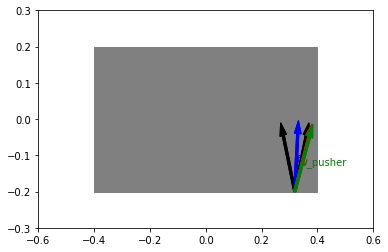

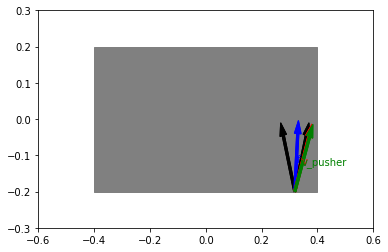

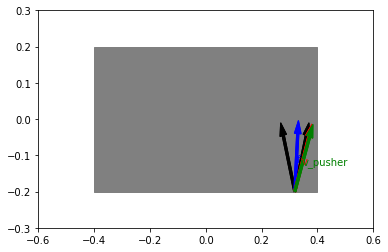

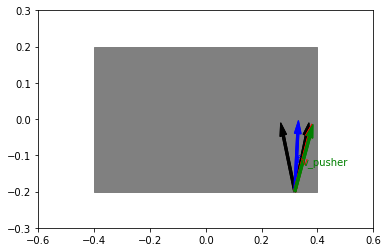

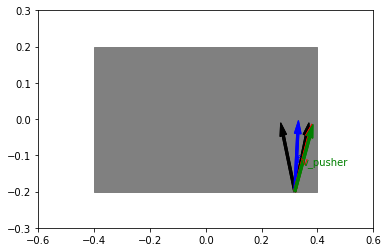

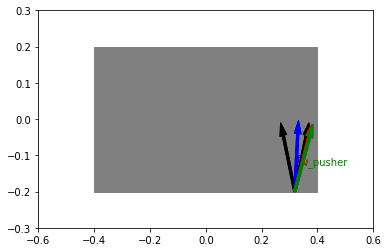

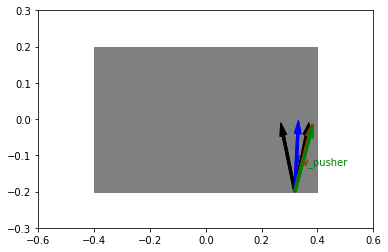

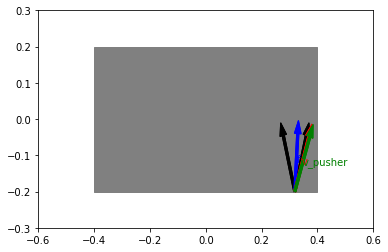

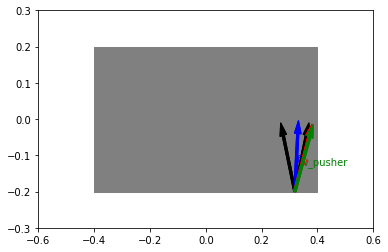

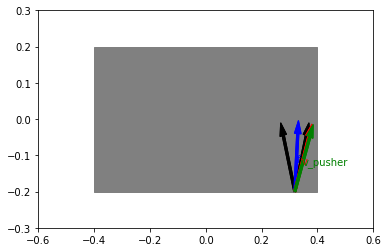

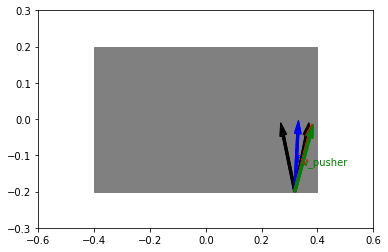

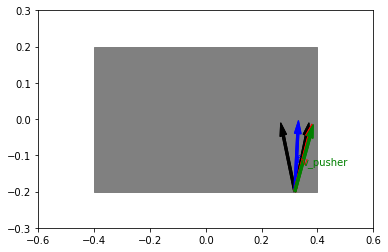

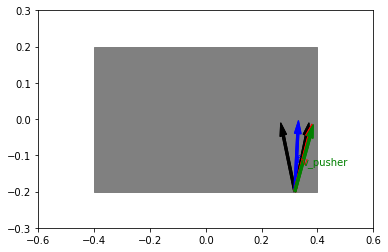

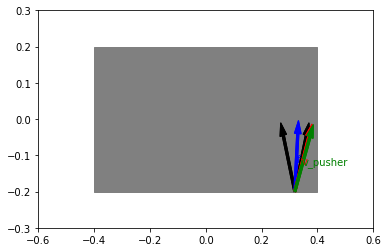

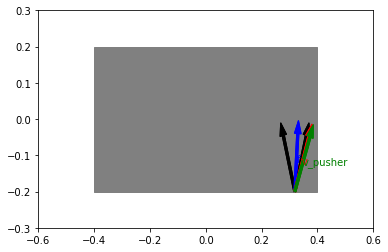

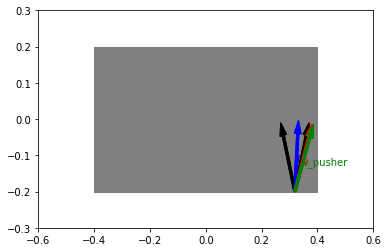

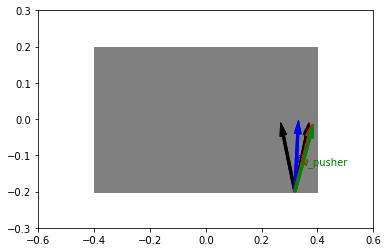

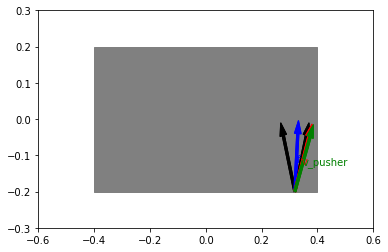

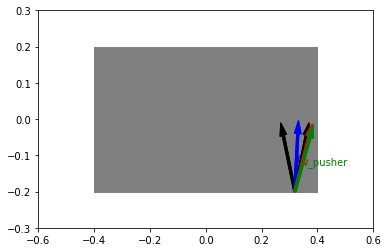

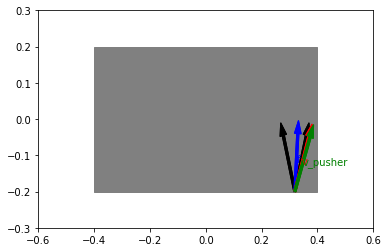

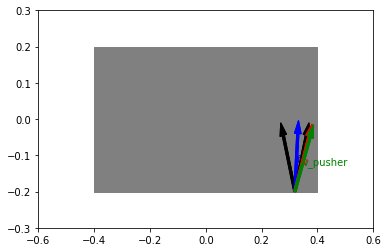

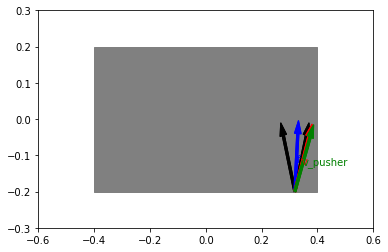

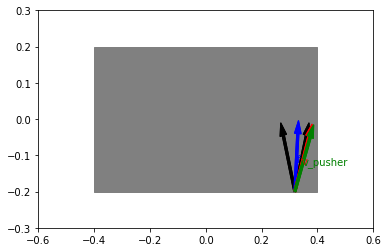

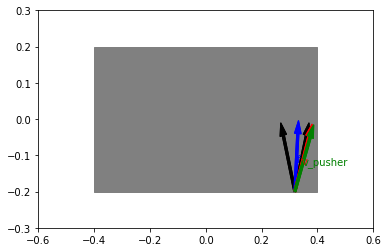

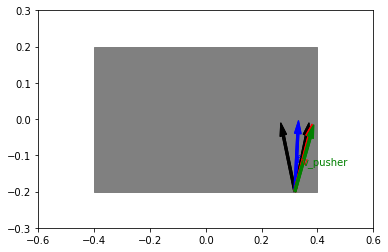

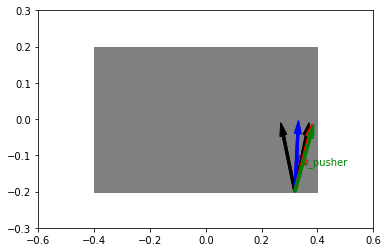

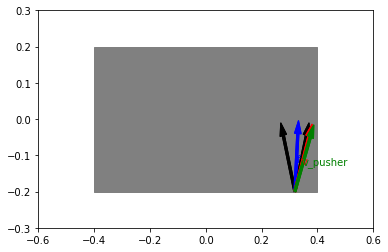

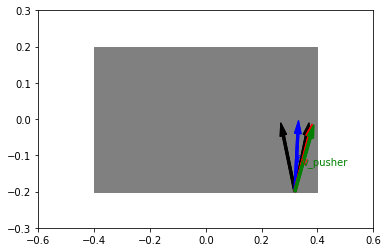

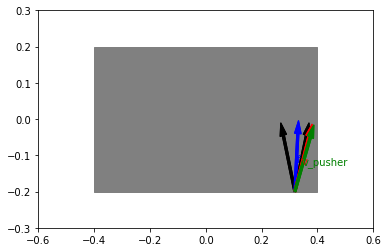

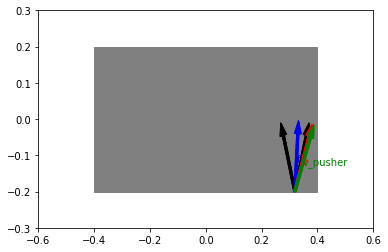

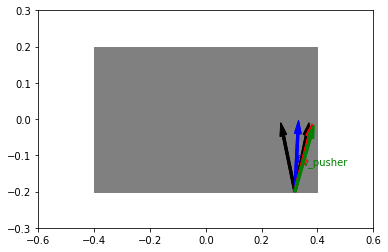

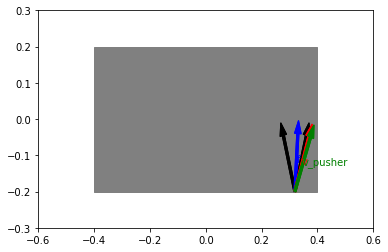

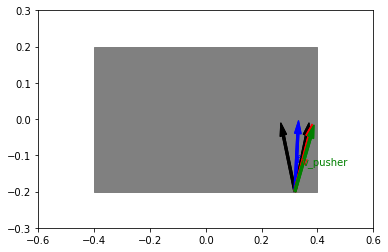

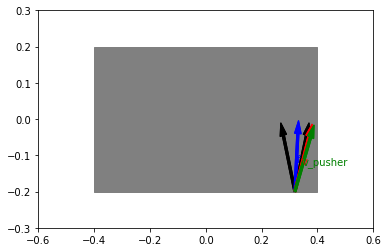

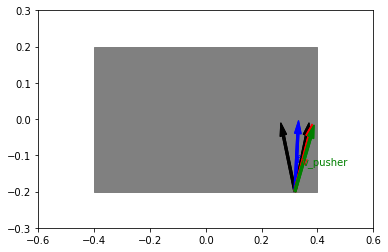

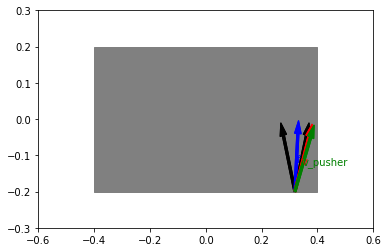

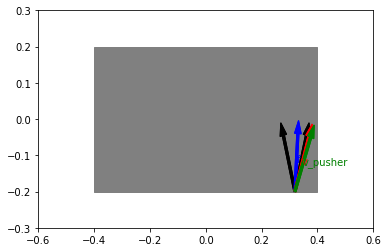

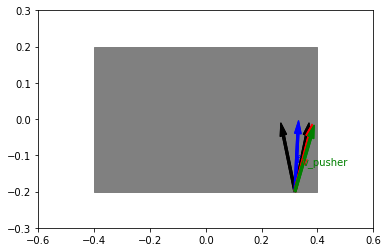

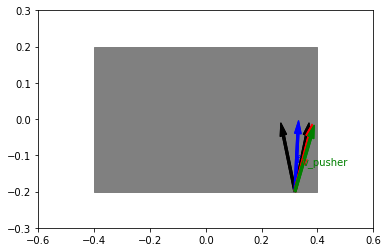

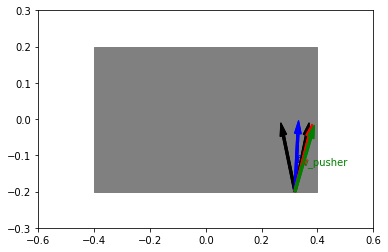

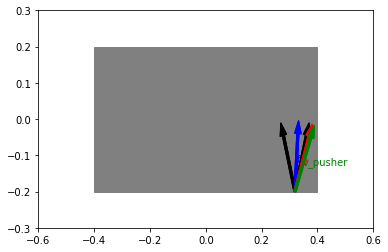

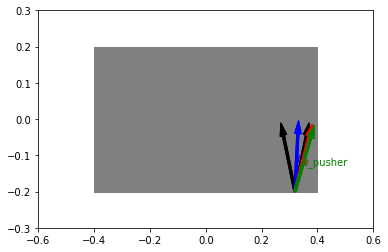

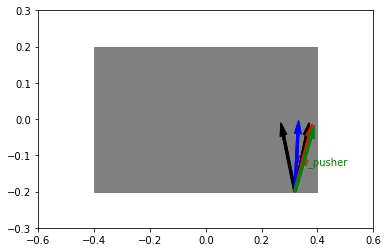

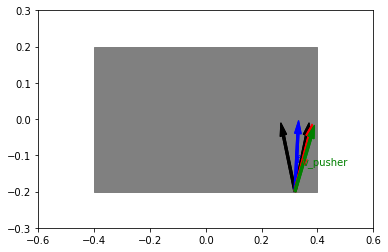

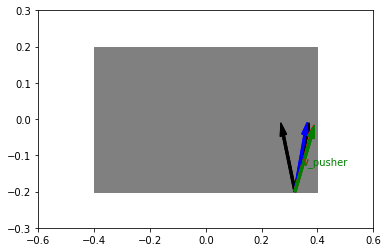

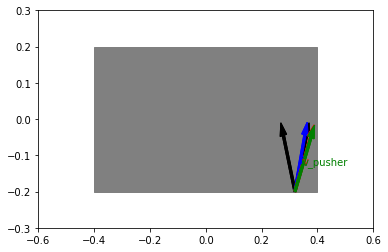

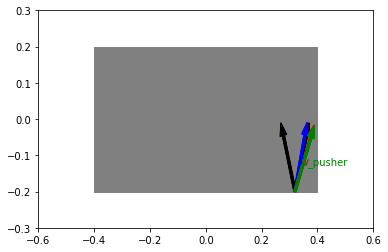

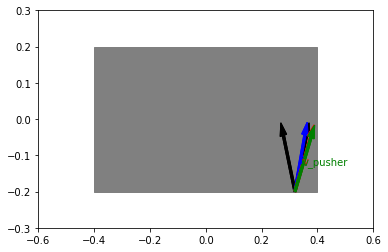

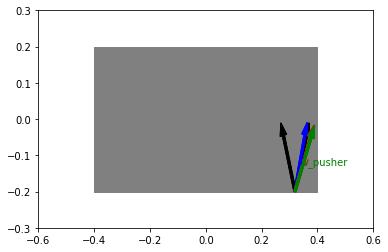

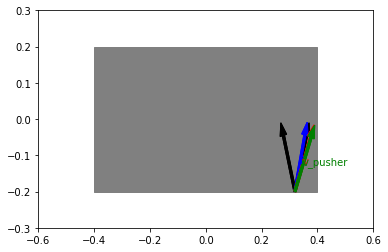

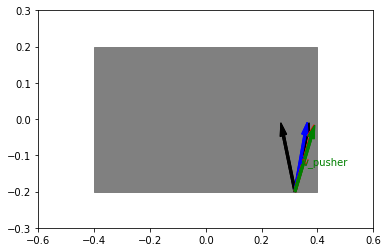

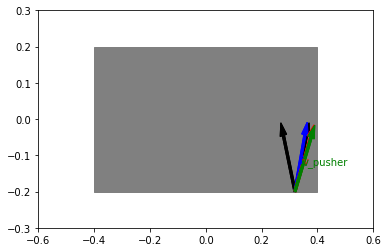

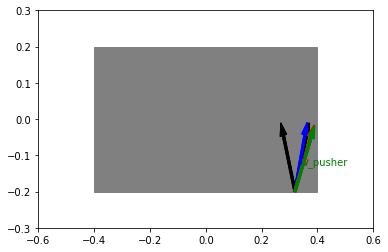

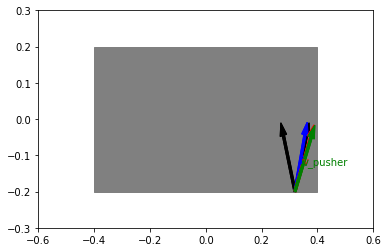

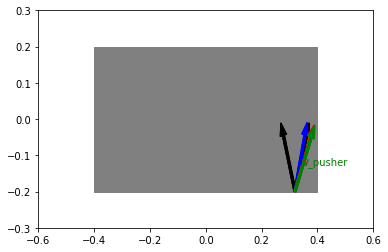

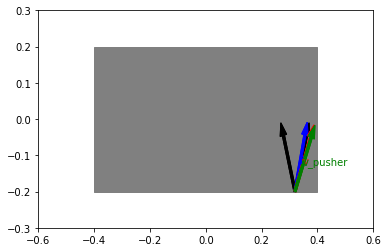

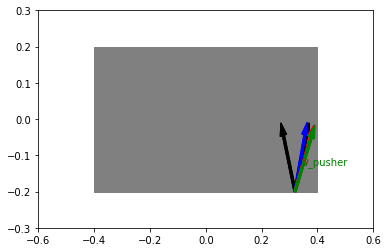

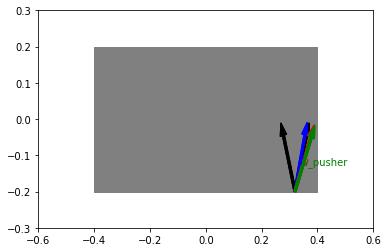

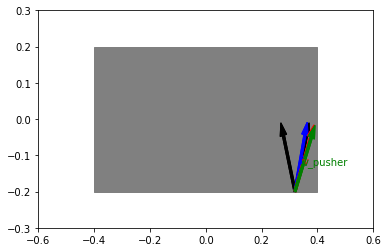

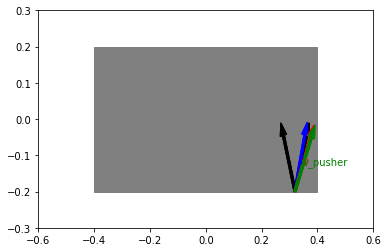

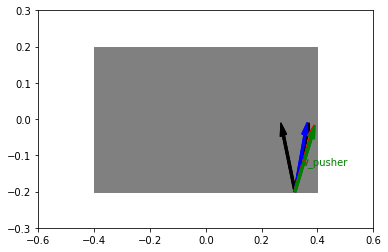

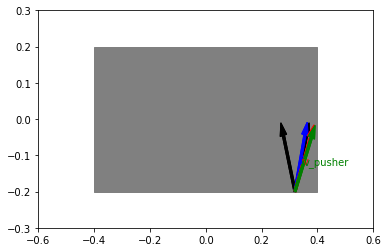

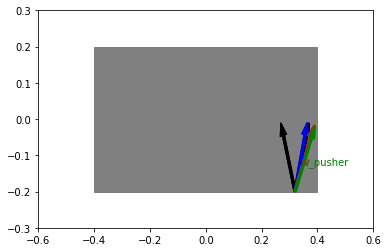

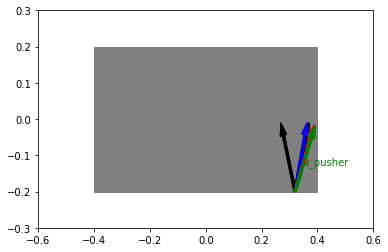

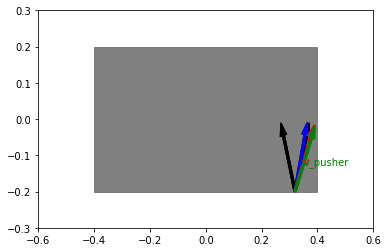

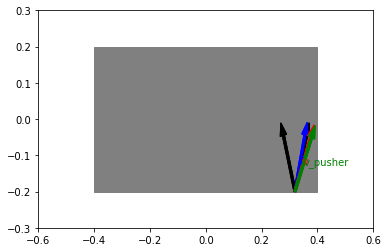

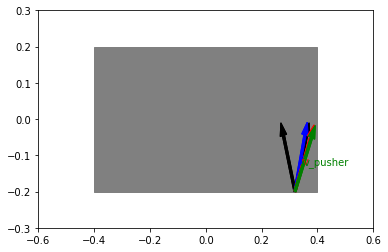

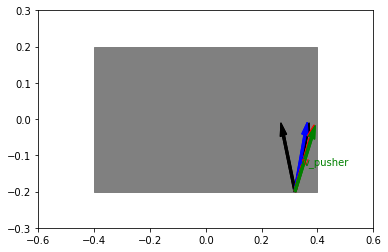

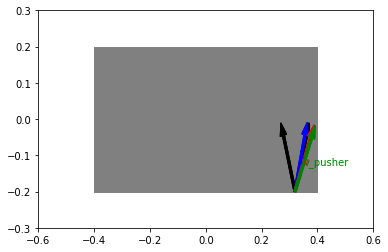

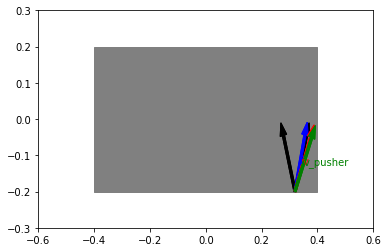

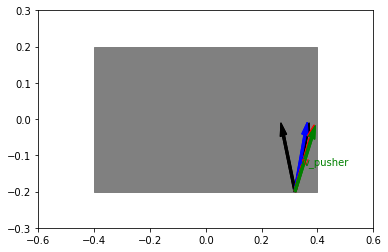

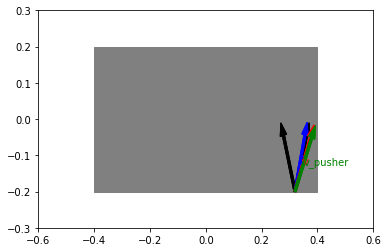

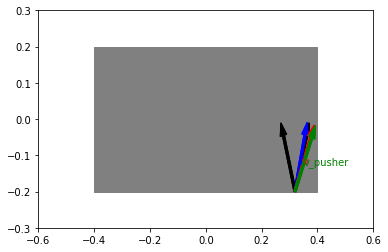

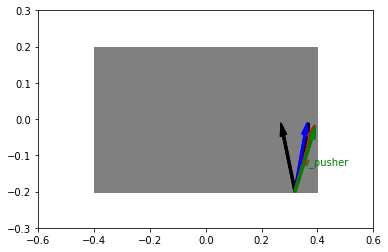

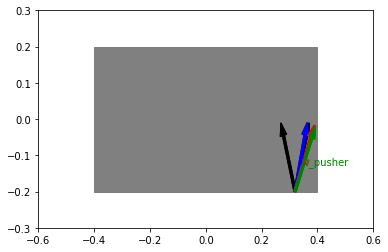

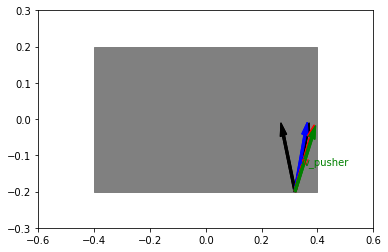

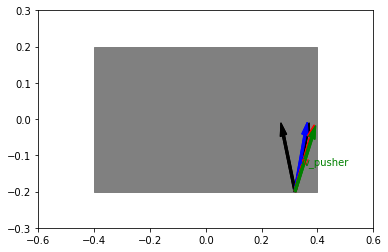

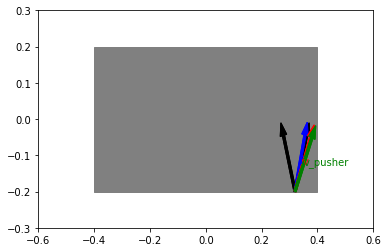

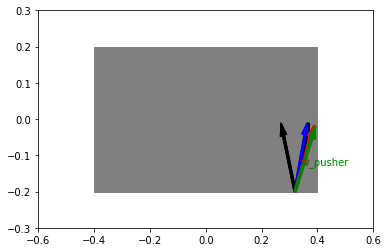

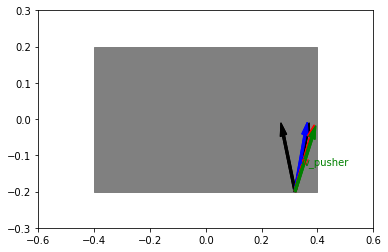

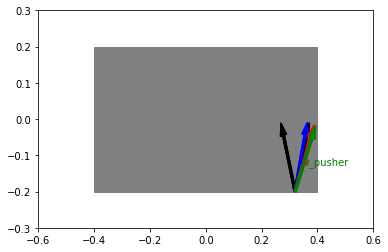

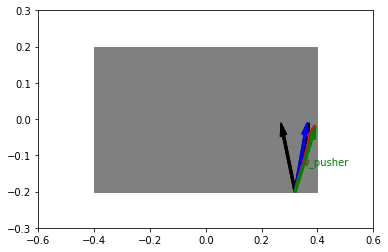

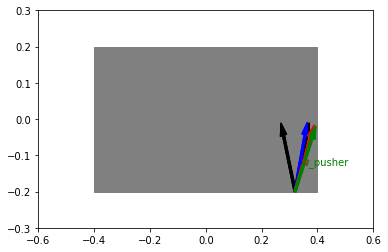

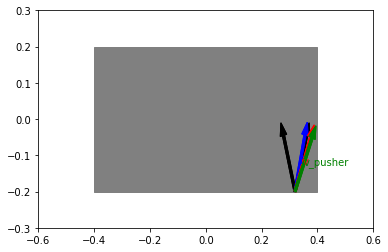

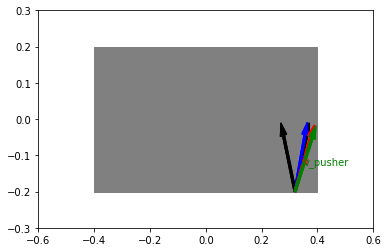

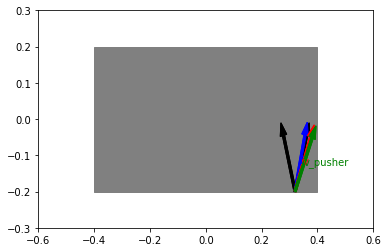

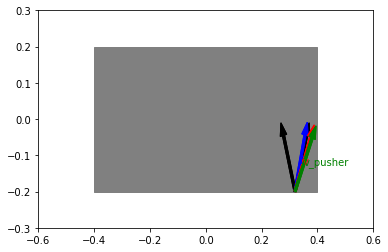

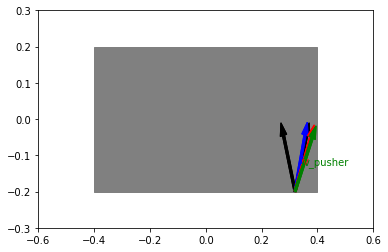

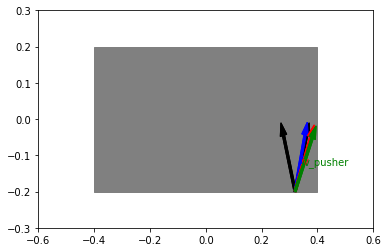

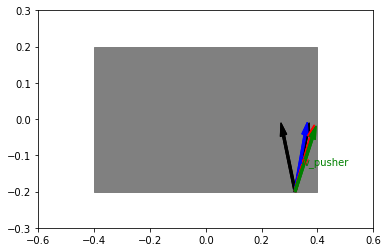

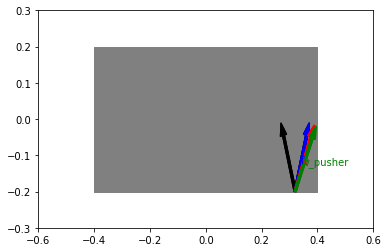

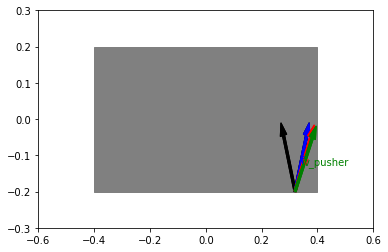

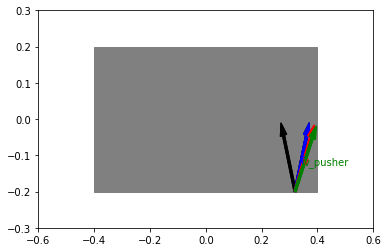

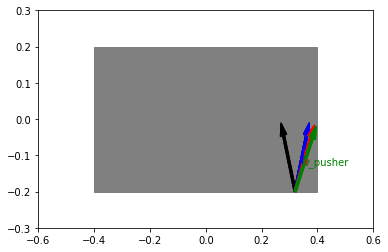

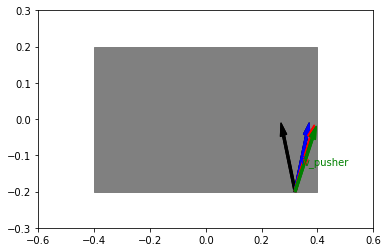

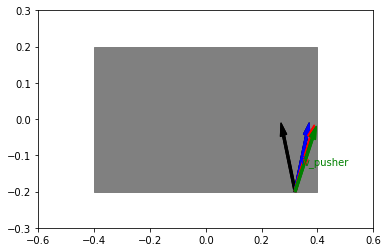

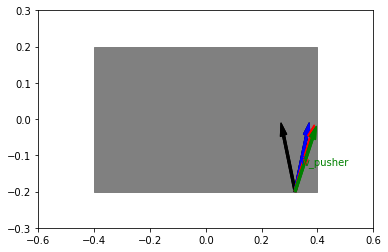

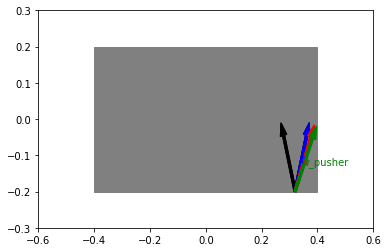

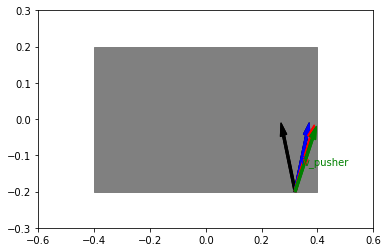

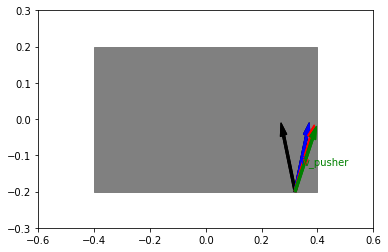

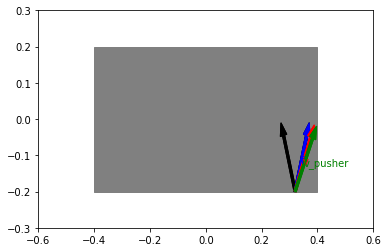

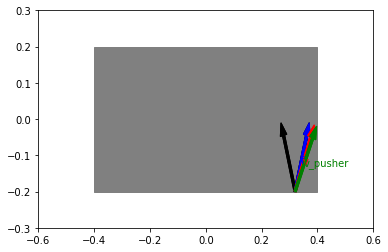

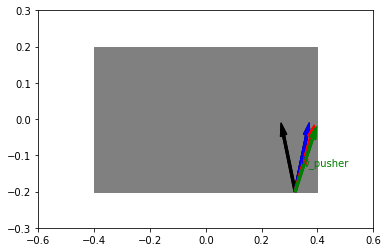

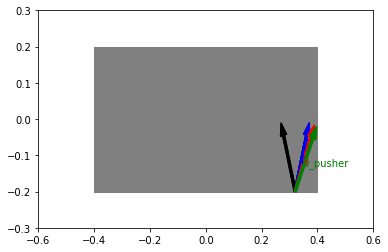

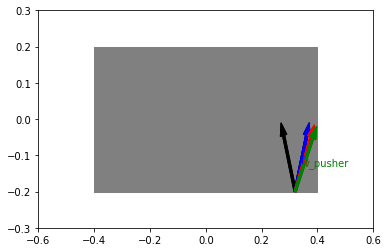

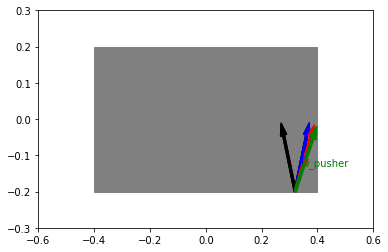

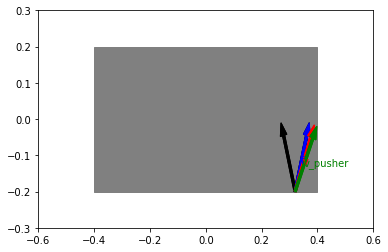

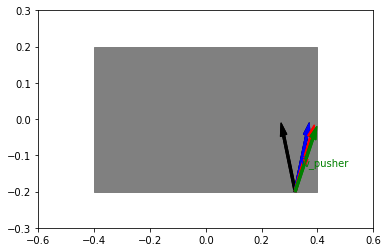

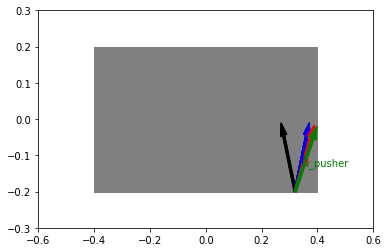

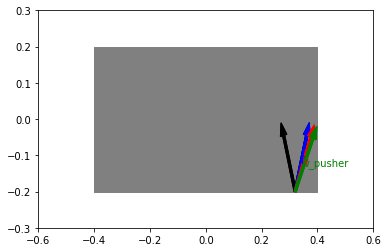

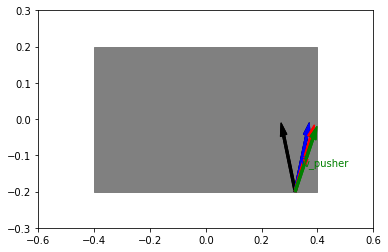

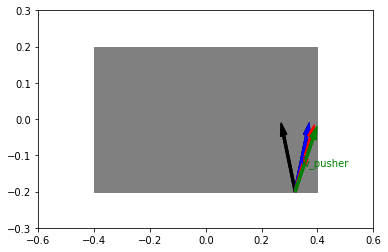

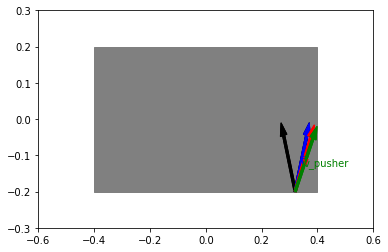

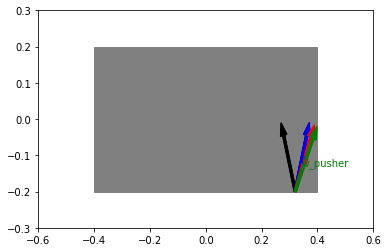

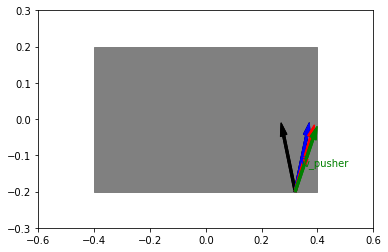

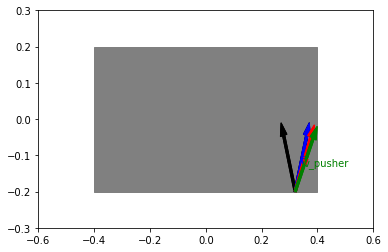

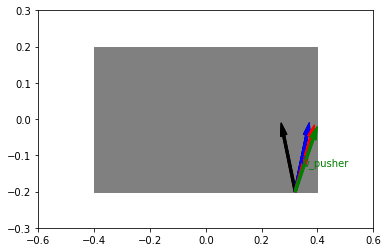

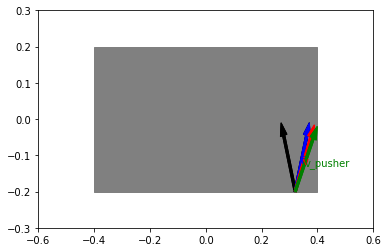

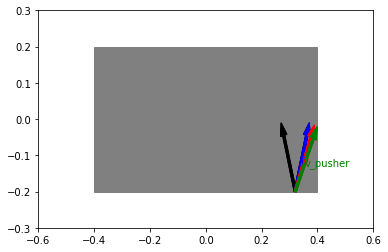

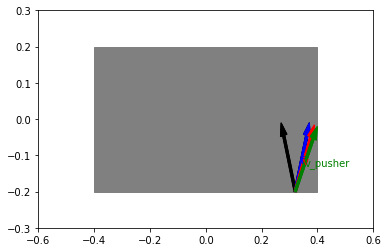

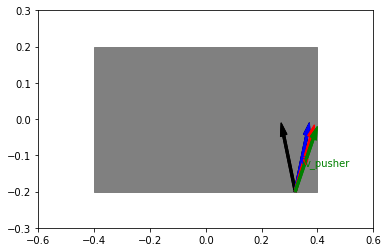

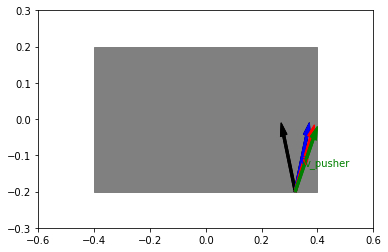

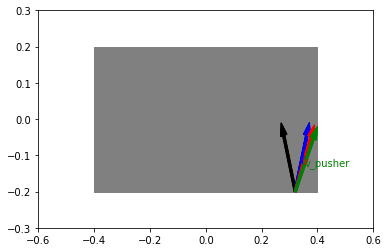

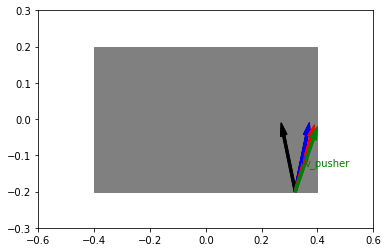

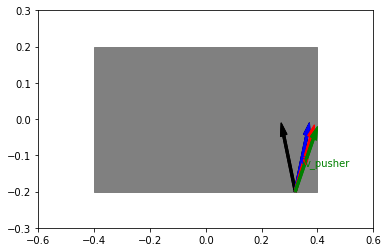

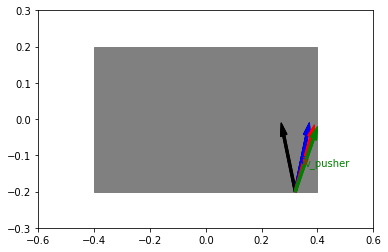

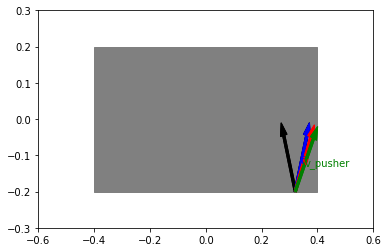

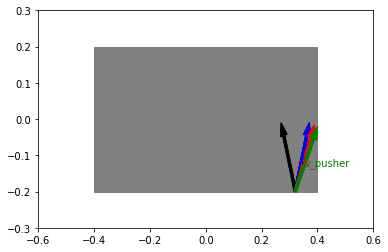

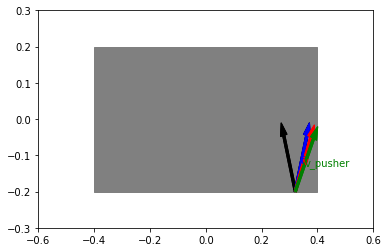

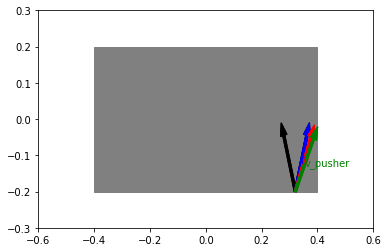

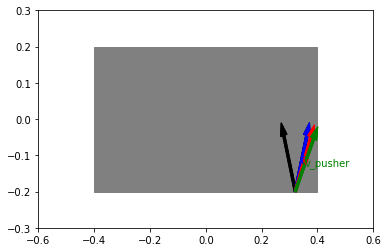

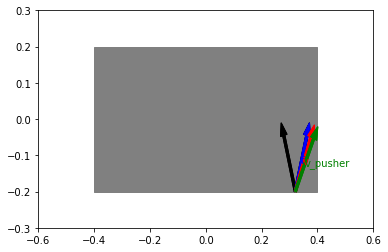

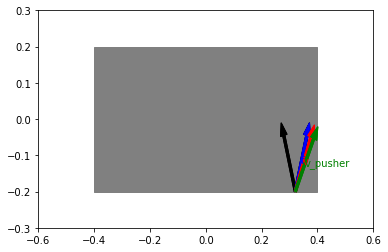

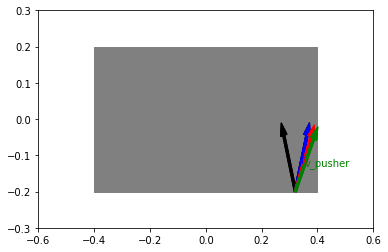

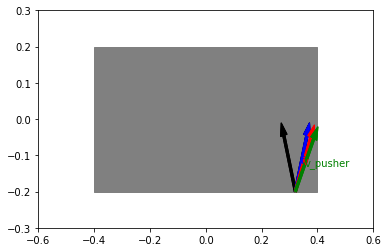

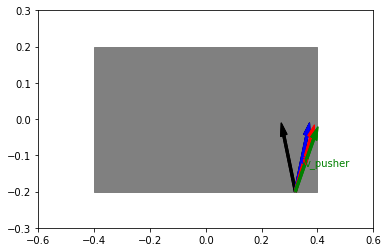

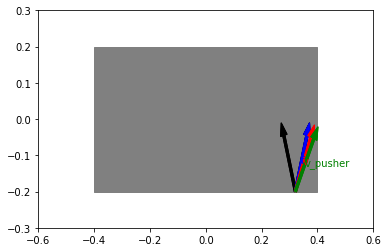

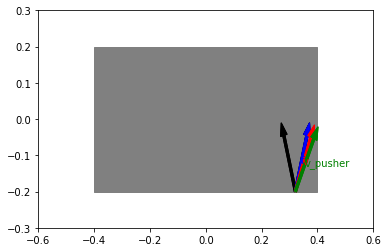

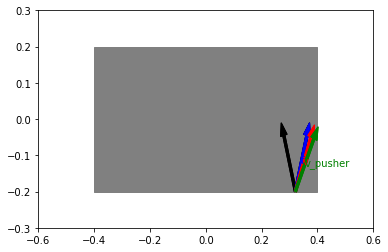

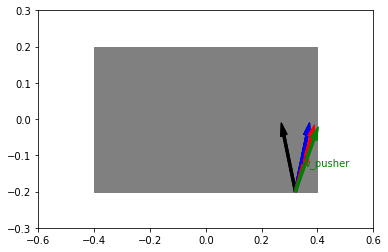

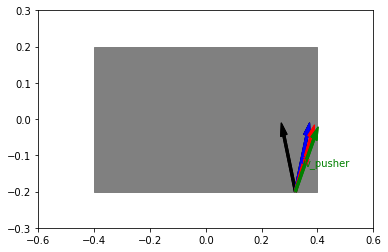

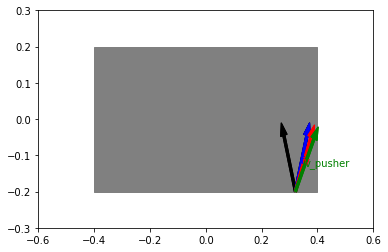

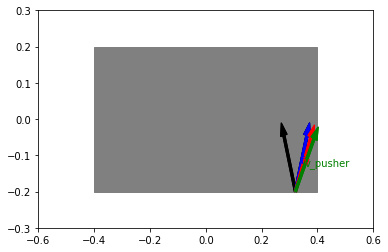

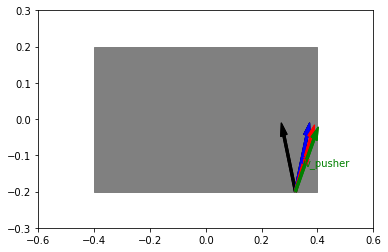

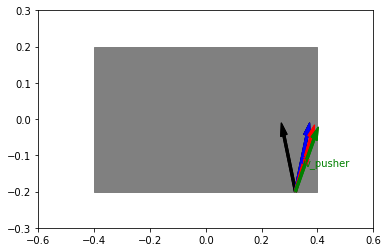

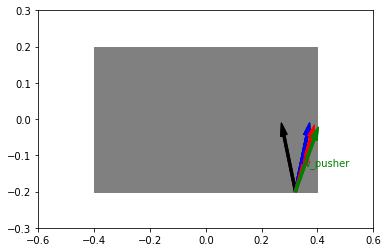

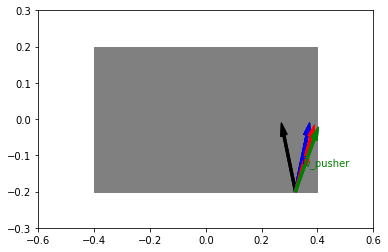

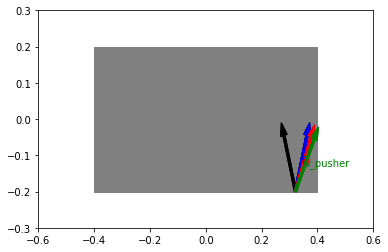

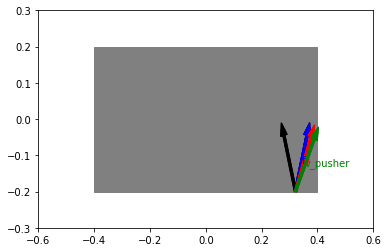

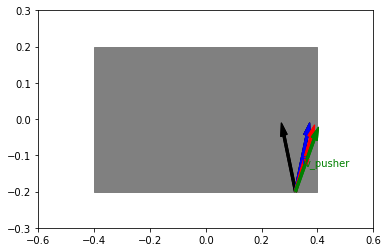

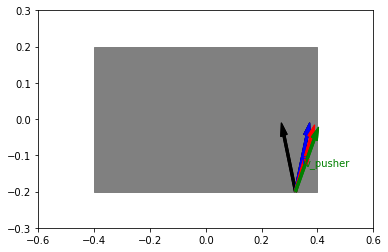

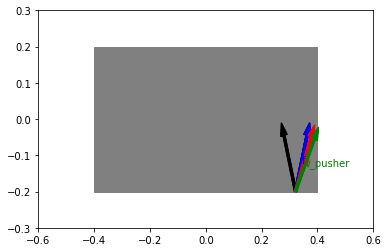

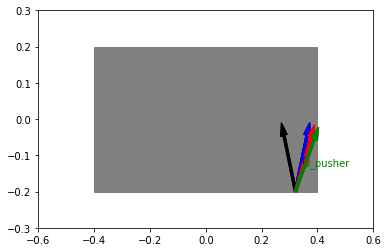

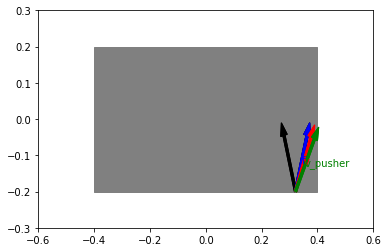

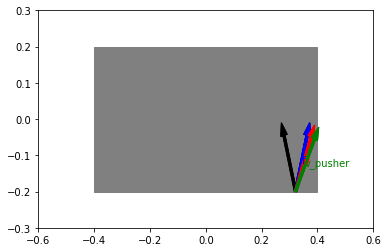

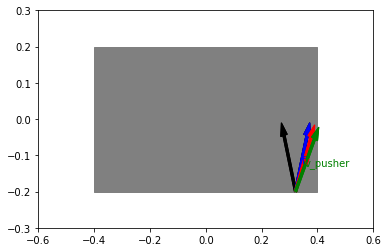

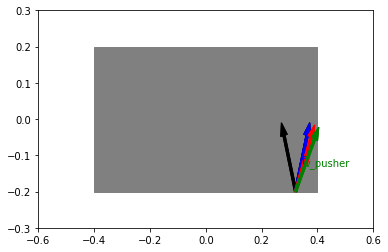

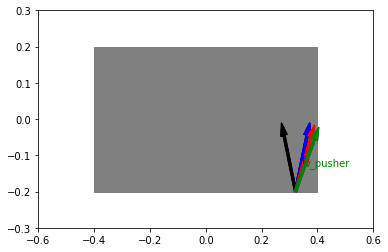

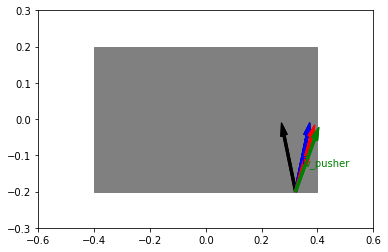

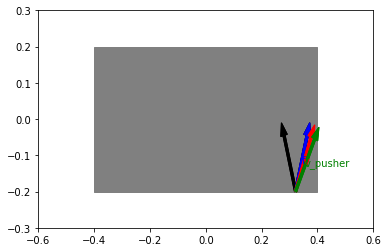

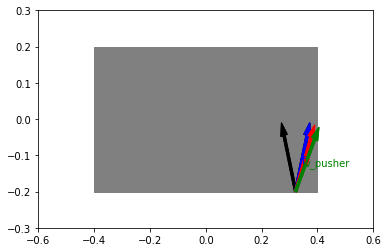

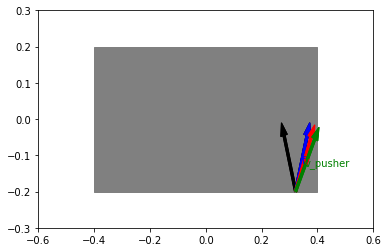

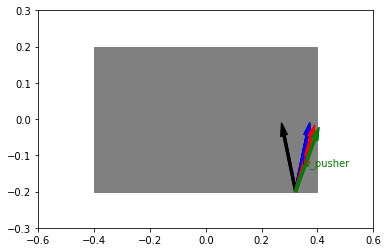

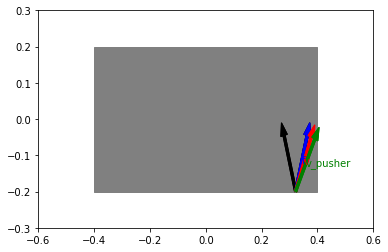

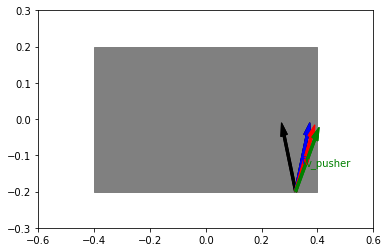

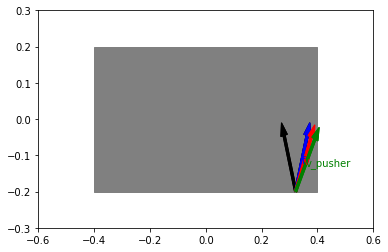

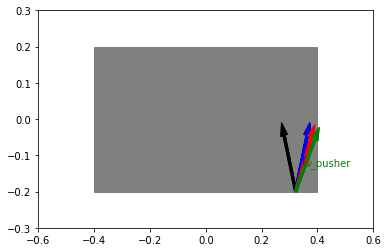

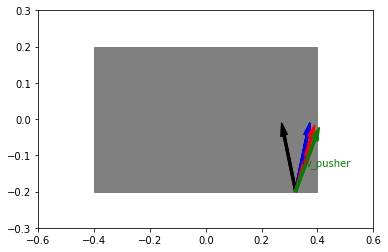

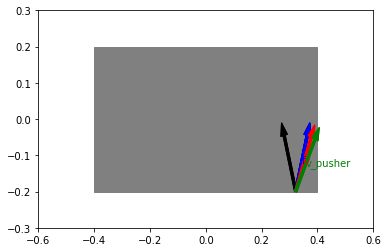

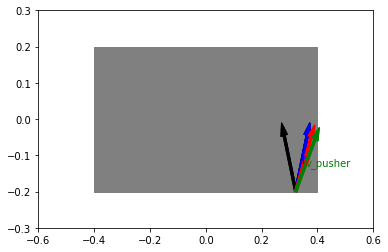

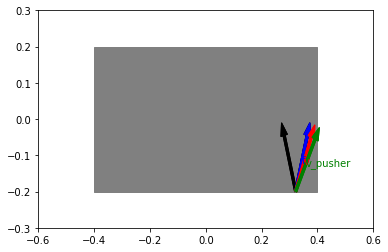

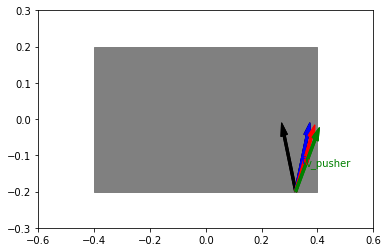

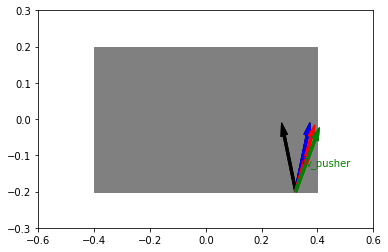

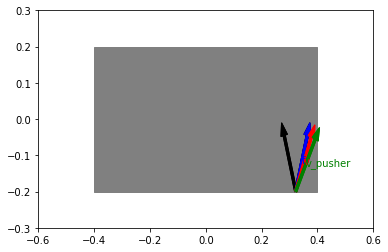

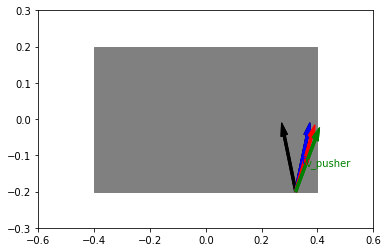

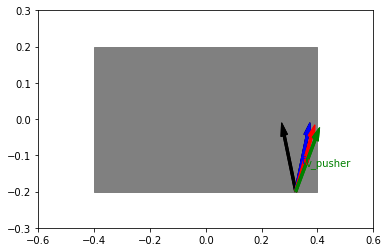

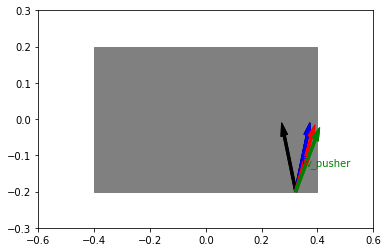

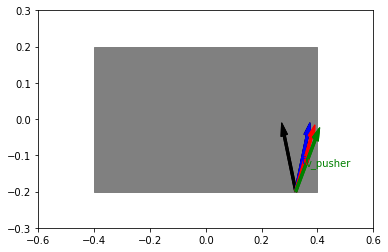

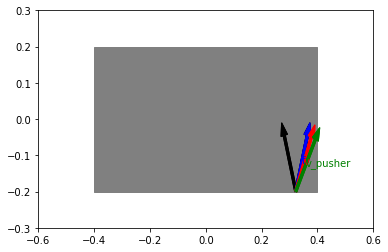

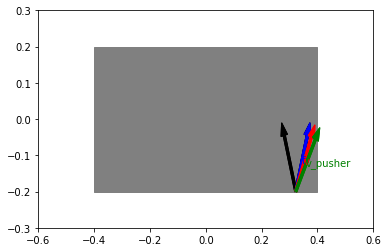

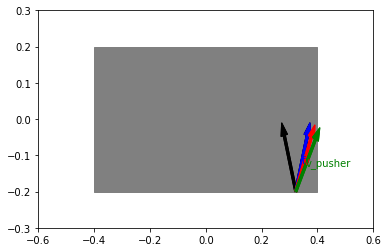

In [4]:
transform = np.zeros((3))
point_transform = np.array([0.35, -0.25])
point_vel_list = np.zeros((800,2))
point_vel_list[:,1] = 0.04
# point_vel_list = np.array([0.0,0.01])
dt = 0.01
sim = FreePointSimulator(grid_ls, transform, point_transform, point_vel_list, dt)
sim.anim()